# Clustering

## 1. Entendimento do Negócio

## 2. Entendimento do Dataset

### 2.1. Importando bibliotecas

In [1]:
# Data manipulation
import pandas               as pd
import numpy                as np

from functools              import reduce

# Visualization
import seaborn              as sns
import matplotlib           as mpl
import matplotlib.pyplot    as plt
from matplotlib.gridspec    import GridSpec

# Machine Learning
import pickle
from sklearn.cluster        import KMeans

# Other
import warnings
import inflection

from datetime               import datetime

### 2.2. Configurações

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Visualization Settings
%matplotlib inline

mpl.style.use('ggplot')

mpl.rcParams['figure.titlesize']    = 24
mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 14

# Palette Setting
color_palette = ['#023047', '#0077b6', '#0096c7', '#ff9c33', '#ff8200', '#e85d04']
sns.color_palette(color_palette)

[(0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (0.0, 0.4666666666666667, 0.7137254901960784),
 (0.0, 0.5882352941176471, 0.7803921568627451),
 (1.0, 0.611764705882353, 0.2),
 (1.0, 0.5098039215686274, 0.0),
 (0.9098039215686274, 0.36470588235294116, 0.01568627450980392)]

### 2.3. Funções

In [3]:
def df_shape(df):
    """
    Summary: The function prints the number of rows and columns of a given DataFrame
    Args: DataFrame we want to know more about
    Returns: number of rows and columns of the DataFrame
    """
    print('Número de linhas: {:,}'.format(df.shape[0]))
    print('Número de colunas: {:,}'.format(df.shape[1]))

    return None

def columns_to_snake_case(dataframe):
    """
    Summary: This function transforms the column names to snake_case style
    Args: Dataframe with incorrect column names
    Returns: None
    """
    # List of columns
    old_columns = dataframe.columns.tolist()
    # Lambda function
    snake_case = lambda x: inflection.underscore(x)
    # Assigning new column names to DataFrame
    dataframe.columns = list(map(snake_case, old_columns))

    return None

def df_null_values(dataframe, filter_nulls=True):
    """
    Summary: 
        This function displays the name of the columns that have Null values (total and percentage) of a dataframe
    Args: 
        dataframe: the origin of the data as a Dataframe 
        filter_nulls: if True, only columns with Null values will be displayed
    Returns: 
        Dataframe with name of feature, Null values, Null% values and the type of it
    """
    # Calculating
    null_values = pd.DataFrame(
        {'#Null':  dataframe.isnull().sum(axis=0), 
         '%Null': ( (dataframe.isnull().sum(axis=0)) / (len(dataframe)) )* 100,
         'Type': dataframe.dtypes}
    ).sort_values('#Null', ascending=False)

    # Filtering values
    if filter_nulls:
        null_values = null_values[null_values['#Null'] != 0]

    # Formatting
    null_values['#Null'] = null_values['#Null'].apply(lambda x: f'{x:,.0f}')
    null_values['%Null'] = null_values['%Null'].apply(lambda x: f'{x:.2f}%')

    return null_values

def box_strip(dataframe, feature, title):
    """
    Summary: 
        This function plots a figure with Box-plot and a Strip-plot side by side of a given feature
    Args:
        dataframe: the origin of data as a Dataframe 
        feature: the feature we are interested in
        title: title of the plot 
    Returns: None
    """
    # Figure
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)

    # Plot 1
    sns.boxplot(y=dataframe[feature], color='orangered', ax=fig.add_subplot(gs[0,0]))
    plt.ylabel(feature, color='black')
    plt.tick_params(left=False, bottom=False)
    
    # Plot 2
    sns.stripplot(y=dataframe[feature], color='royalblue', ax=fig.add_subplot(gs[0,1]))
    plt.ylabel(None)
    plt.tick_params(left=False, bottom=False)

    # Customizing
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()

    return None

def countplot(dataframe, feature, title):
    """
    Summary: This function plots a figure with the countplot of a given feature
    Args:
        dataframe: the origin of data as a Dataframe
        feature: the feature we are interested in
        title: title of the plot
    Return: None
    """
    # Figure
    fig = plt.figure(figsize=(20,8))

    # Plot
    ax = sns.countplot(data=dataframe, x=feature, palette=color_palette)

    # Information
    for p in ax.patches:
        ax.annotate(f'\n{int(p.get_height())}', 
                    (p.get_x()+0.4, p.get_height()+5), 
                    ha='center',
                    fontsize=16, 
                    color='black')
    
    # Customizing
    plt.xlabel('\n' + feature, color='black')
    plt.ylabel('Quantidade de Clientes', color='black')
    plt.tick_params(left=False, bottom=False)

    fig.suptitle(title, fontsize=20)
    fig.tight_layout()

    return None

def manual_scaler(dataframe):
    """
    Summary: 
        This function performs a manual normalization of sklearn.preprocessing.MinMaxScaler on a given DataFrame
    Args:
        dataframe: the origin of data as a Dataframe
    Returns:
        Dataframe with normalized values
    """
    # Cópia do Dataframe original
    df = dataframe.copy()

    # Loop for 
    for column in df:
        min = df[column].min()
        max = df[column].max()
        
        df[column] = (df[column] - min)/(max - min)
    
    return df

def elbow_method(dataframe, clusters):
    """
    Summary: 
        This function calculates and plot the elbow method of KMeans on a given dataframe
    Args:
        dataframe: the origin of data as a Dataframe
        clusters: number of desired clusters
    Return:
        Elbow method plot
    """
    # Criação de uma lista vazia para inertia
    inertia = []
    # Definindo número de clusters
    num_clusters = range(1, clusters+1)

    # Loop for
    for k in num_clusters:
        # Empregando KMeans
        model = KMeans(n_clusters=k)
        # Fit
        model.fit(dataframe)
        # Salvando informações na lista vazia
        inertia.append(model.inertia_)

    # Figure
    plt.figure(figsize=(20,8))

    sns.lineplot(x=num_clusters, y=inertia, marker='o')
    plt.title('Método de Elbow', size=24)
    plt.xlabel('Clusters', size=16, color='black')
    plt.ylabel('Soma da Distância ao Quadrado\n', size=12, color='black')
    plt.tick_params(left=False, bottom=False)

    # Display
    plt.show()

    return None

def cluster_box_strip(dataframe, feature, title):
    """
    Summary: 
        This function plots a figure with Box-plot and a Strip-plot of a 
            given feature for different clusters
    Args:
        dataframe: the origin of data as a Dataframe 
        feature: the feature we are interested in
        title: title of the plot 
    Return: 
        Figure
    """
    # Figure
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)

    # Plot 1
    sns.boxplot(x=dataframe['cluster'], y=dataframe[feature], palette=color_palette, ax=fig.add_subplot(gs[0,0]))
    plt.xlabel('Clusters', color='black')
    plt.ylabel(feature, color='black')
    plt.tick_params(left=False, bottom=False)
    
    # Plot 2
    sns.stripplot(x=dataframe['cluster'], y=dataframe[feature], palette=color_palette, ax=fig.add_subplot(gs[0,1]))
    plt.xlabel('Clusters', color='black')
    plt.ylabel(None)
    plt.tick_params(left=False, bottom=False)

    # Customizing
    fig.suptitle(title, fontsize=24)
    fig.tight_layout()

    return None

### 2.4. Importando Dados

In [4]:
df = pd.read_csv('../data/raw/marketing_campaign.csv', sep='\t')

In [5]:
df

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single 58138.00        0   
1      2174        1954  Graduation         Single 46344.00        1   
2      4141        1965  Graduation       Together 71613.00        0   
3      6182        1984  Graduation       Together 26646.00        1   
4      5324        1981         PhD        Married 58293.00        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married 61223.00        0   
2236   4001        1946         PhD       Together 64014.00        2   
2237   7270        1981  Graduation       Divorced 56981.00        0   
2238   8235        1956      Master       Together 69245.00        0   
2239   9405        1954         PhD        Married 52869.00        1   

      Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
0            0  04-09-2012       58       635         88              546   
1            1  08-03-2014       38        11          1                6   
2            0  21-08-2013       26       426         49              127   
3            0  10-02-2014       26        11          4               20   
4            0  19-01-2014       94       173         43              118   
...        ...         ...      ...       ...        ...              ...   
2235         1  13-06-2013       46       709         43              182   
2236         1  10-06-2014       56       406          0               30   
2237         0  25-01-2014       91       908         48              217   
2238         1  24-01-2014        8       428         30              214   
2239         1  15-10-2012       40        84          3               61   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0                 172                88            88                  3   
1                   2                 1             6                  2   
2                 111                21            42                  1   
3                  10                 3             5                  2   
4                  46                27            15                  5   
...               ...               ...           ...                ...   
2235               42               118           247                  2   
2236                0                 0             8                  7   
2237               32                12            24                  1   
2238               80                30            61                  2   
2239                2                 1            21                  3   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                   8                   10                  4   
1                   1                    1                  2   
2                   8                    2                 10   
3                   2                    0                  4   
4                   5                    3                  6   
...               ...                  ...                ...   
2235                9                    3                  4   
2236                8                    2                  5   
2237                2                    3                 13   
2238                6                    5                 10   
2239                3                    1                  4   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
0                     7             0             0             0   
1                     5             0             0             0   
2                     4             0             0             0   
3                     6             0             0             0   
4                     5             0             0             0   
...                 ...           ...           ...           ...   
2235                  5             0     

In [6]:
# Dimensões do Dataset
df_shape(df)

Número de linhas: 2,240
Número de colunas: 29


In [7]:
# Transformando o nome das variáveis de CamelCase para snake_case
columns_to_snake_case(df)

In [8]:
# Colunas do Dataset
df.columns

Index(['id', 'year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
       'accepted_cmp2', 'complain', 'z_cost_contact', 'z_revenue', 'response'],
      dtype='object')

### 2.5. Separando Dataframes

In [9]:
# Variáveis sobre clientes
df_customer  = df[['id', 'year_birth', 'education', 'marital_status', 'income', 
                   'kidhome', 'teenhome', 'dt_customer', 'recency', 'complain']]

# Variáveis sobre Produtos
df_products = df[['id','mnt_wines','mnt_fruits', 'mnt_meat_products', 
                  'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods']]

# Variáveis de Compras
df_purchases = df[['id', 'num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases', 
                   'num_store_purchases', 'num_web_visits_month']]

# Variáveis de Promoção
df_promotion = df[['id','accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3', 
                   'accepted_cmp4', 'accepted_cmp5', 'response']]

## 3. Preparação dos Dados

### 3.1. Clientes

In [10]:
# Visualizando Dataframe
df_customer

id  year_birth   education marital_status   income  kidhome  \
0      5524        1957  Graduation         Single 58138.00        0   
1      2174        1954  Graduation         Single 46344.00        1   
2      4141        1965  Graduation       Together 71613.00        0   
3      6182        1984  Graduation       Together 26646.00        1   
4      5324        1981         PhD        Married 58293.00        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married 61223.00        0   
2236   4001        1946         PhD       Together 64014.00        2   
2237   7270        1981  Graduation       Divorced 56981.00        0   
2238   8235        1956      Master       Together 69245.00        0   
2239   9405        1954         PhD        Married 52869.00        1   

      teenhome dt_customer  recency  complain  
0            0  04-09-2012       58         0  
1            1  08-03-2014       38         0  
2            0  21-08-2013       26         0  
3            0  10-02-2014       26         0  
4            0  19-01-2014       94         0  
...        ...         ...      ...       ...  
2235         1  13-06-2013       46         0  
2236         1  10-06-2014       56         0  
2237         0  25-01-2014       91         0  
2238         1  24-01-2014        8         0  
2239         1  15-10-2012       40         0  

[2240 rows x 10 columns]

<div align = 'center' >

| Variable        | Description                       |
|-----------------|-----------------------------------|
| `id`            | Customer's unique identifier      |       
| `year_birth`    | Customer's birth year      |
| `education`     | Customer's education level      |
| `marital_status`| Customer's marital status      |
| `income`        | Customer's yearly household income      |
| `kidhome`       | Number of kids in customer's household      |
| `teenhome`      | Number of teenagers in customer's household      |
| `dt_customer`   | Date of customer's enrollment with the company      |
| `recency`       | Number of days since customer's last purchase      |
| `complain`      | 1 if the customer complained in the last 2 years, 0 otherwise      |

</div>

#### 3.1.2. Types

In [11]:
# Variáveis e seus tipos
df_customer.dtypes

id                  int64
year_birth          int64
education          object
marital_status     object
income            float64
kidhome             int64
teenhome            int64
dt_customer        object
recency             int64
complain            int64
dtype: object

#### 3.1.3. Valores nulos

In [12]:
# Verificando valores nulos no Dataframe
df_null_values(df_customer, False)

#Null  %Null     Type
income            24  1.07%  float64
id                 0  0.00%    int64
year_birth         0  0.00%    int64
education          0  0.00%   object
marital_status     0  0.00%   object
kidhome            0  0.00%    int64
teenhome           0  0.00%    int64
dt_customer        0  0.00%   object
recency            0  0.00%    int64
complain           0  0.00%    int64

In [13]:
# Como os valores nulos de `income` representam apenas 1%, os valores serão excluídos do Dataframe
df_customer.dropna(inplace=True)

#### 3.1.4. Variáveis

##### `income`

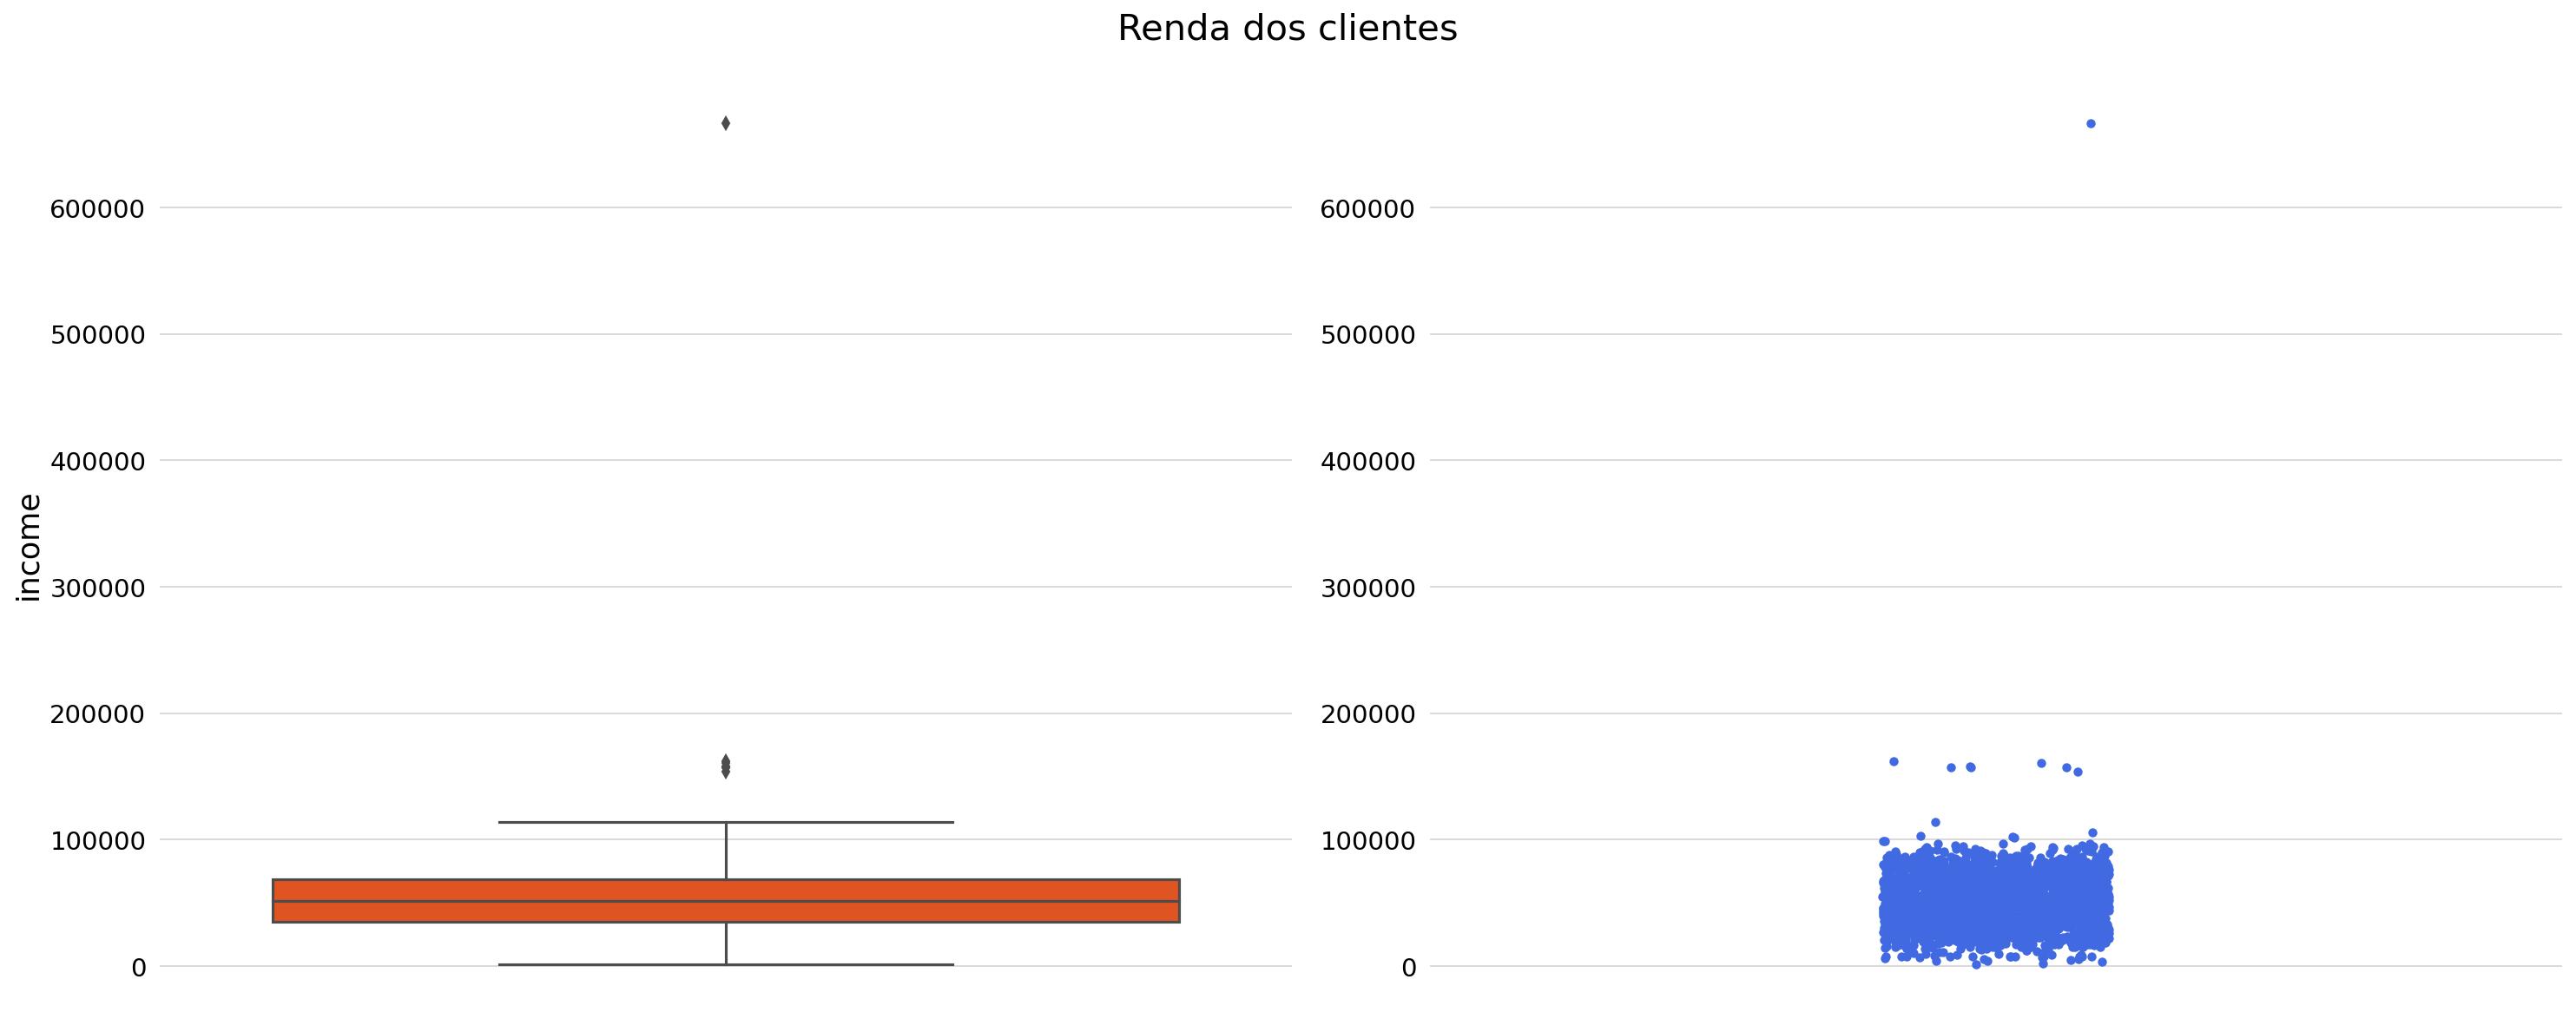

In [14]:
box_strip(df_customer, 'income', 'Renda dos clientes')

In [15]:
# Claramente há uma ocorrência que está "sujando" o conjunto de dados
df_customer[df_customer['income'] > 200000]

id  year_birth   education marital_status    income  kidhome  \
2233  9432        1977  Graduation       Together 666666.00        1   

      teenhome dt_customer  recency  complain  
2233         0  02-06-2013       23         0

In [16]:
# Como se trata de apenas uma ocorrência, ela será removida do conjunto
df_customer = df_customer[df_customer['income'] < 200000]

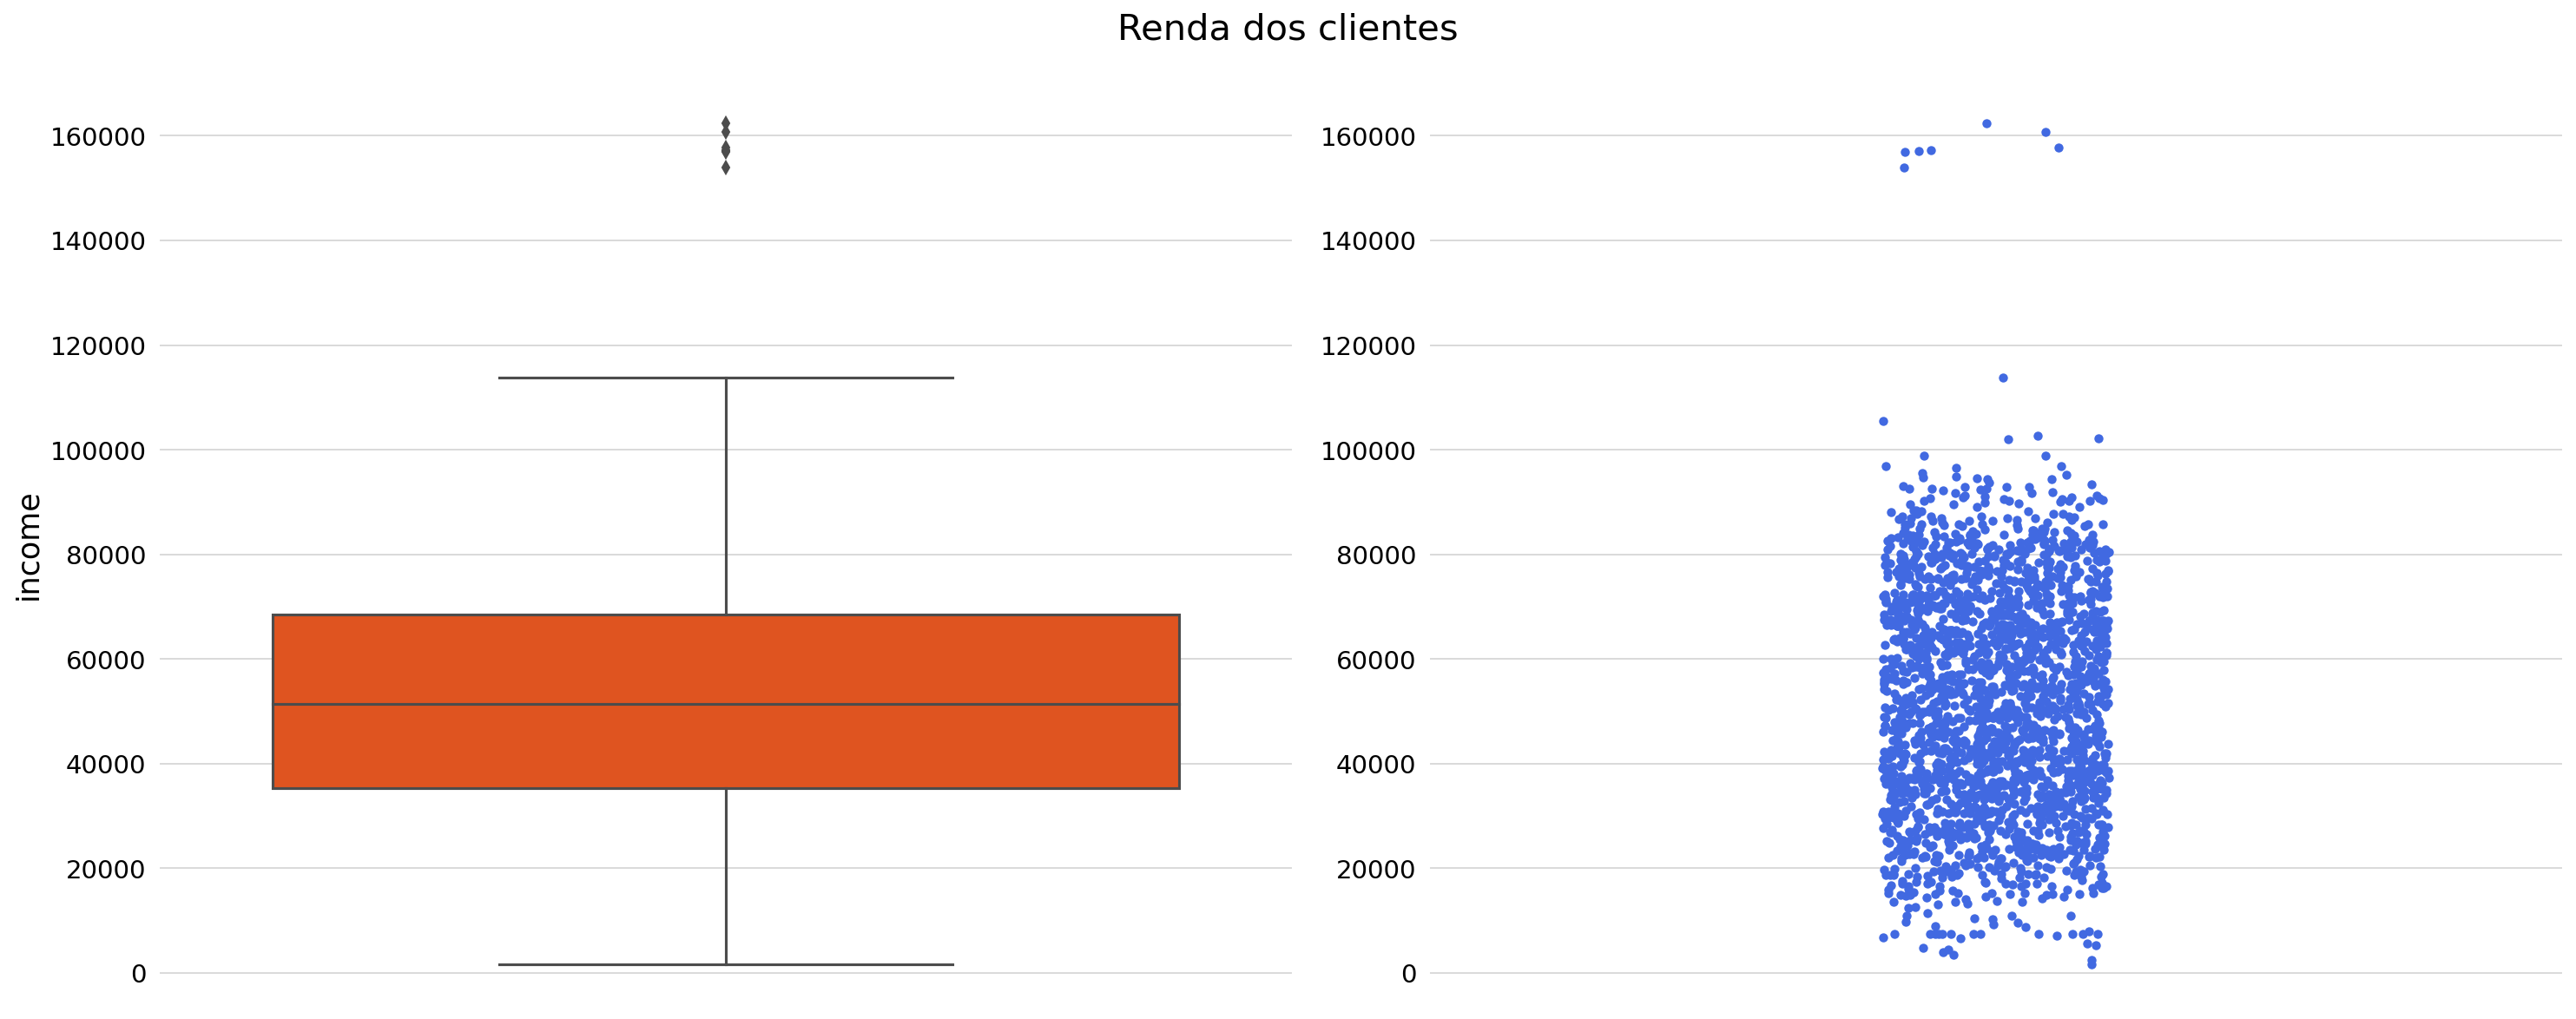

In [17]:
# Plotando os dados agora que estão mais bem comportados
box_strip(df_customer, 'income', 'Renda dos clientes')

##### `year_birth`

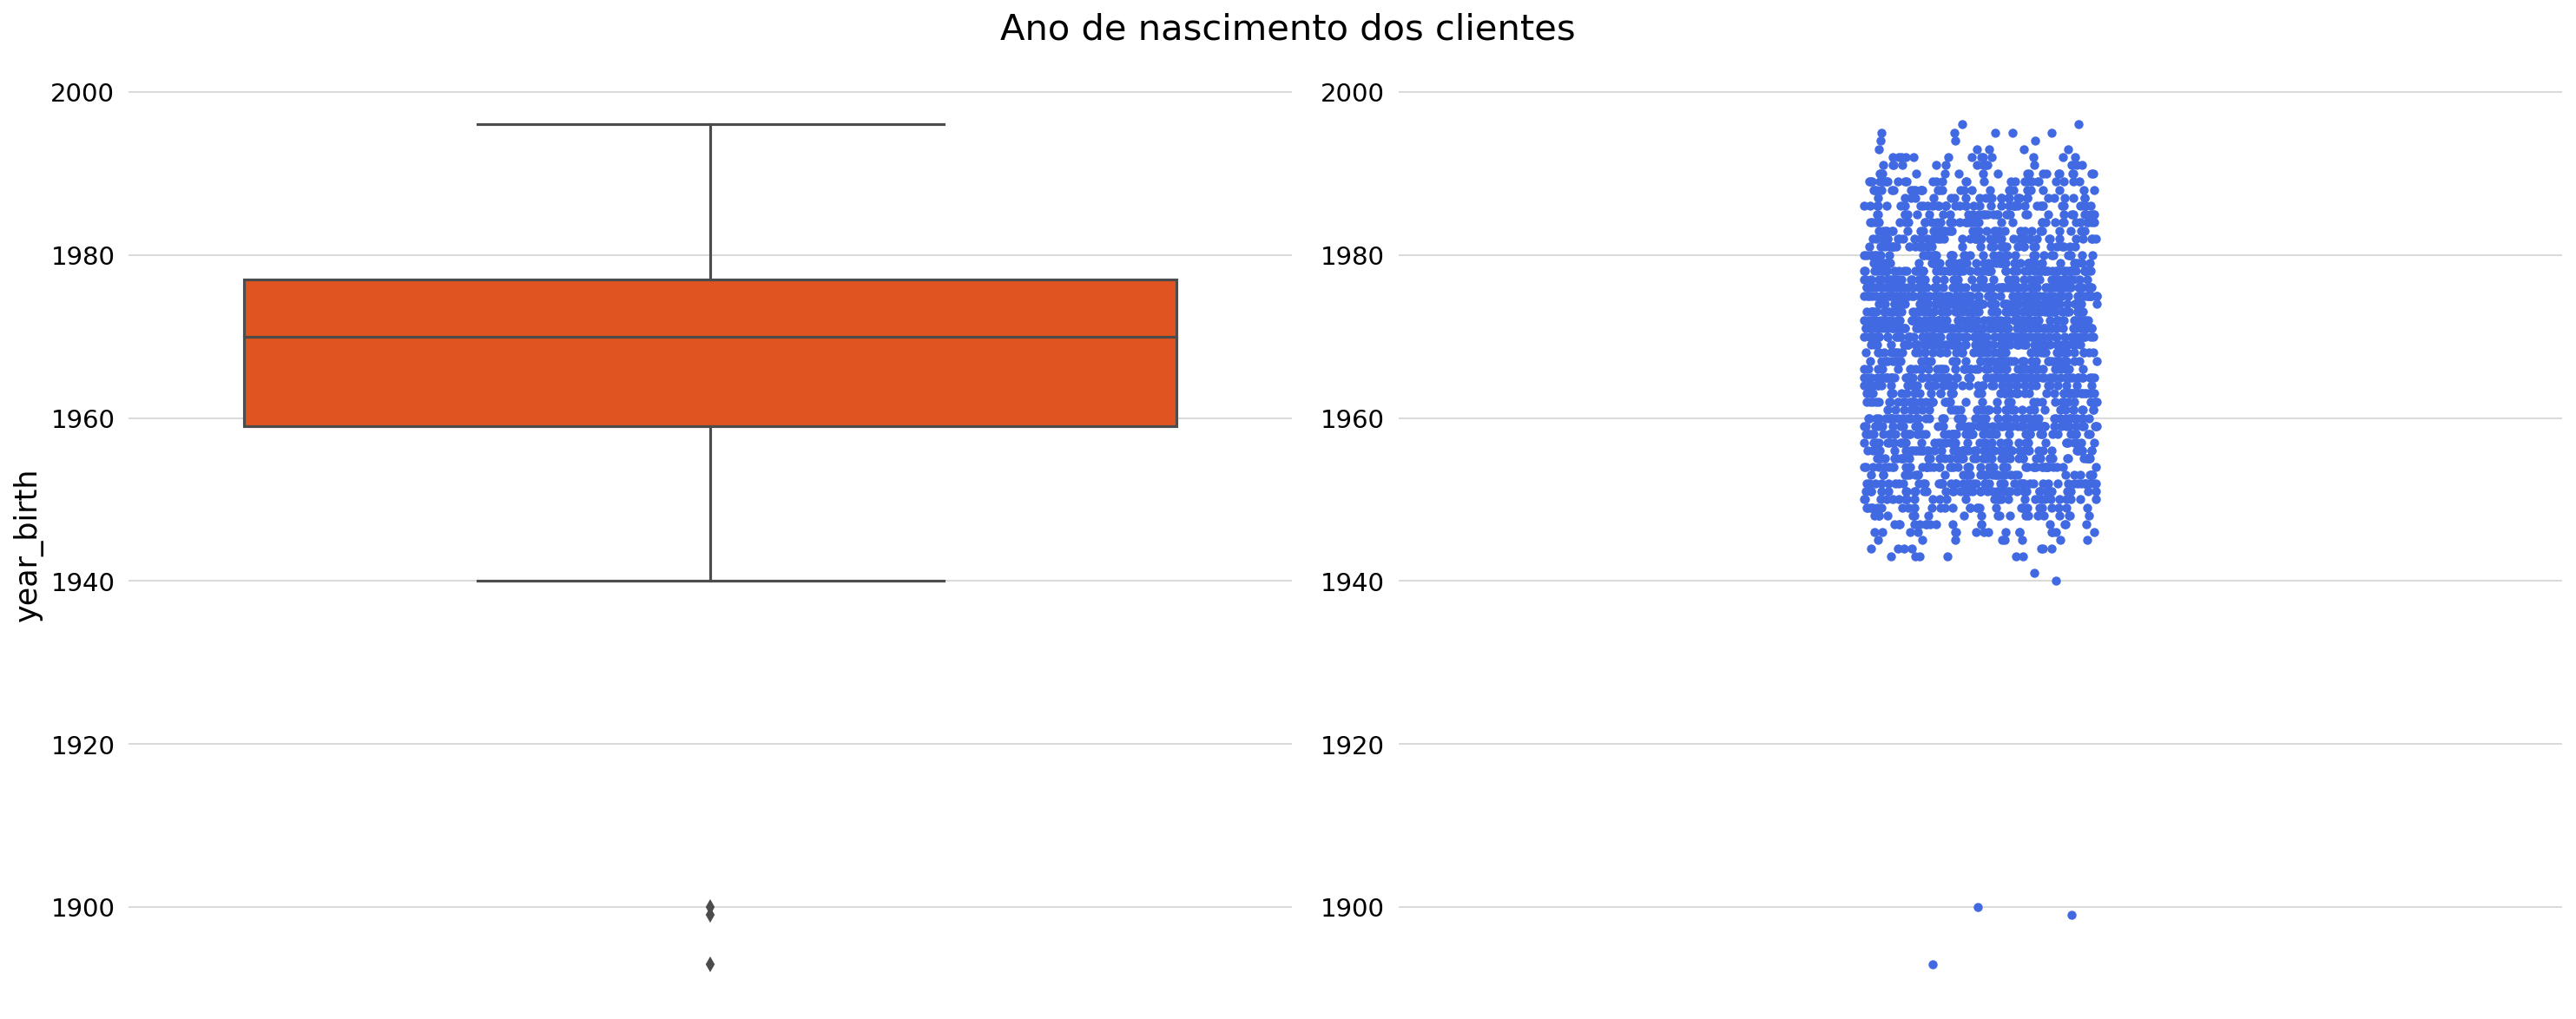

In [18]:
# Visualizando os dados de `year_birth`
box_strip(df_customer, 'year_birth', 'Ano de nascimento dos clientes')

In [19]:
# Explorando quantos clientes nascidos por volta de 1900 existem no dataset
df_customer[df_customer['year_birth'] <= 1900]

id  year_birth education marital_status   income  kidhome  teenhome  \
192   7829        1900  2n Cycle       Divorced 36640.00        1         0   
239  11004        1893  2n Cycle         Single 60182.00        0         1   
339   1150        1899       PhD       Together 83532.00        0         0   

    dt_customer  recency  complain  
192  26-09-2013       99         1  
239  17-05-2014       23         0  
339  26-09-2013       36         0

In [20]:
# Considerando que esses clientes são idosos demais para representarem algo 
# no Dataset, eles serão removidos
df_customer = df_customer[df_customer['year_birth'] > 1900]

# Além disso, trabalharemos com a idade dos clientes no momento ao invés do ano de nascimento
df_customer['age'] = 2014 - df_customer['year_birth']

# A coluna 'year_birth' não é mais necessária
df_customer.drop(columns=['year_birth'], inplace=True)

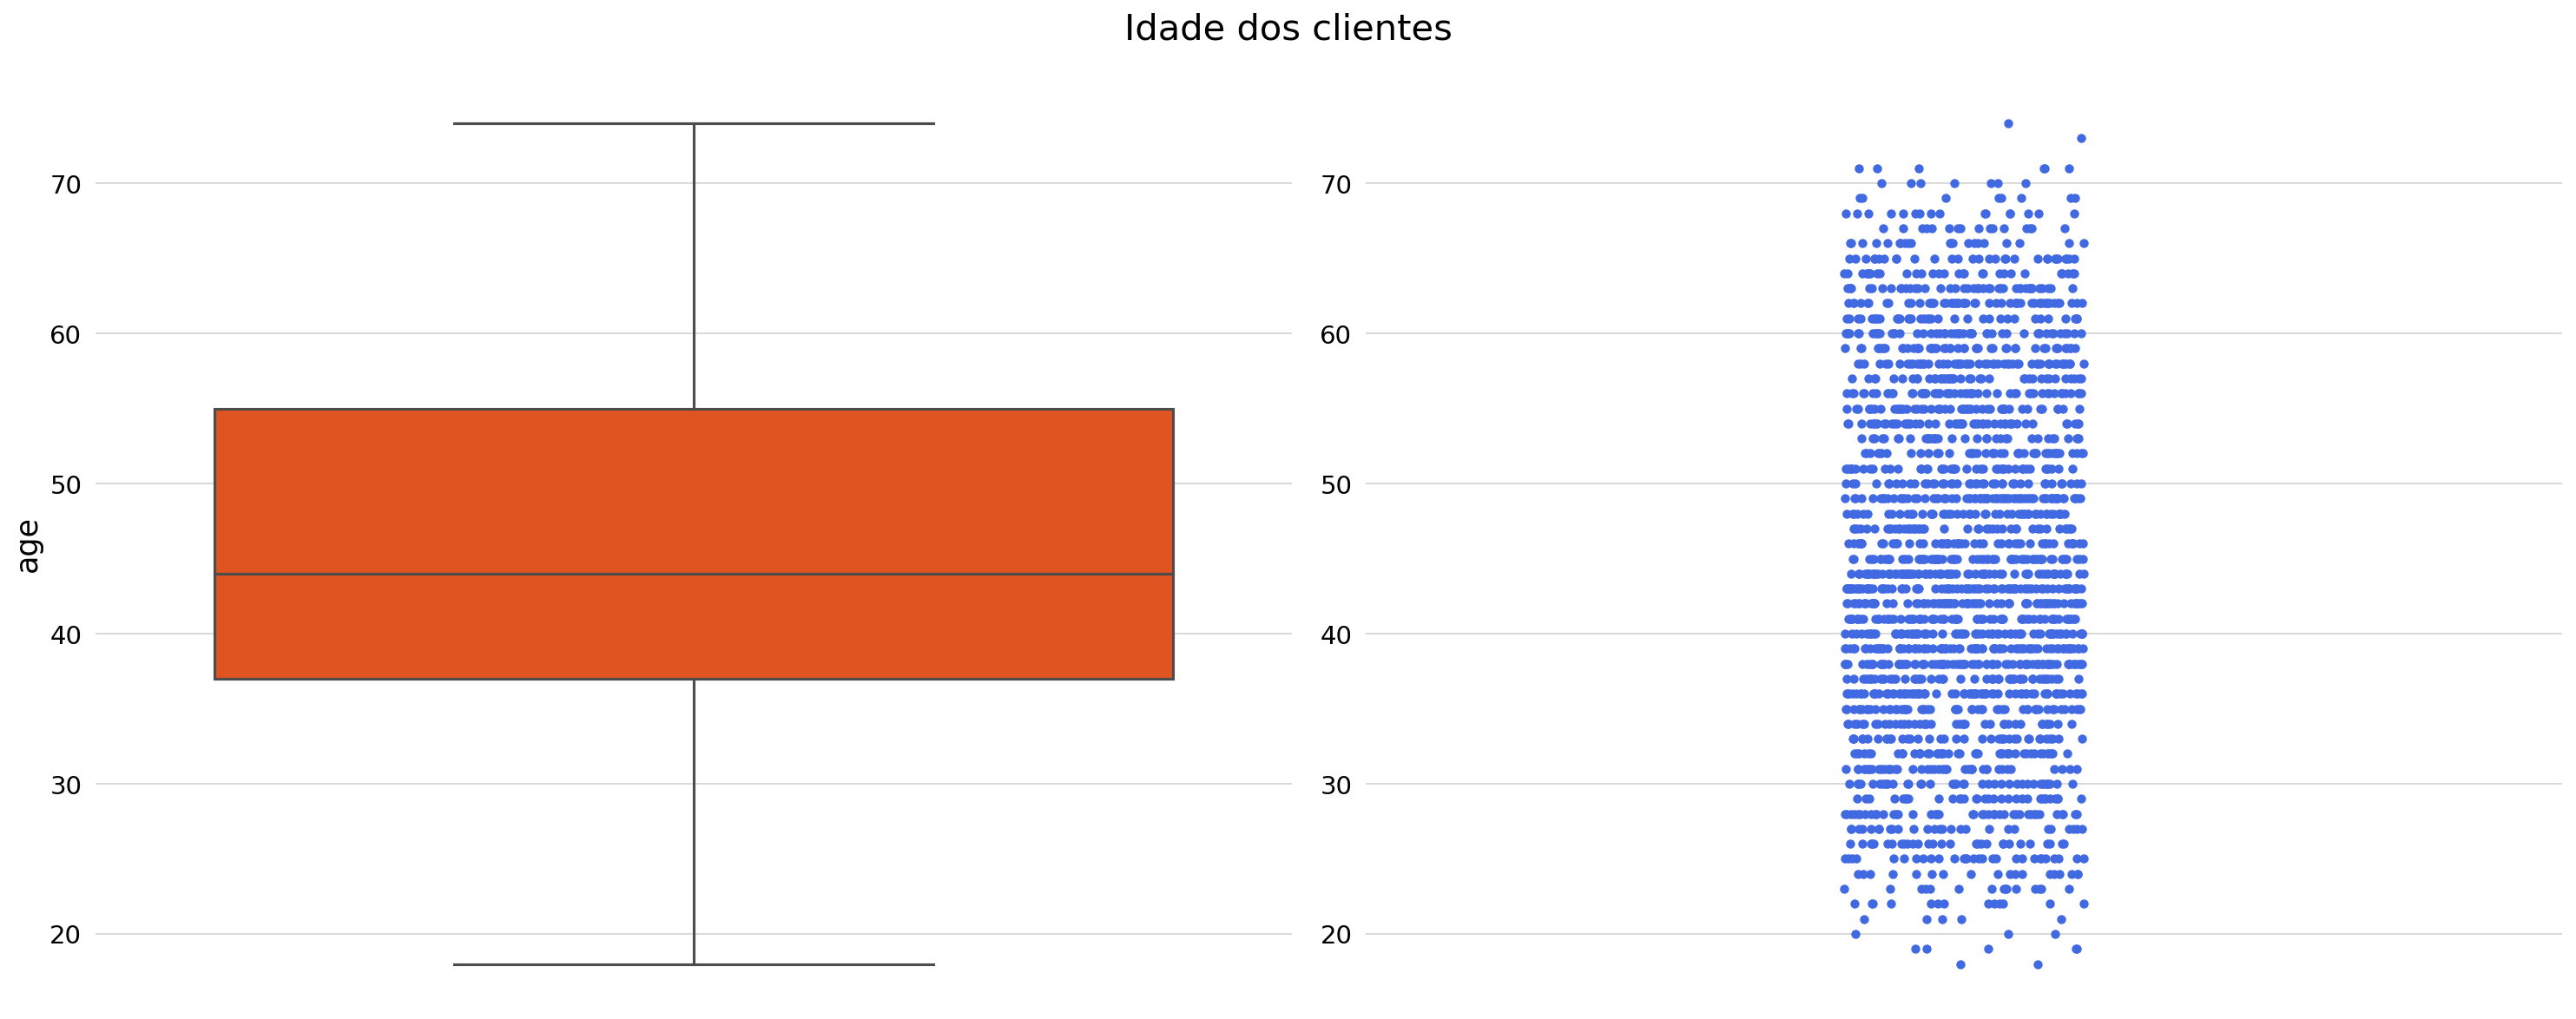

In [21]:
# Visualizando os dados de `year_birth` corrigidos
box_strip(df_customer, 'age', 'Idade dos clientes')

##### `education`

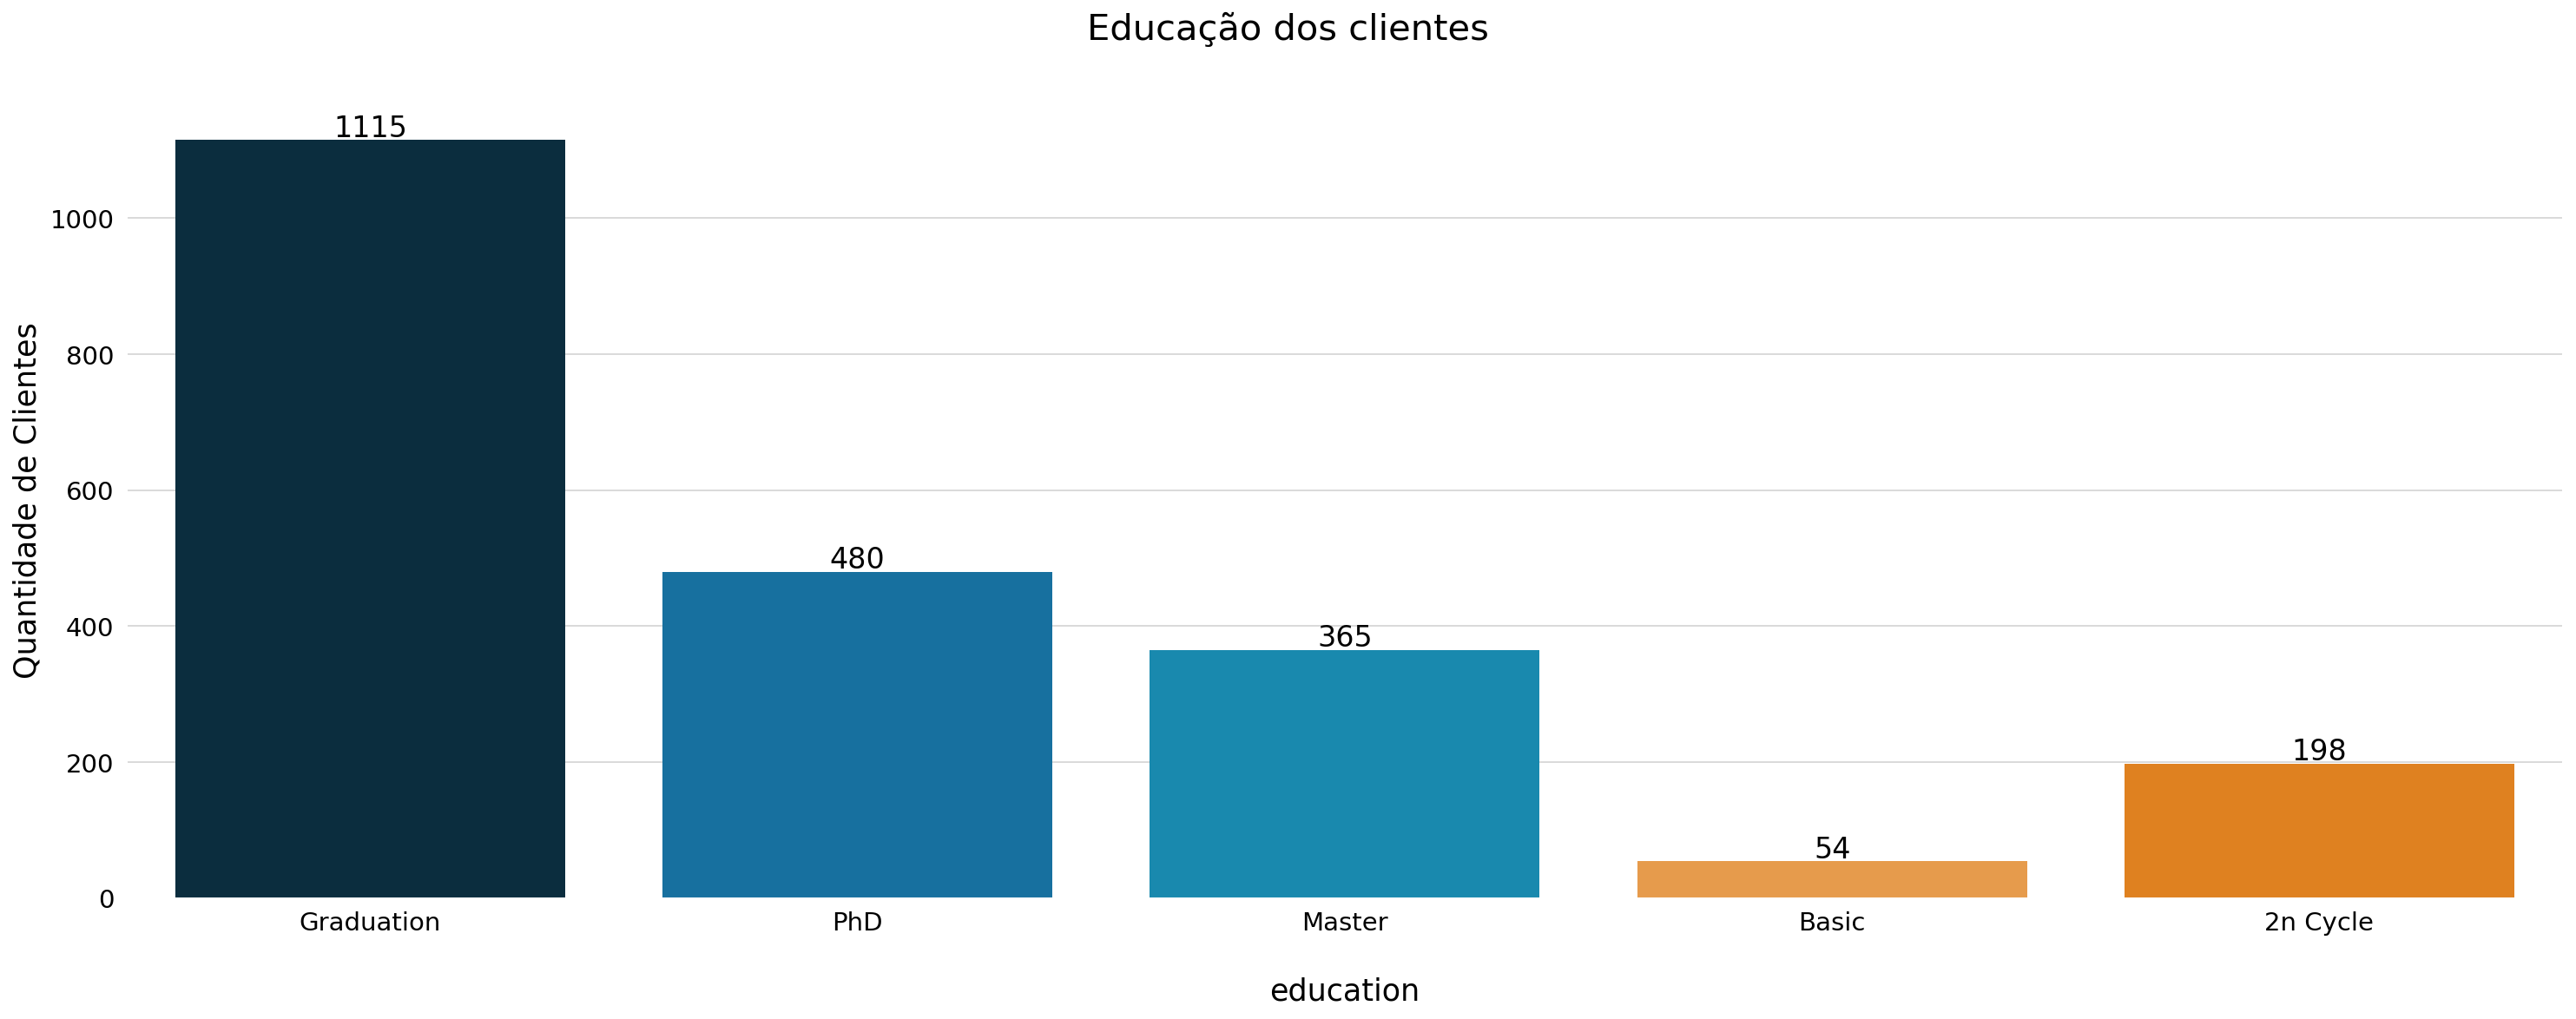

In [22]:
# Visualizando os dados
countplot(df_customer, 'education', 'Educação dos clientes')

In [23]:
# Ordinal Encoding
df_customer['education'] = df_customer['education'].apply(
    lambda x: 0 if x == 'Basic'
    else 1 if x == '2n Cycle'
    else 2 if x == 'Graduation'
    else 3 if x == 'Master'
    else 4 
)

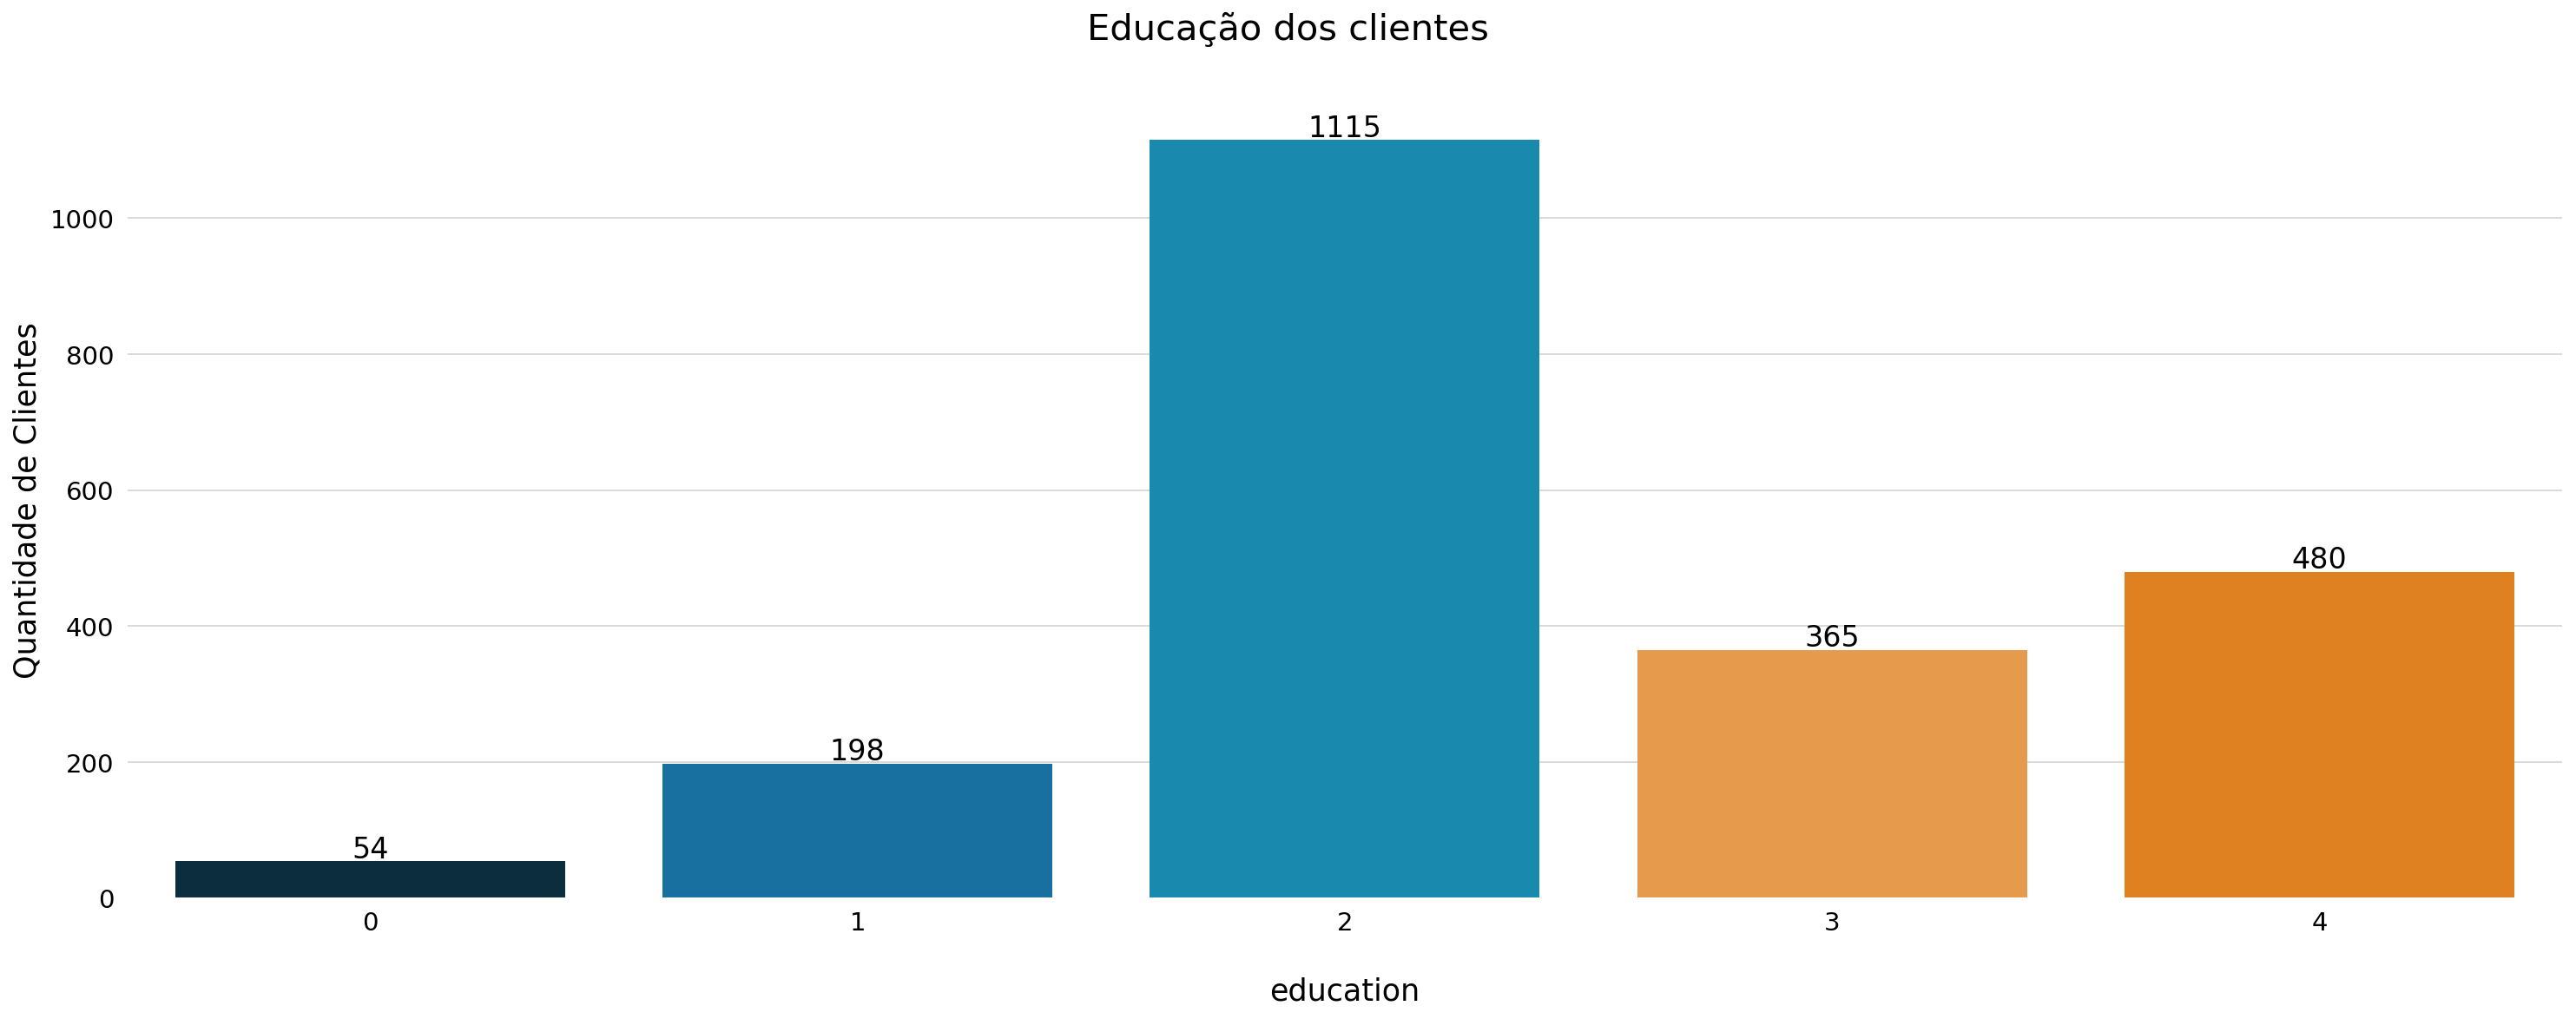

In [24]:
# Visualizando os dados codificados
countplot(df_customer, 'education', 'Educação dos clientes')

##### `marital_status`

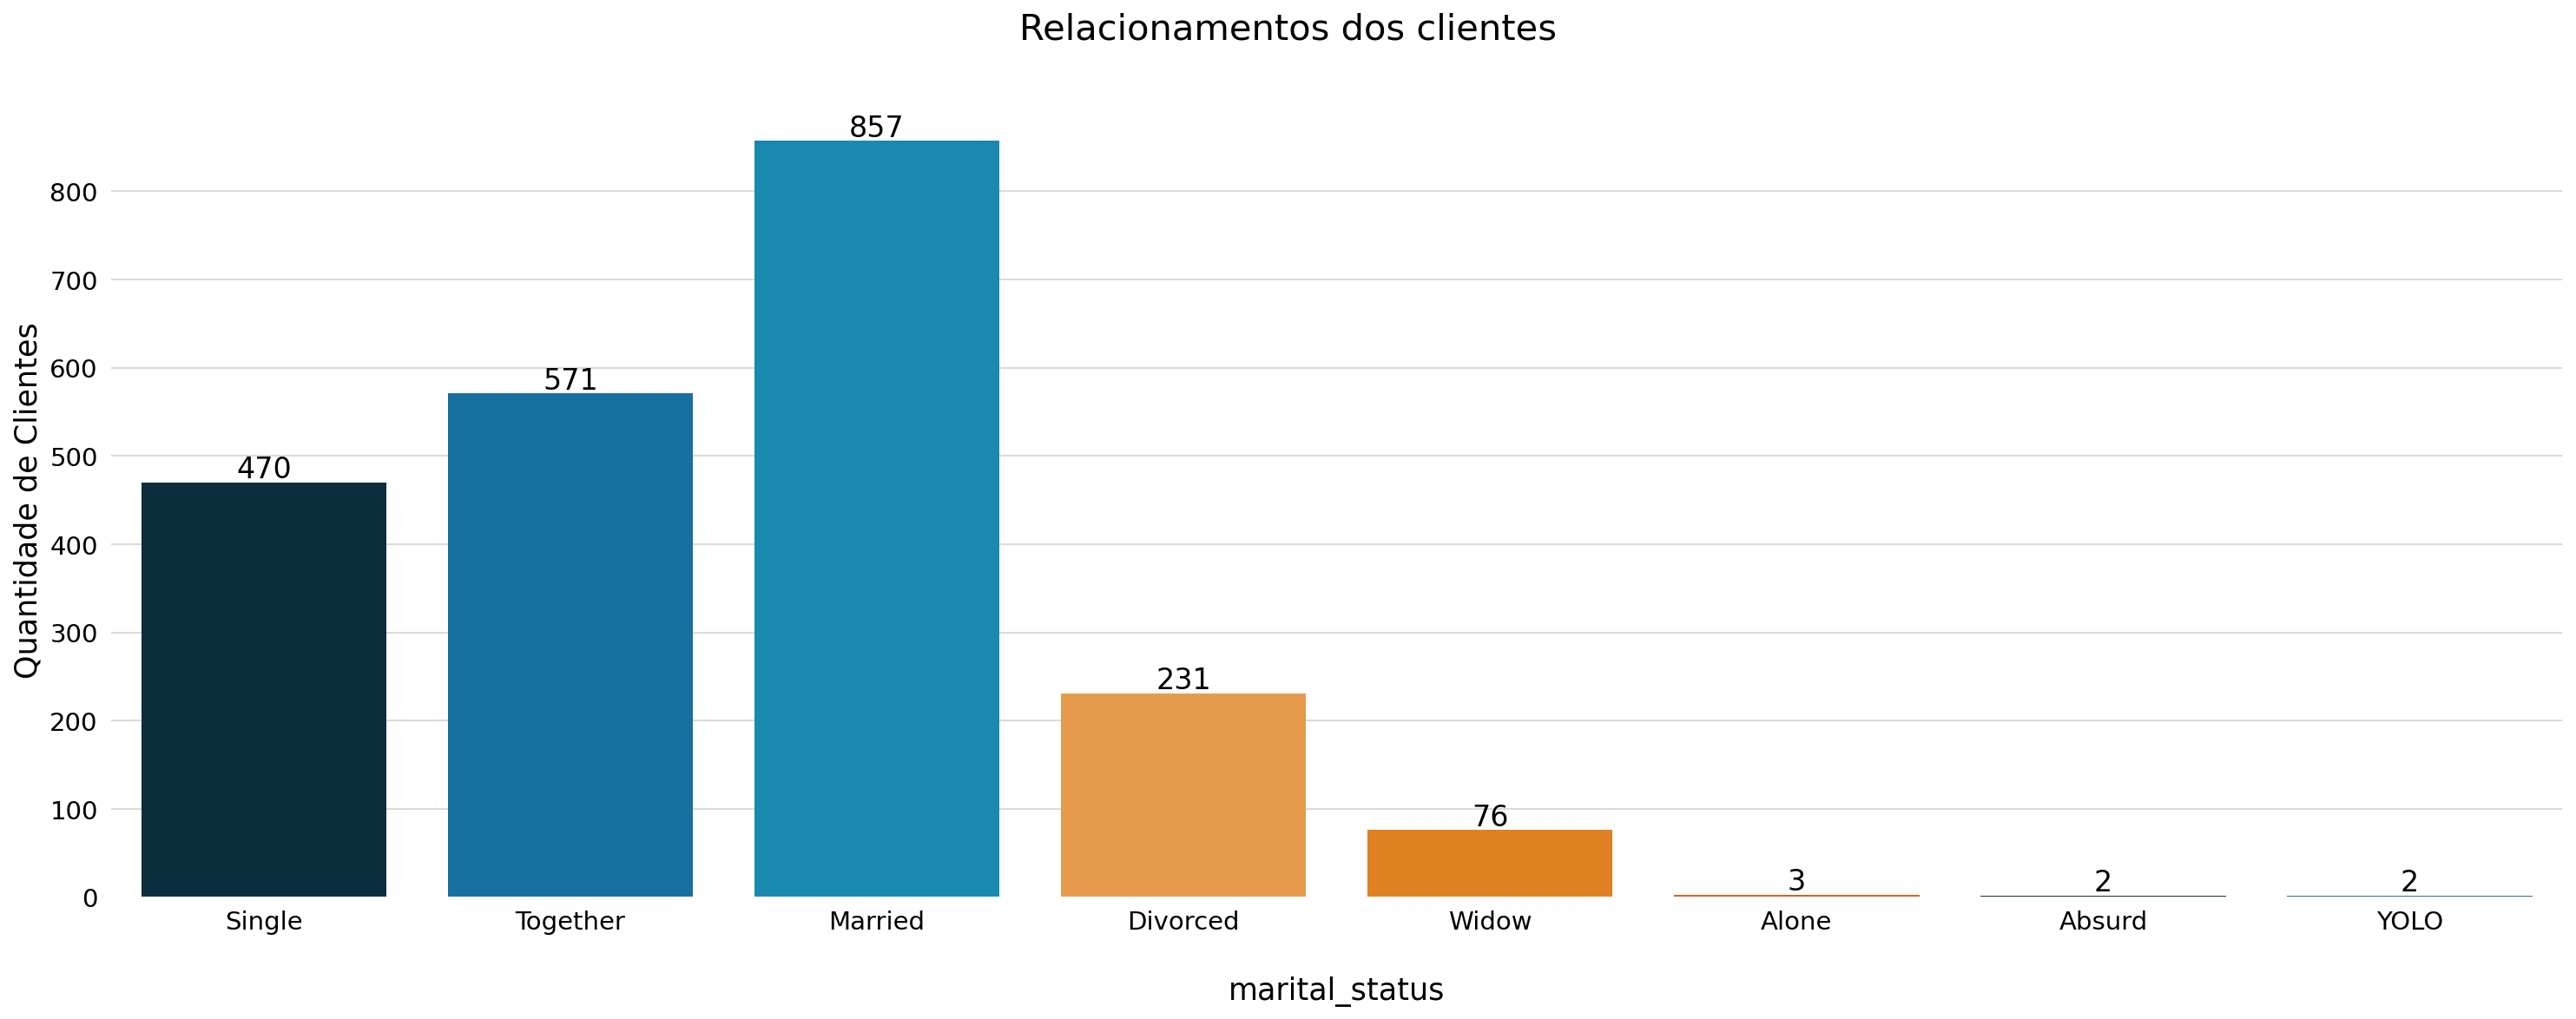

In [25]:
countplot(df_customer, 'marital_status', 'Relacionamentos dos clientes')

In [26]:
# Correções:
# Clientes identificados como 'Absurd' serão dropados da base de dados
df_customer = df_customer[df_customer['marital_status'] != 'Absurd']

# Clientes identificados como 'Alone' e 'YOLO' serão categorizados como solteiros
df_customer['marital_status'] = df_customer['marital_status'].apply(
    lambda x: 'Single' if x == 'Alone'
    else 'Single' if x == 'YOLO'
    else x)

# Além disso, clientes 'Married' serão categorizados como 'Together'
df_customer['marital_status'] = df_customer['marital_status'].apply(
    lambda x: 'Together' if x == 'Married'
    else x)

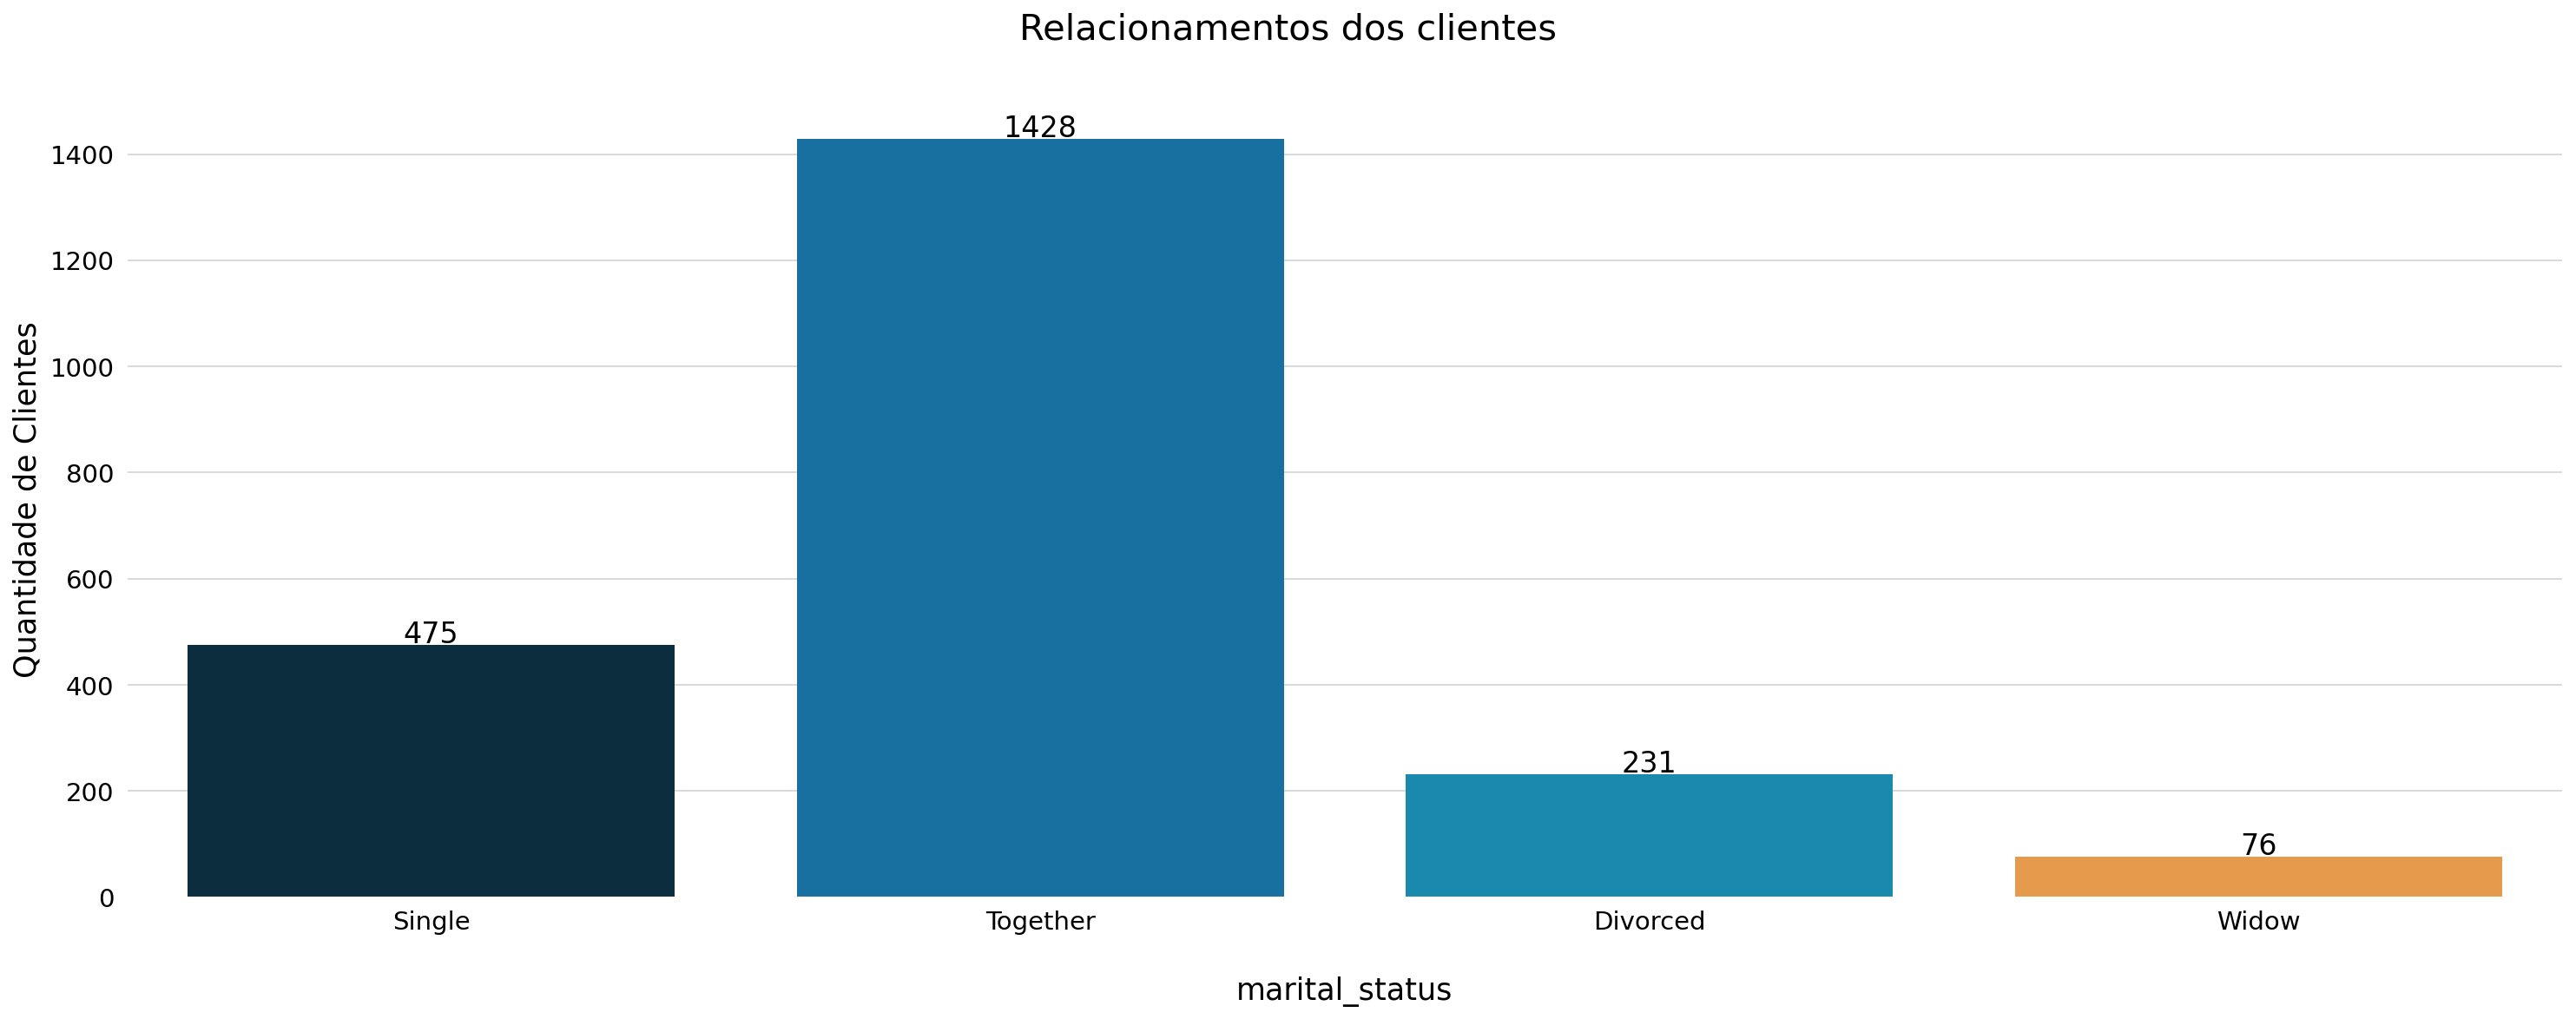

In [27]:
# Visualizando relacionamento dos clientes corrigidos
countplot(df_customer, 'marital_status', 'Relacionamentos dos clientes')

In [28]:
# Modificando o nome da coluna 'marital_status' para 'ms' 
df_customer = df_customer.rename(
    columns={'marital_status': 'ms'})

# Transformando a coluna 'ms' em múltiplas colunas
dummies = pd.get_dummies(df_customer['ms'])

# Juntando os datasets
df_customer = pd.concat(
    [df_customer, dummies], axis=1)

# A coluna 'ms' não é mais necessária
df_customer.drop(columns=['ms'], inplace=True)

# Transformando as colunas em snake_case
columns_to_snake_case(df_customer)

##### `kidhome`

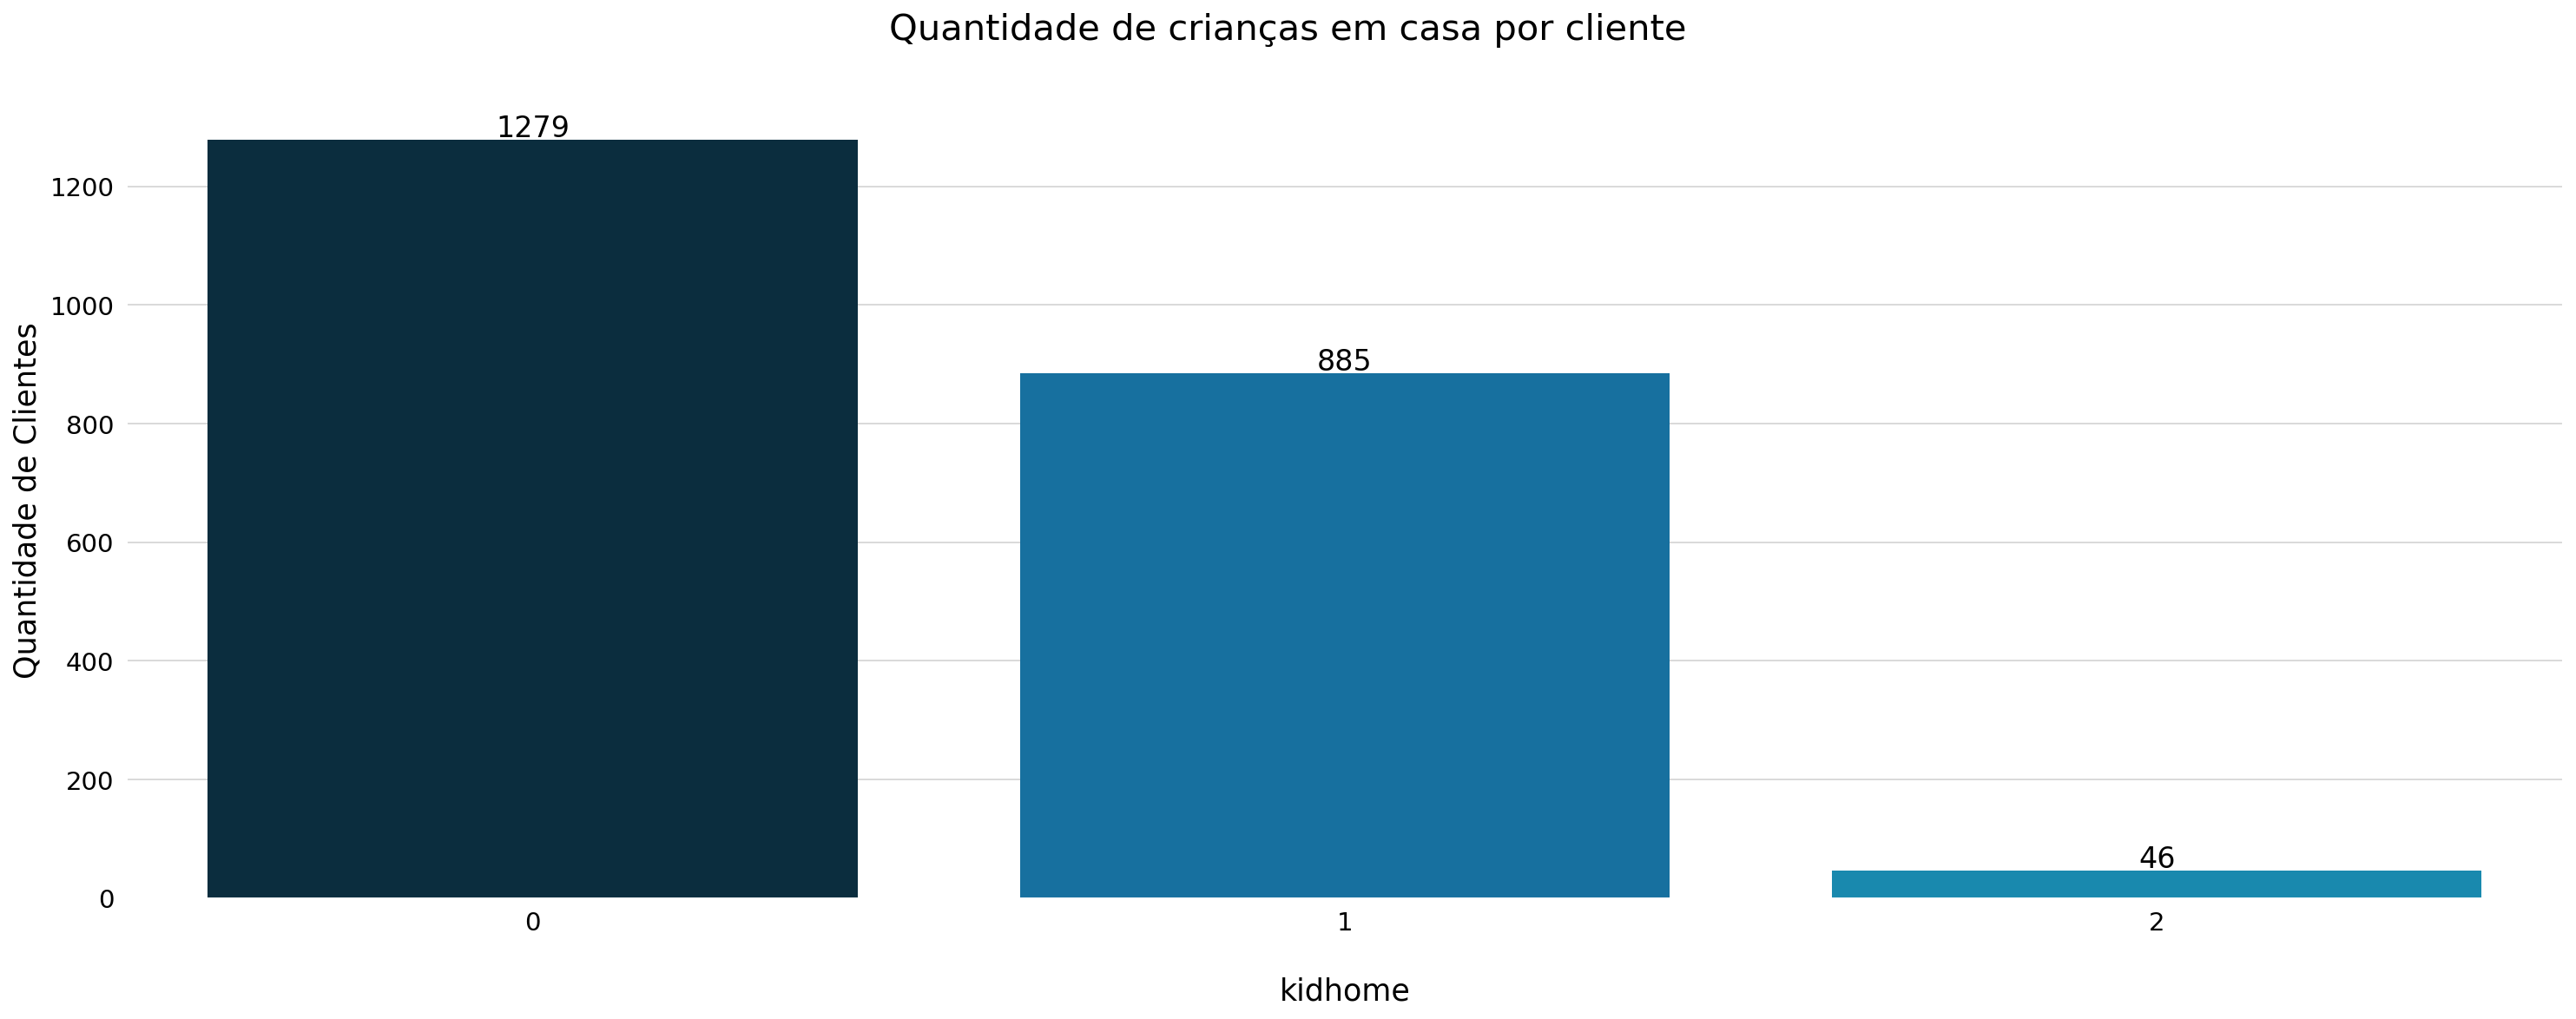

In [29]:
# Visualizando a quantidade de crianças que clientes têm em casa
countplot(df_customer, 'kidhome', 'Quantidade de crianças em casa por cliente')

##### `teenhome`

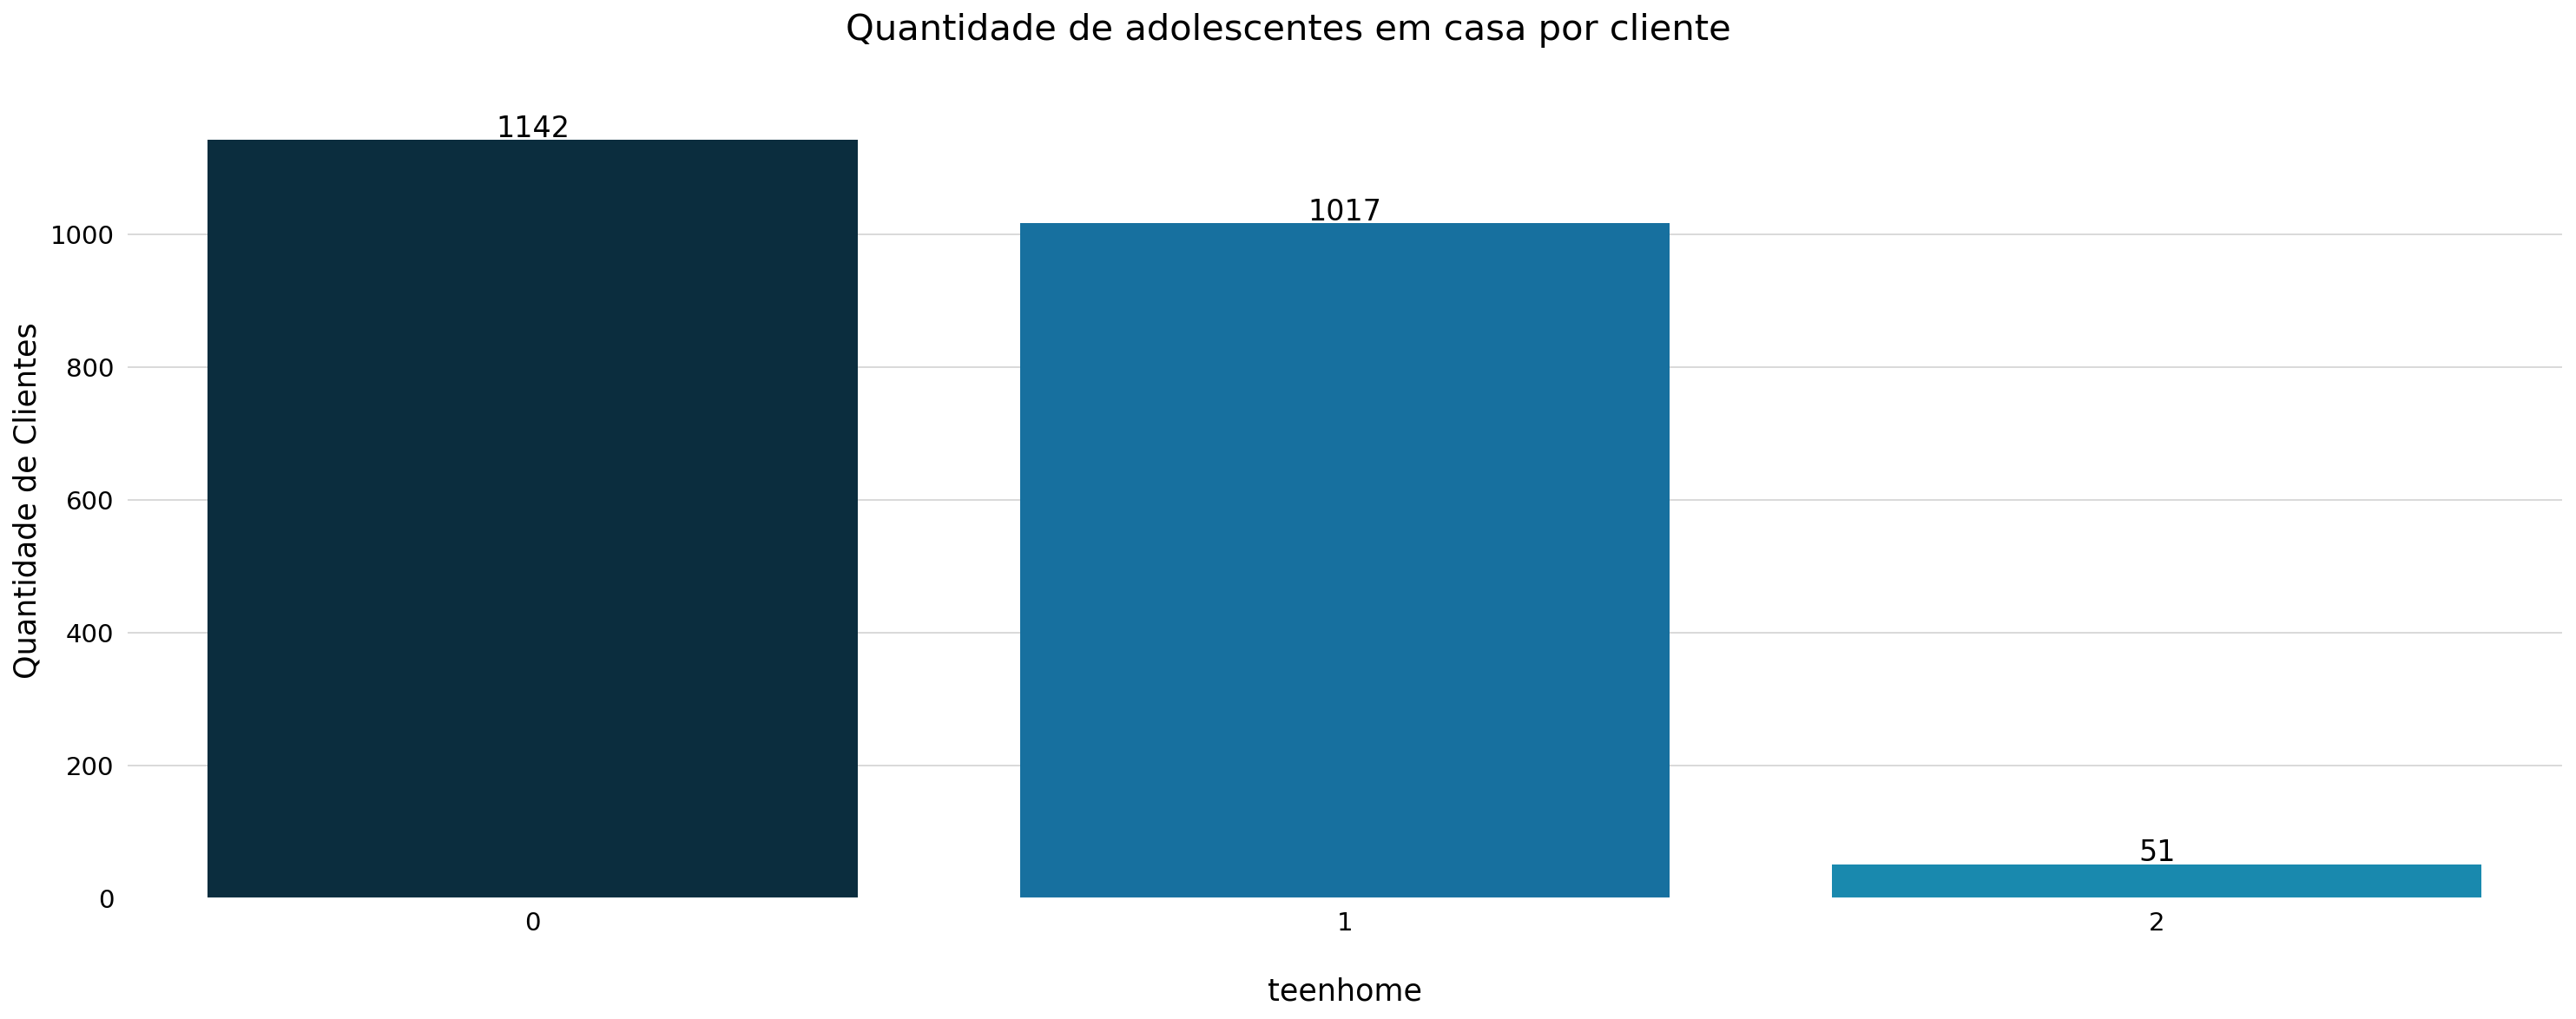

In [30]:
# Visualizando a quantidade de adolescentes que clientes têm em casa
countplot(df_customer, 'teenhome', 'Quantidade de adolescentes em casa por cliente')

##### `children_home`

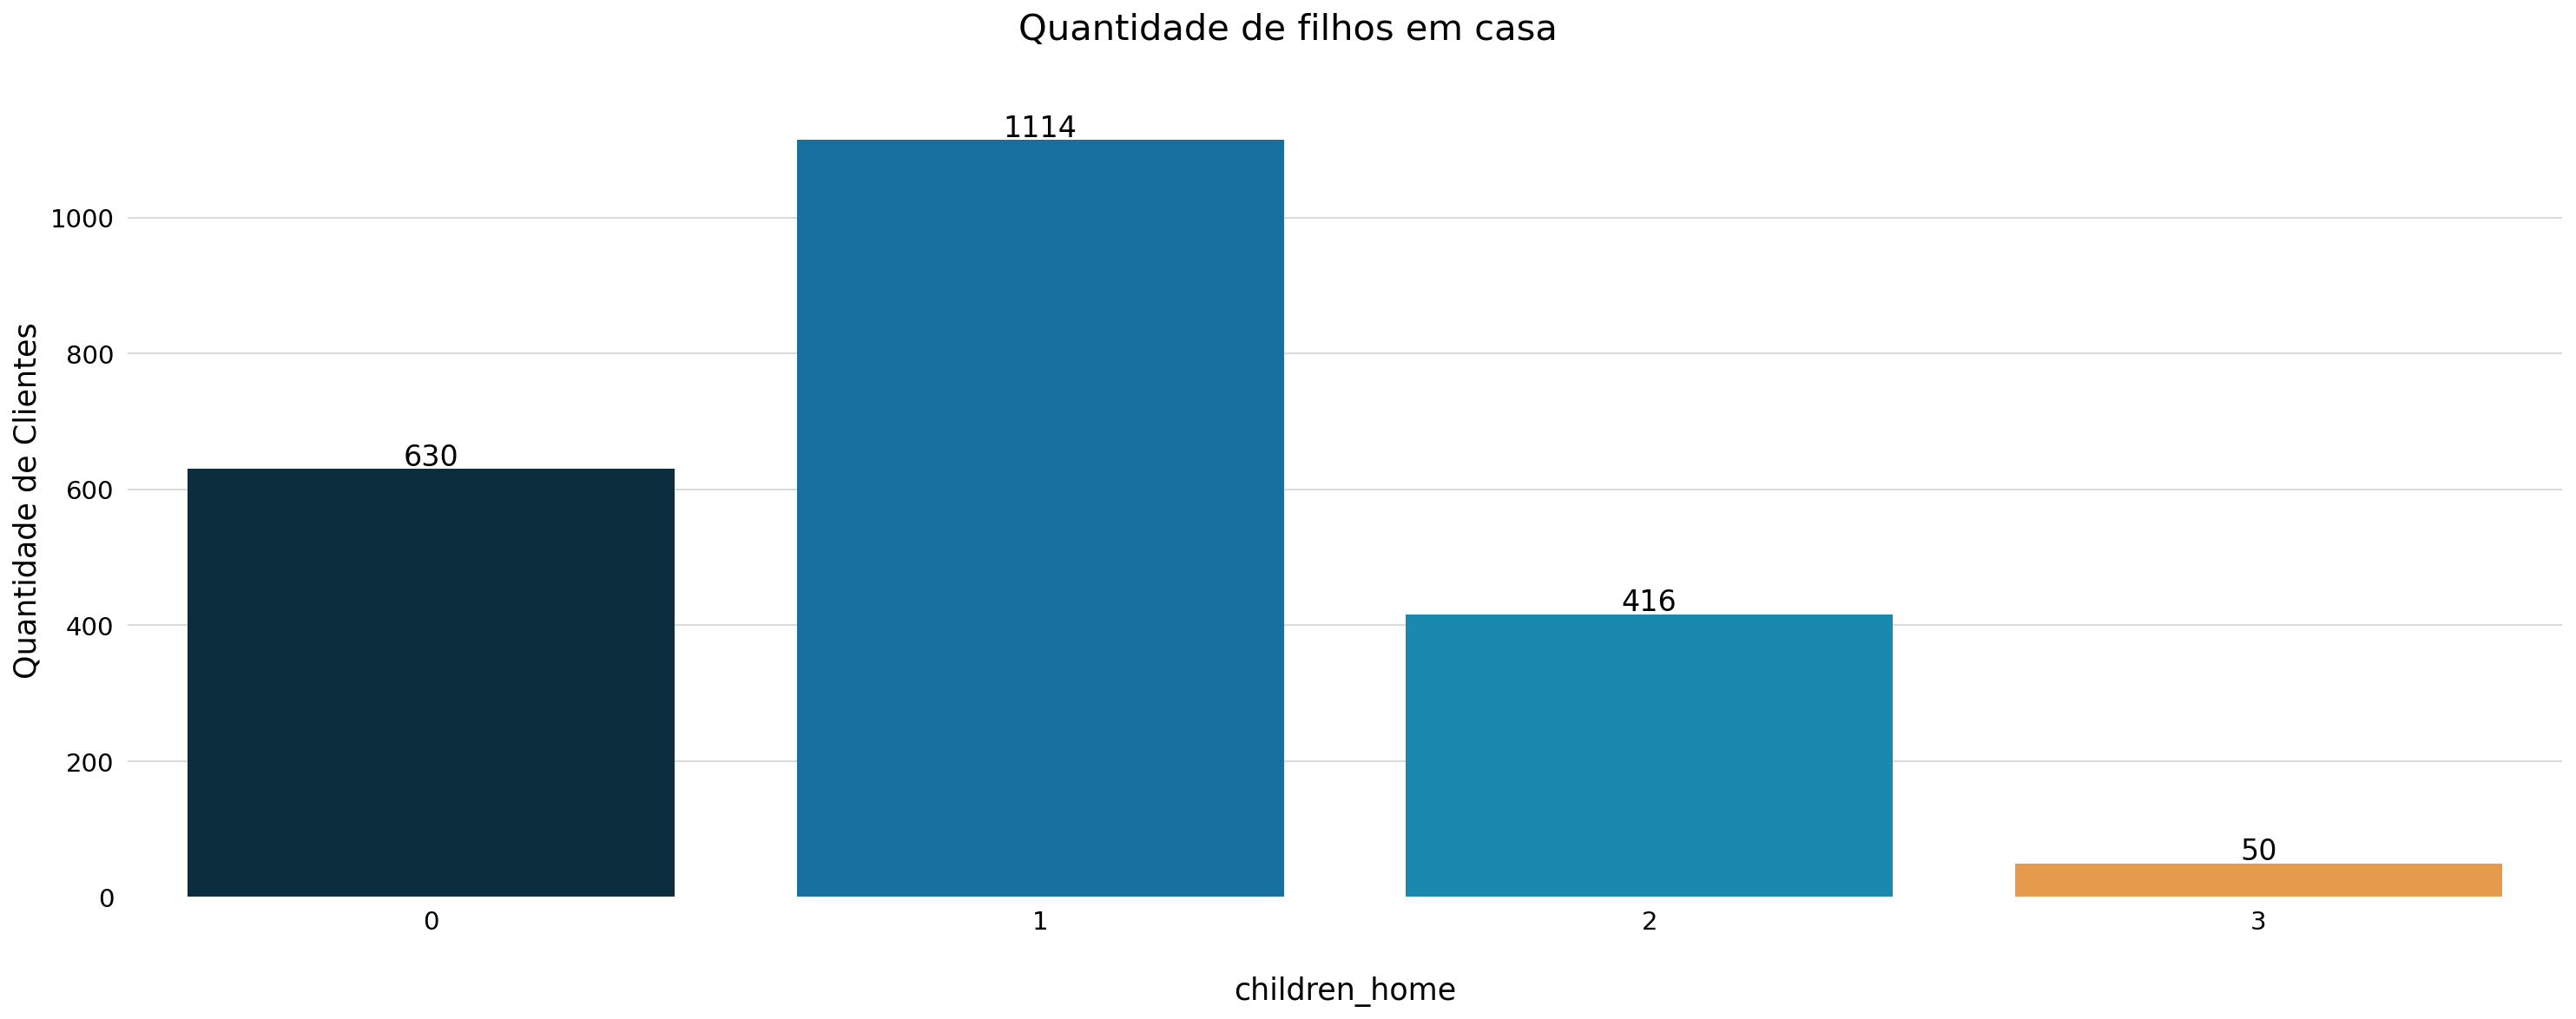

In [31]:
# Transformando as colunas 'kidhome' e 'teenhome' em 'children_home' ao somar o número de filhos
df_customer['children_home'] = df_customer['kidhome'] + df_customer['teenhome']

# Visualizando o resultado de filhos
countplot(df_customer, 'children_home', 'Quantidade de filhos em casa')

In [32]:
# As colunas anteriores não são mais necessárias de agora em diante
df_customer.drop(columns=['kidhome', 'teenhome'], inplace=True)

##### `recency`

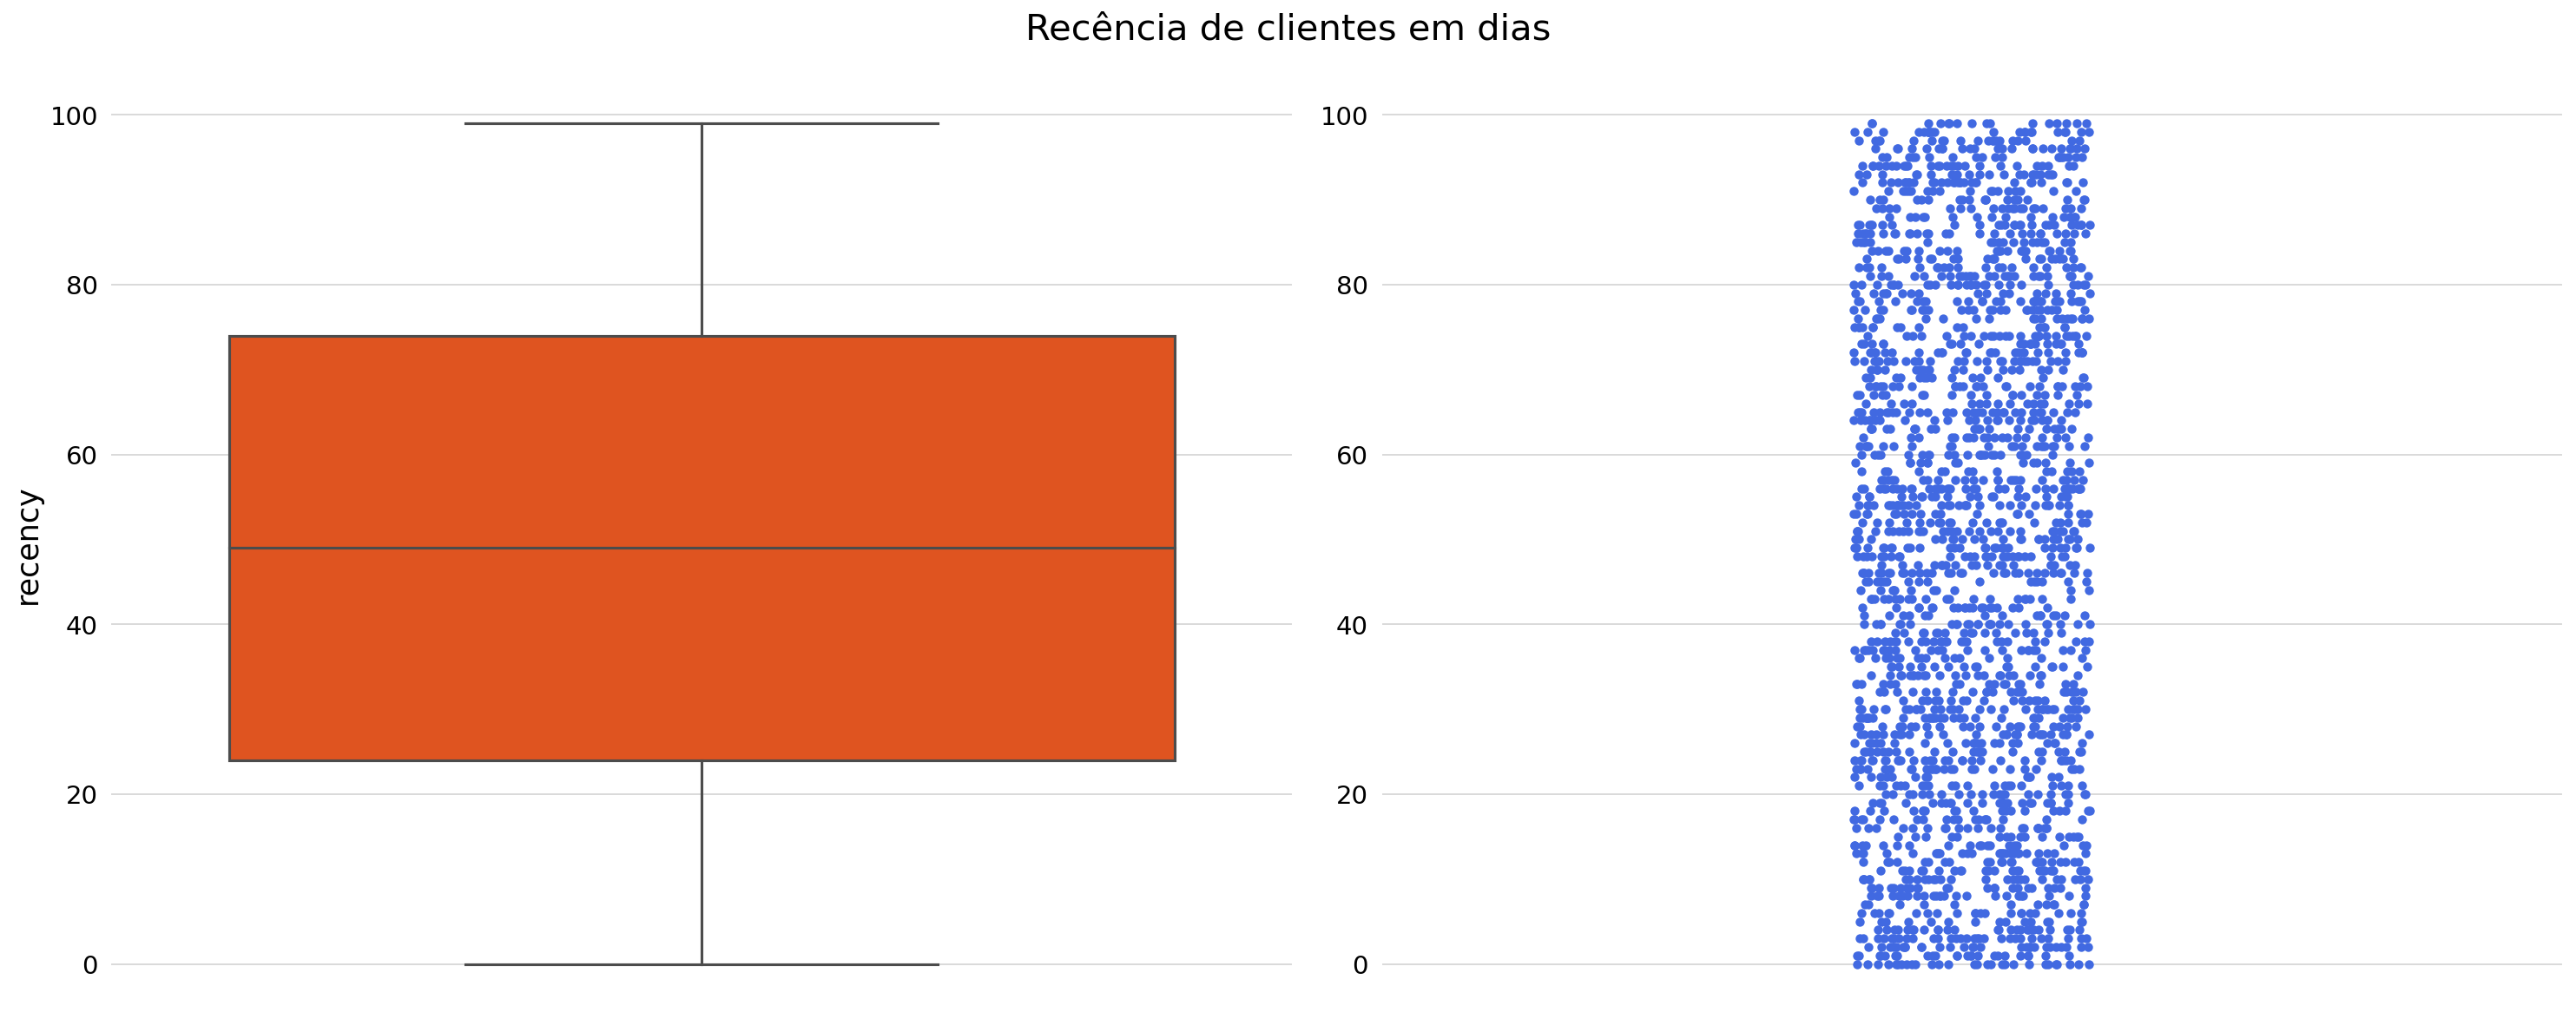

In [33]:
box_strip(df_customer, 'recency', 'Recência de clientes em dias')

##### `dt_customer`

In [34]:
# Transformando os dados de cadastro em datetime
df_customer['dt_customer'] = pd.to_datetime(df_customer['dt_customer'], dayfirst=True)

# Visualizando informações
print('Dia mais antigo de cadastro: {}'.format(df_customer['dt_customer'].min()))
print('Dia mais recente de cadastro: {}'.format(df_customer['dt_customer'].max()))

Dia mais antigo de cadastro: 2012-07-30 00:00:00
Dia mais recente de cadastro: 2014-06-29 00:00:00


In [35]:
# Somando datas de cadastro e recência, temos o último dia de compra feita
(df_customer['dt_customer'] + pd.to_timedelta(df_customer['recency'], unit='d')).max()

Timestamp('2014-10-04 00:00:00')

In [36]:
# Criando a coluna 'lifetime' sobre os clientes em meses
df_customer['lifetime'] = ((pd.to_datetime('2014-10-05') - df_customer['dt_customer']).dt.days)/30

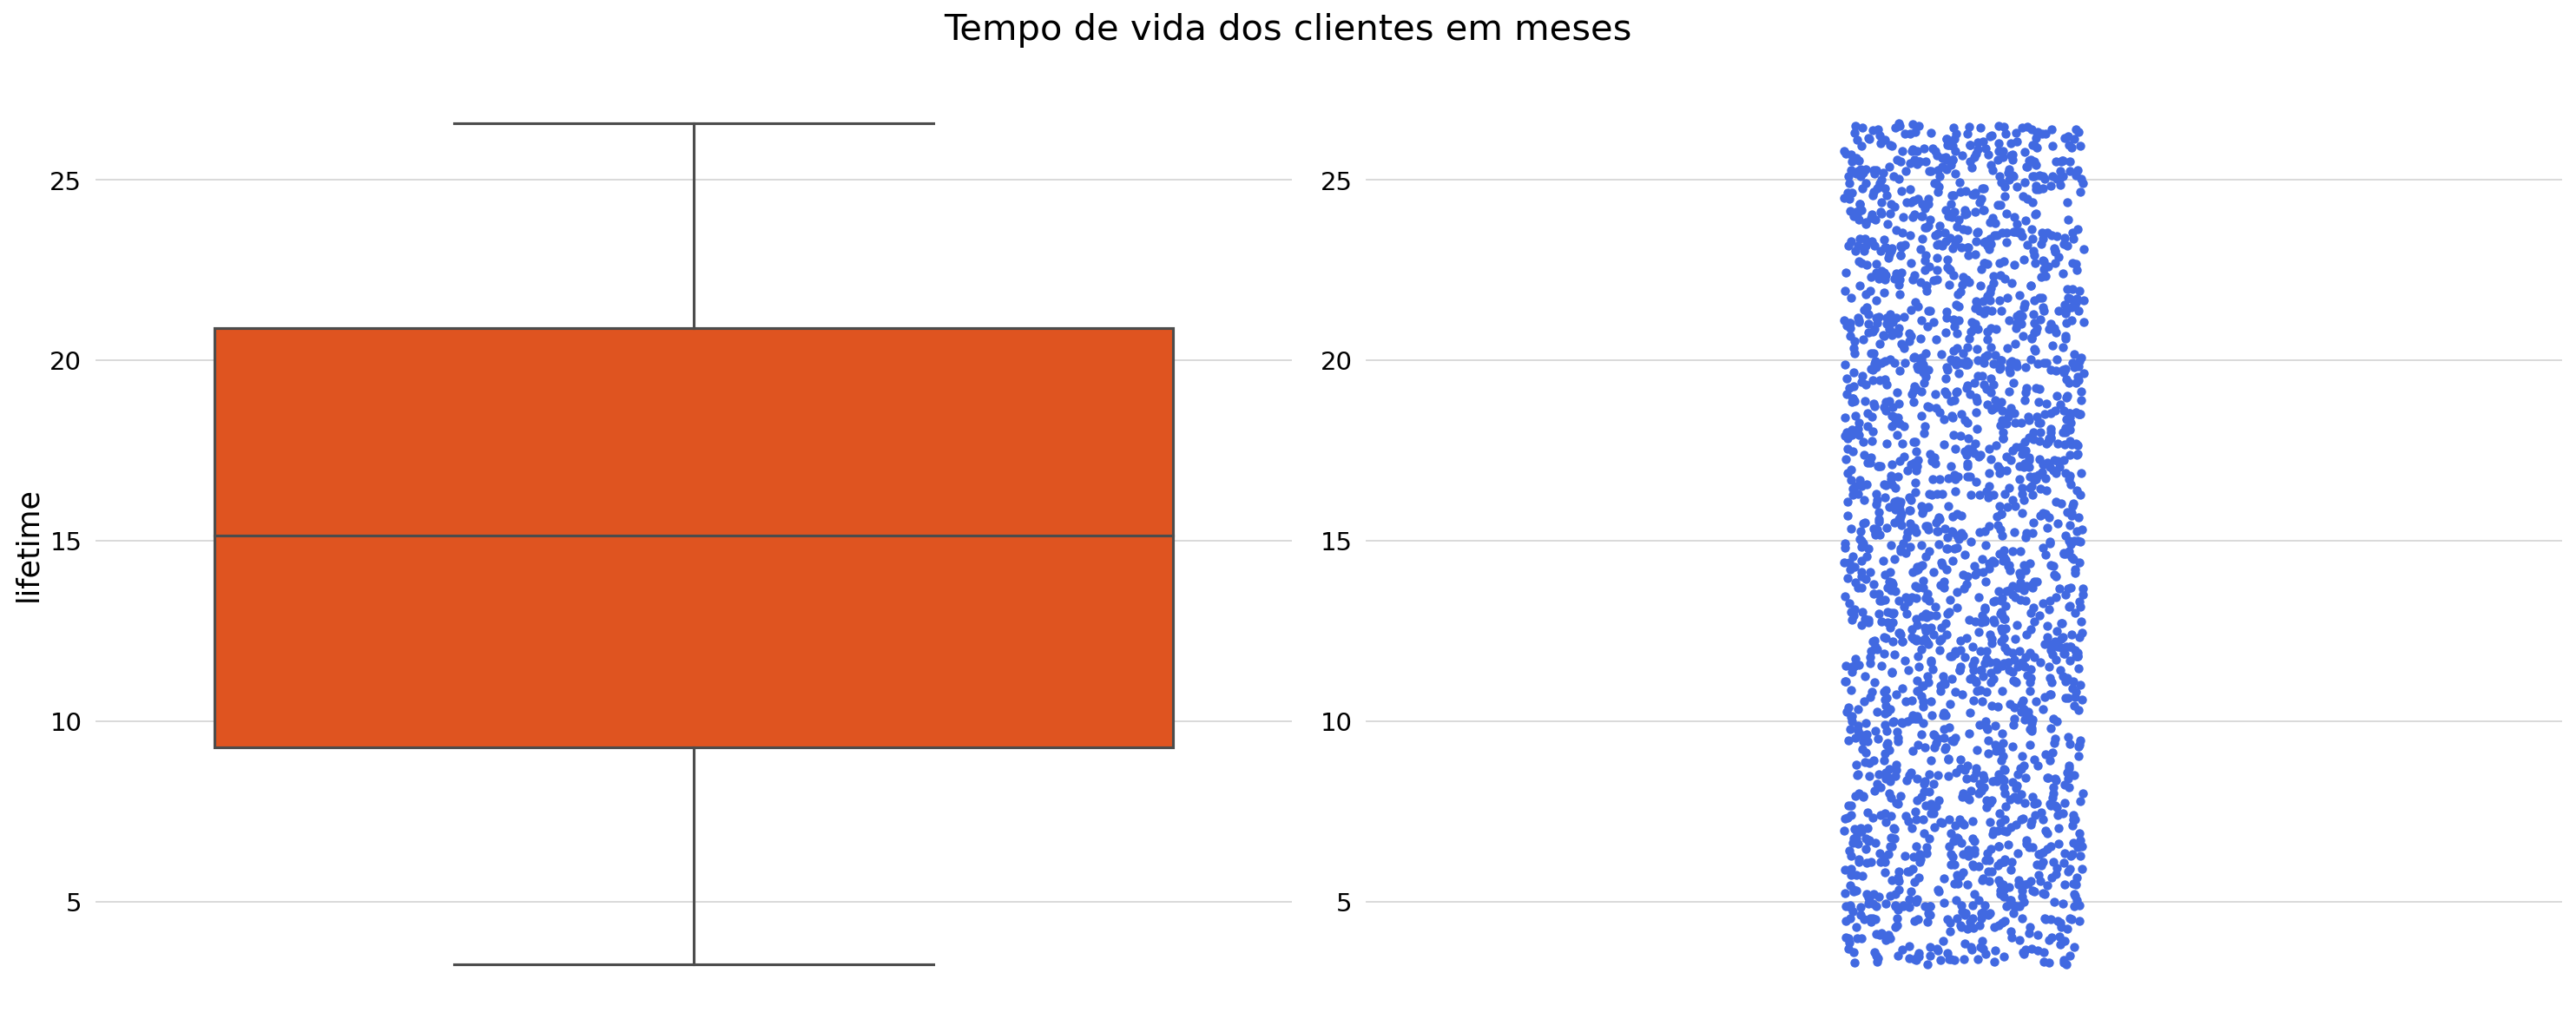

In [37]:
# Visualizando o tempo de vida dos clientes 
box_strip(df_customer, 'lifetime', 'Tempo de vida dos clientes em meses')

In [38]:
# A coluna datetime 'dt_customer' não é mais necessária para o dataset
df_customer.drop(columns=['dt_customer'], inplace=True)

##### `complain`

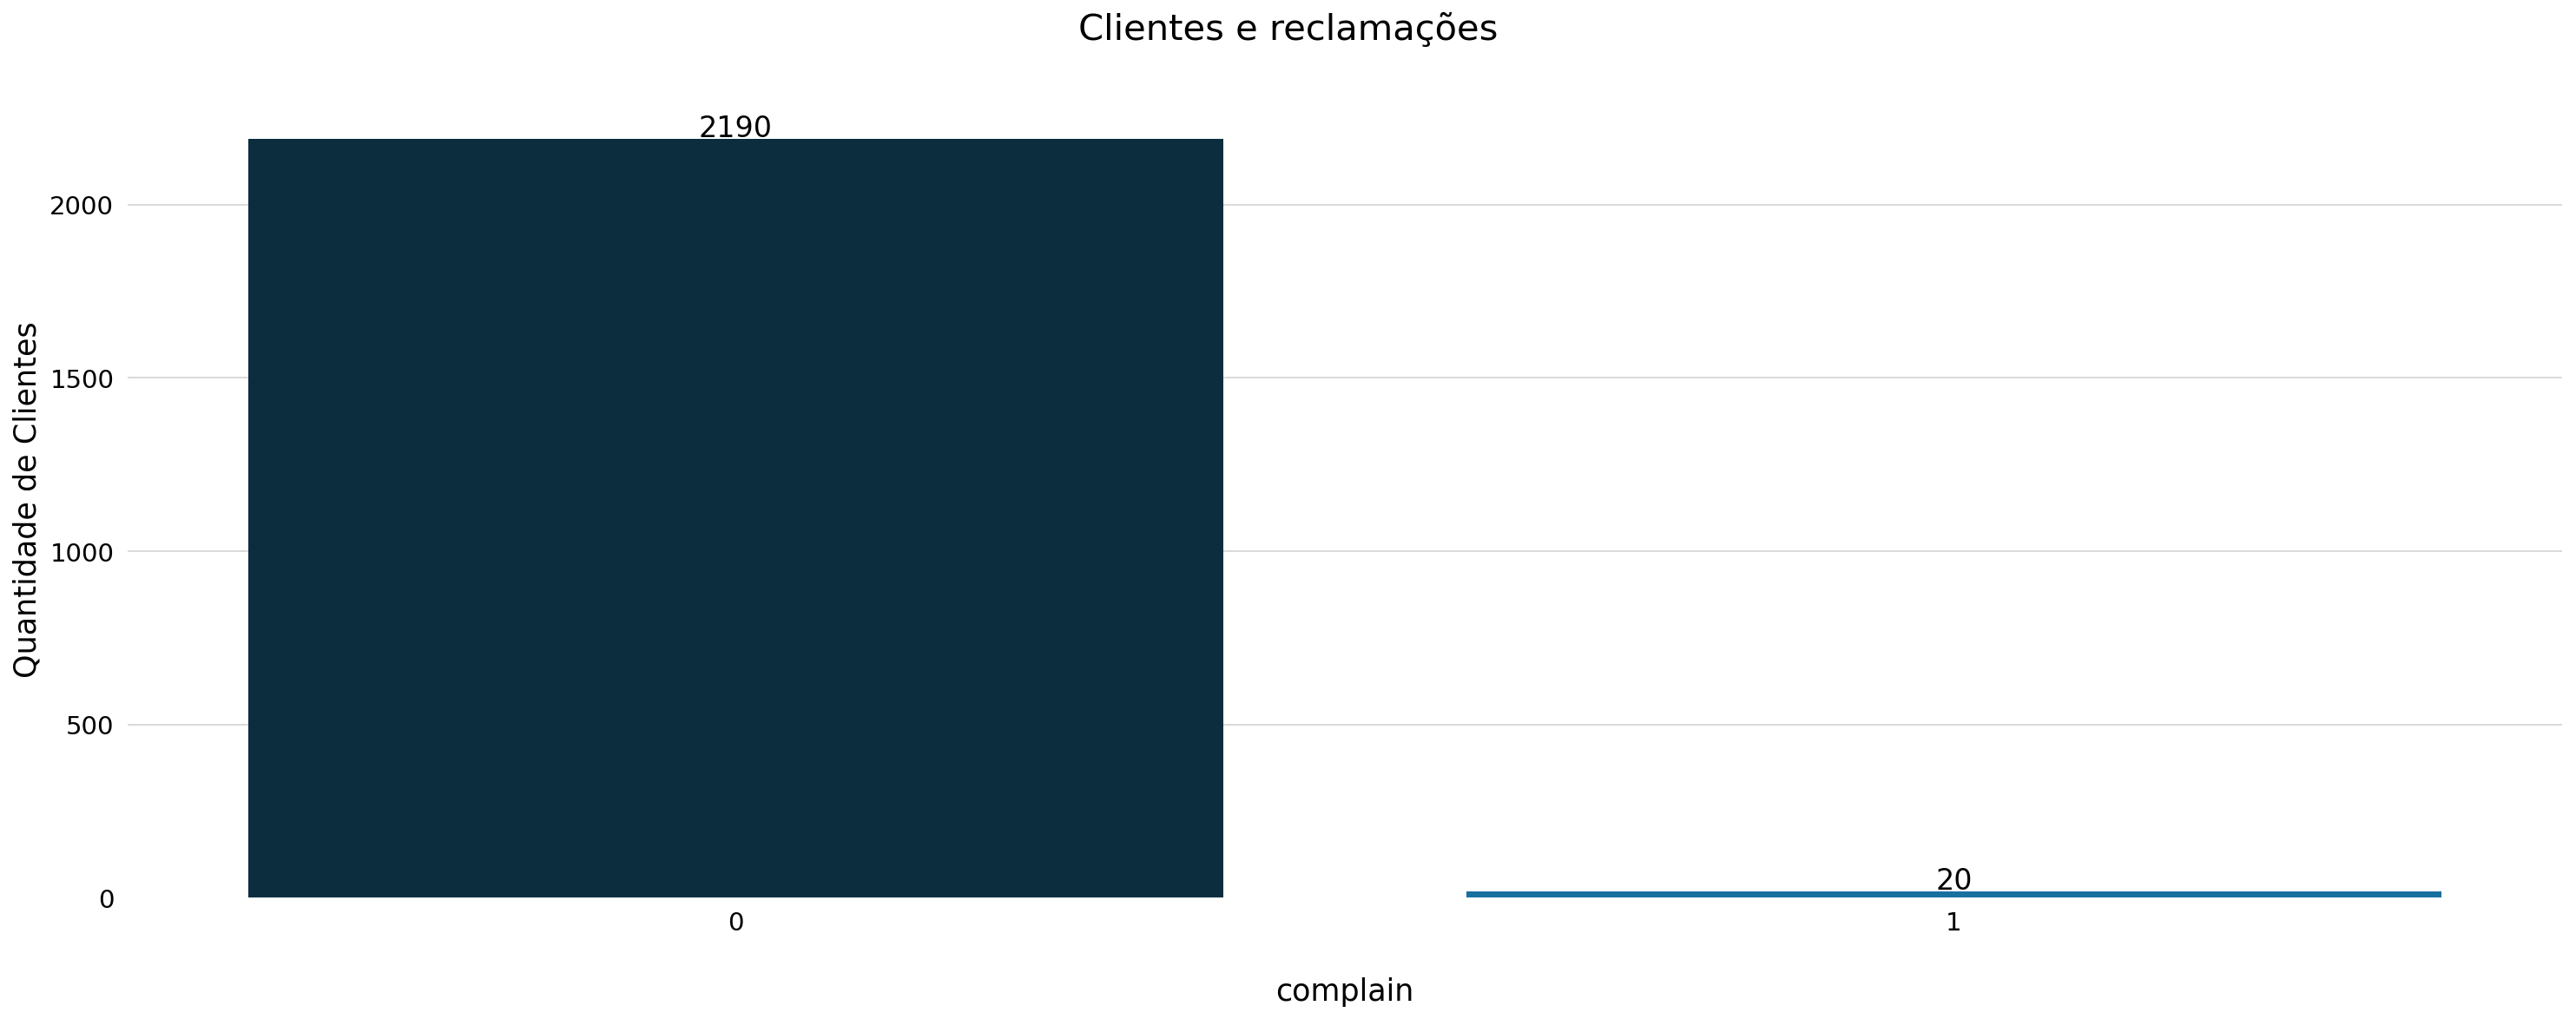

In [39]:
countplot(df_customer, 'complain', 'Clientes e reclamações')

In [40]:
# Visto que o número de reclamações de clientes é insignificante em
# comparação com o total (<1%), a coluna será dropada do dataset
df_customer.drop(columns=['complain'], inplace=True)

In [41]:
df_customer

id  education   income  recency  age  divorced  single  together  \
0      5524          2 58138.00       58   57         0       1         0   
1      2174          2 46344.00       38   60         0       1         0   
2      4141          2 71613.00       26   49         0       0         1   
3      6182          2 26646.00       26   30         0       0         1   
4      5324          4 58293.00       94   33         0       0         1   
...     ...        ...      ...      ...  ...       ...     ...       ...   
2235  10870          2 61223.00       46   47         0       0         1   
2236   4001          4 64014.00       56   68         0       0         1   
2237   7270          2 56981.00       91   33         1       0         0   
2238   8235          3 69245.00        8   58         0       0         1   
2239   9405          4 52869.00       40   60         0       0         1   

      widow  children_home  lifetime  
0         0              0     25.37  
1         0              2      7.03  
2         0              0     13.67  
3         0              1      7.90  
4         0              1      8.63  
...     ...            ...       ...  
2235      0              1     15.97  
2236      0              3      3.90  
2237      0              0      8.43  
2238      0              1      8.47  
2239      0              2     24.00  

[2210 rows x 11 columns]

### 3.2. Produtos

In [42]:
# Dataframe
df_products

id  mnt_wines  mnt_fruits  mnt_meat_products  mnt_fish_products  \
0      5524        635          88                546                172   
1      2174         11           1                  6                  2   
2      4141        426          49                127                111   
3      6182         11           4                 20                 10   
4      5324        173          43                118                 46   
...     ...        ...         ...                ...                ...   
2235  10870        709          43                182                 42   
2236   4001        406           0                 30                  0   
2237   7270        908          48                217                 32   
2238   8235        428          30                214                 80   
2239   9405         84           3                 61                  2   

      mnt_sweet_products  mnt_gold_prods  
0                     88              88  
1                      1               6  
2                     21              42  
3                      3               5  
4                     27              15  
...                  ...             ...  
2235                 118             247  
2236                   0               8  
2237                  12              24  
2238                  30              61  
2239                   1              21  

[2240 rows x 7 columns]

<div align = 'center' >

| Variable          | Description                            |
|-------------------|----------------------------------------|
| `MntWines`        | Amount spent on **wine** in last 2 years   |       
| `MntFruits`       | Amount spent on **fruits** in last 2 years |
| `MntMeatProducts` | Amount spent on **meat** in last 2 years   |
| `MntFishProducts` | Amount spent on **fish** in last 2 years   |
| `MntSweetProducts`| Amount spent on **sweets** in last 2 years |
| `MntGoldProds`    | Amount spent on **gold** products in last 2 years   |

</div>

#### 3.2.1. Types

In [43]:
df_products.dtypes

id                    int64
mnt_wines             int64
mnt_fruits            int64
mnt_meat_products     int64
mnt_fish_products     int64
mnt_sweet_products    int64
mnt_gold_prods        int64
dtype: object

In [44]:
# Modificando nomes das colunas para ficar mais limpo

# Nomes das colunas
columns = df_products.columns

# Loop for 
for name in columns:
    df_products.rename(
        columns={name: name.replace('mnt_', '').replace('_products', '').replace('_prod', '')}, 
        inplace=True)

# Novos nomes
df_products.columns

Index(['id', 'wines', 'fruits', 'meat', 'fish', 'sweet', 'golds'], dtype='object')

#### 3.2.2. Valores nulos

In [45]:
df_null_values(df_products, False)

#Null  %Null   Type
id         0  0.00%  int64
wines      0  0.00%  int64
fruits     0  0.00%  int64
meat       0  0.00%  int64
fish       0  0.00%  int64
sweet      0  0.00%  int64
golds      0  0.00%  int64

#### 3.2.3. Variáveis

##### `wines`

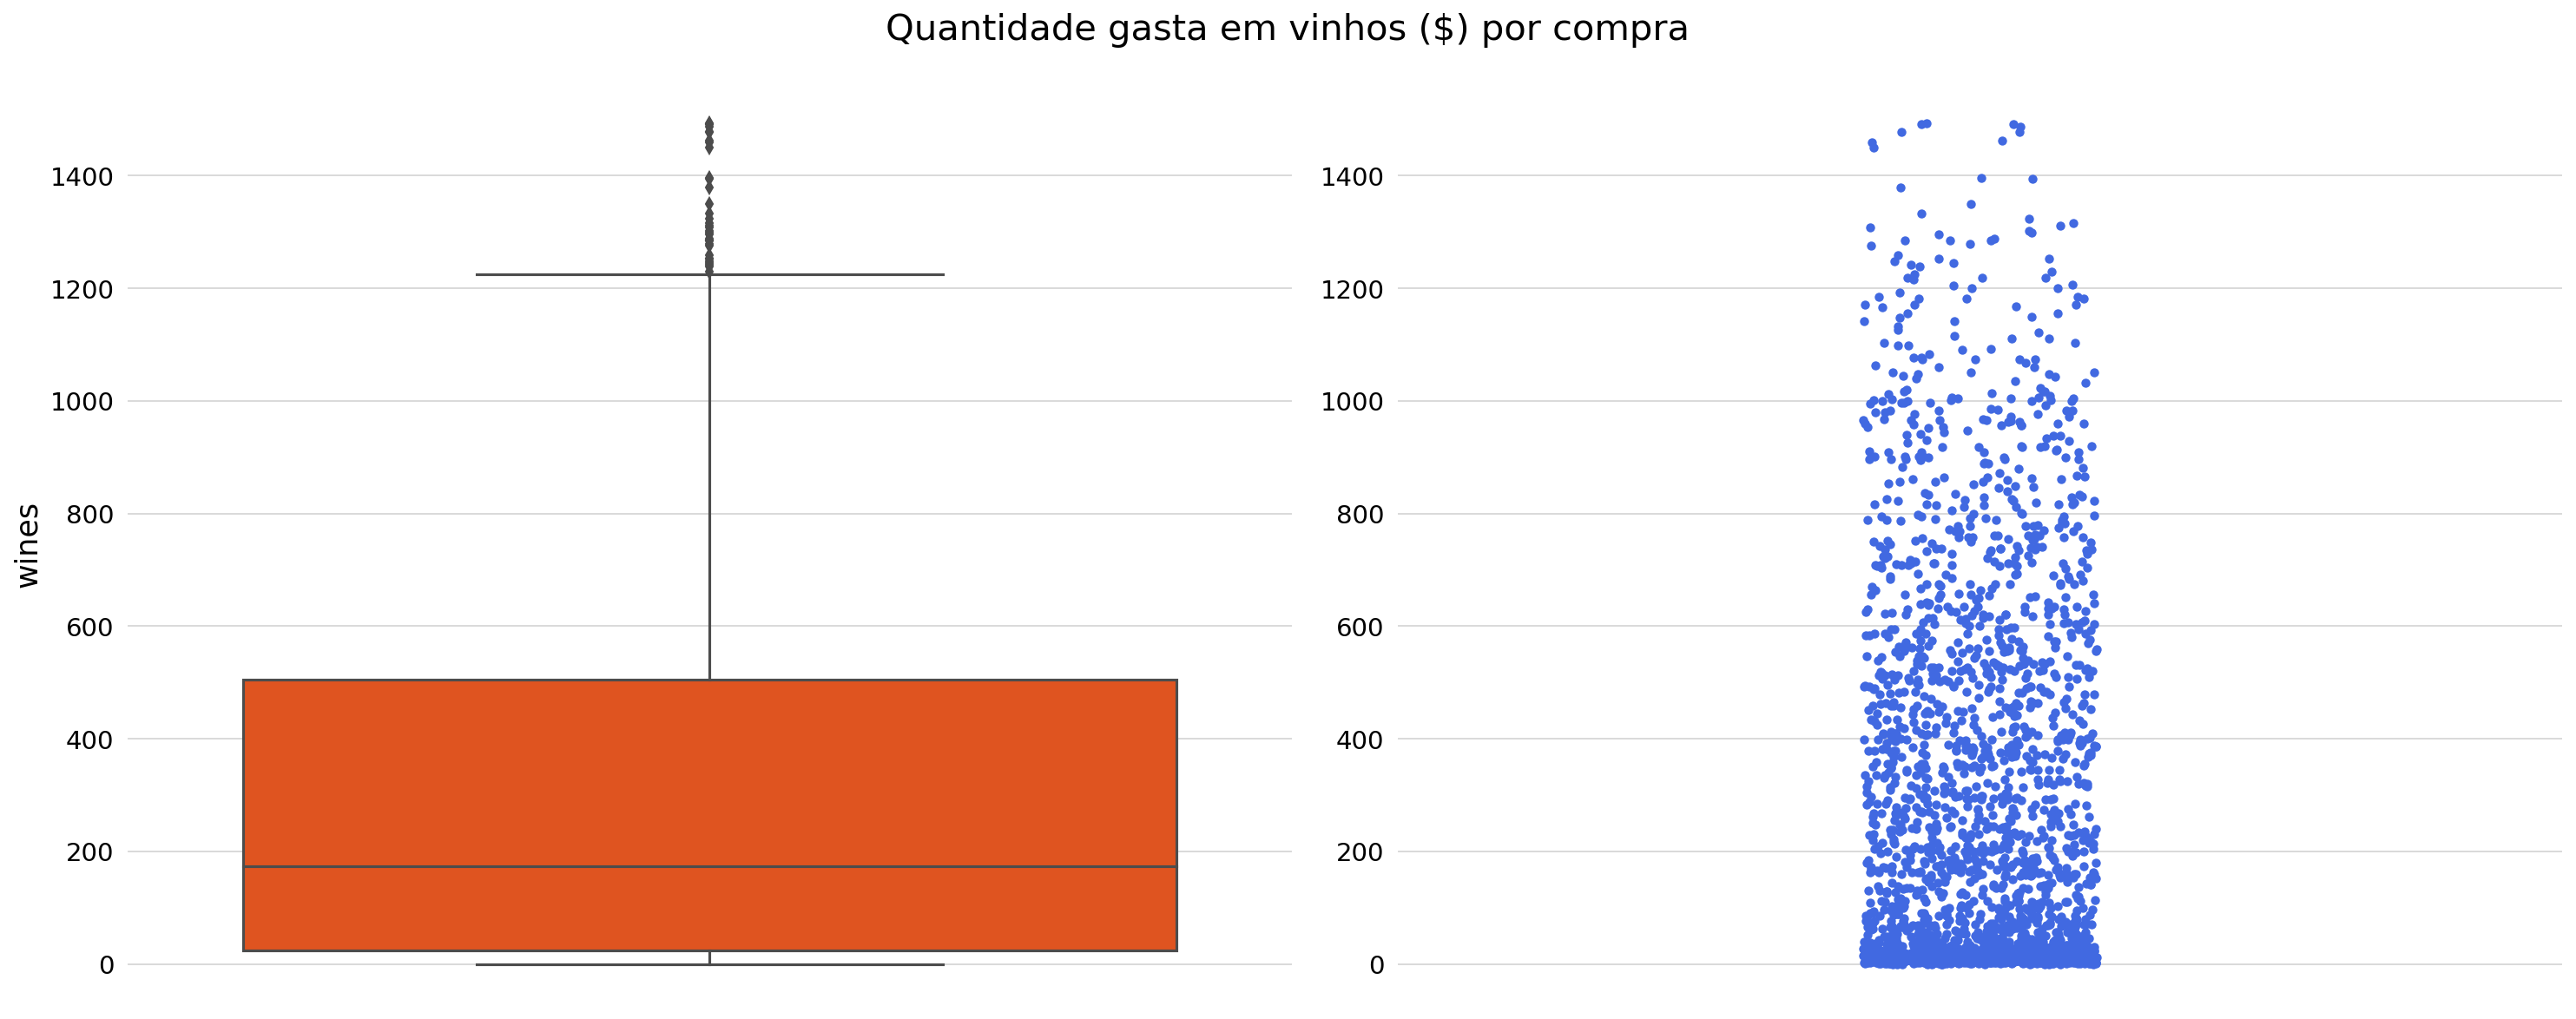

In [46]:
box_strip(df_products, 'wines', 'Quantidade gasta em vinhos ($) por compra')

##### `fruits`

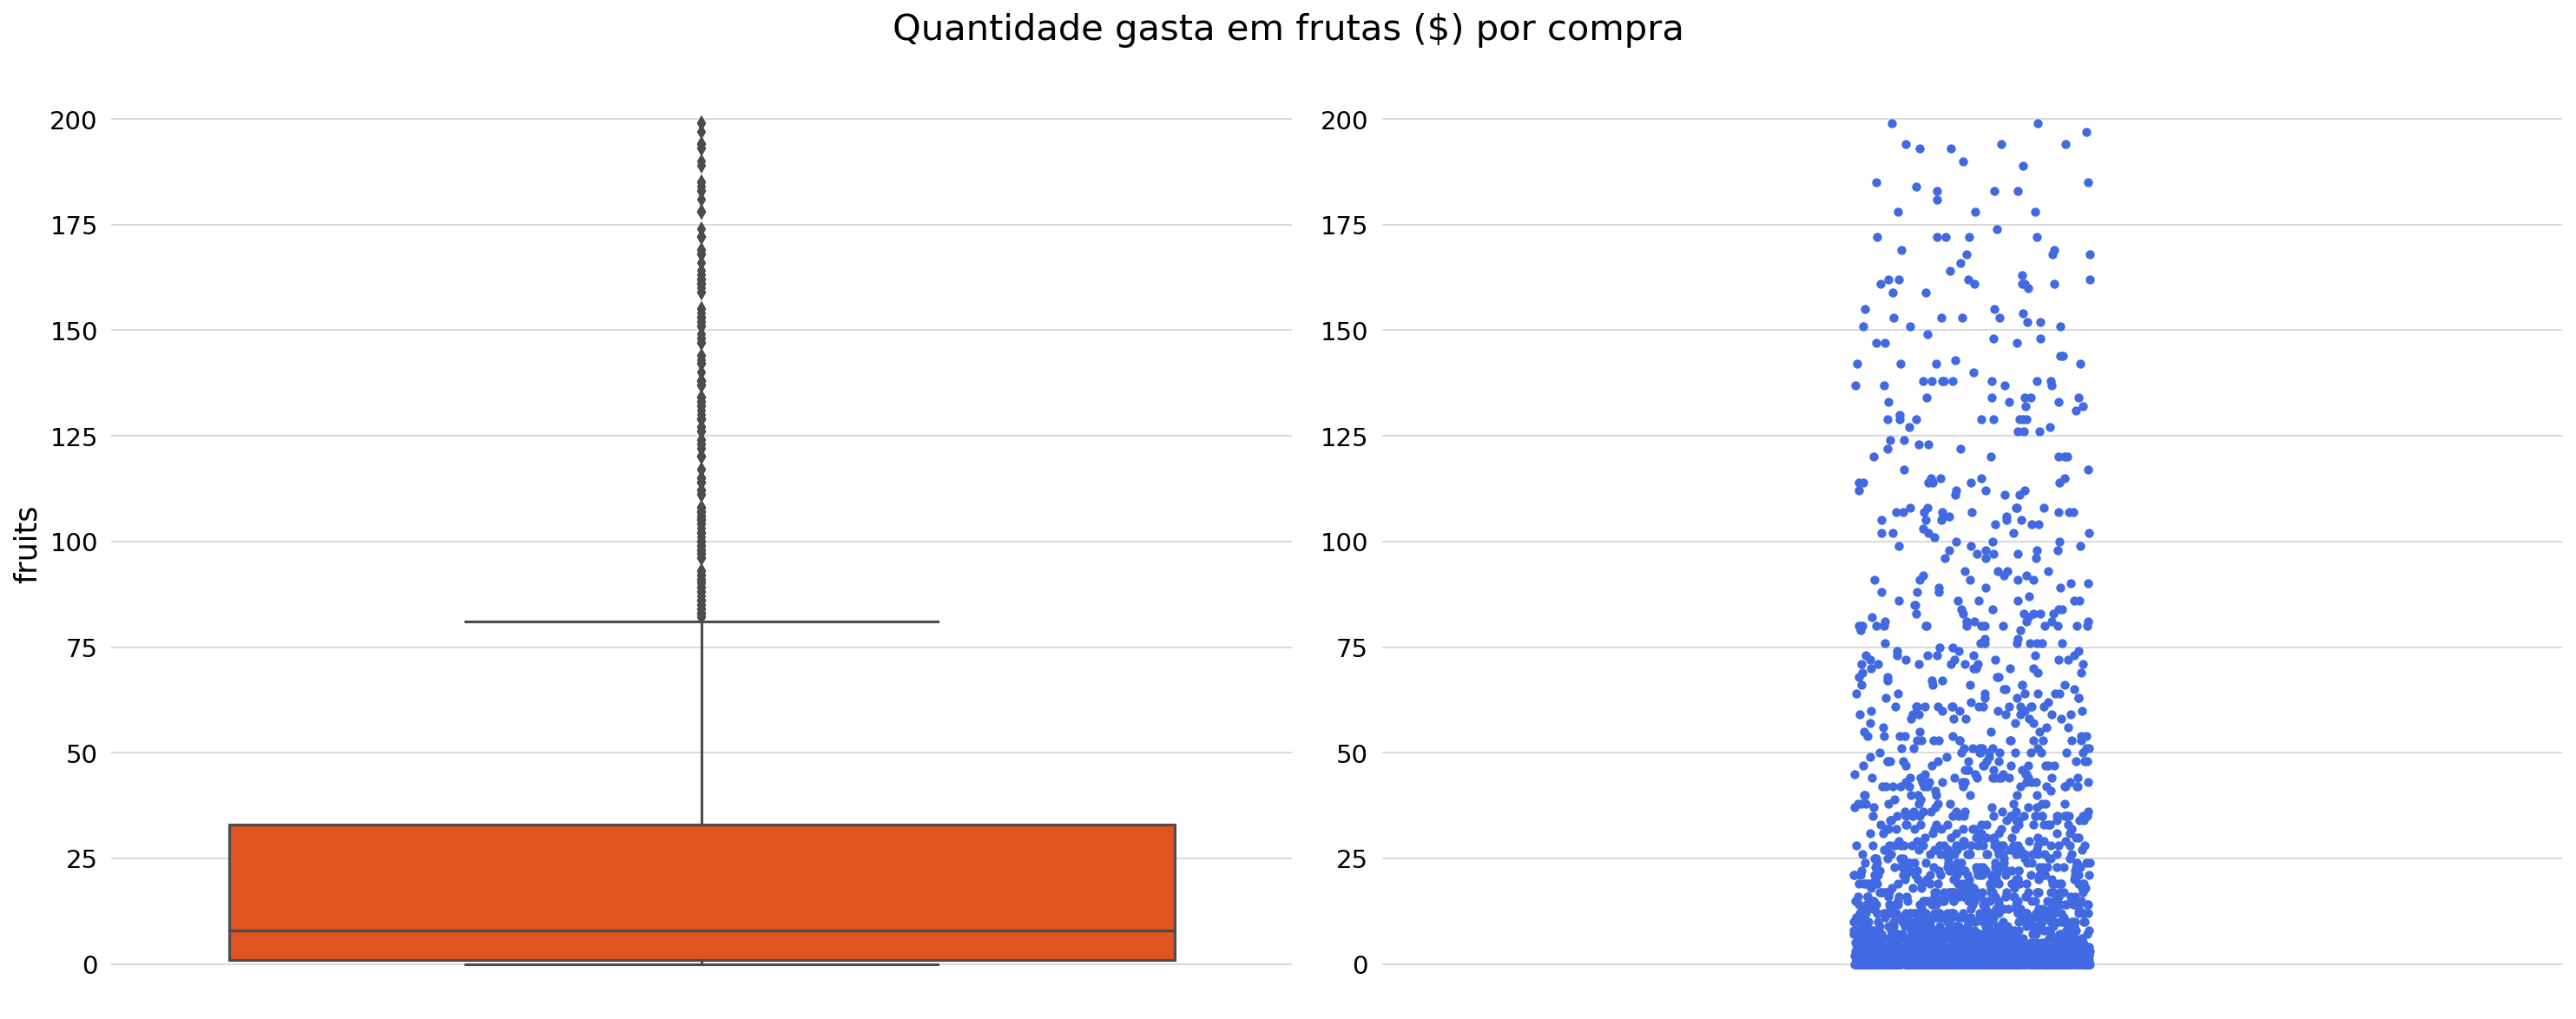

In [47]:
box_strip(df_products, 'fruits', 'Quantidade gasta em frutas ($) por compra')

##### `meat`

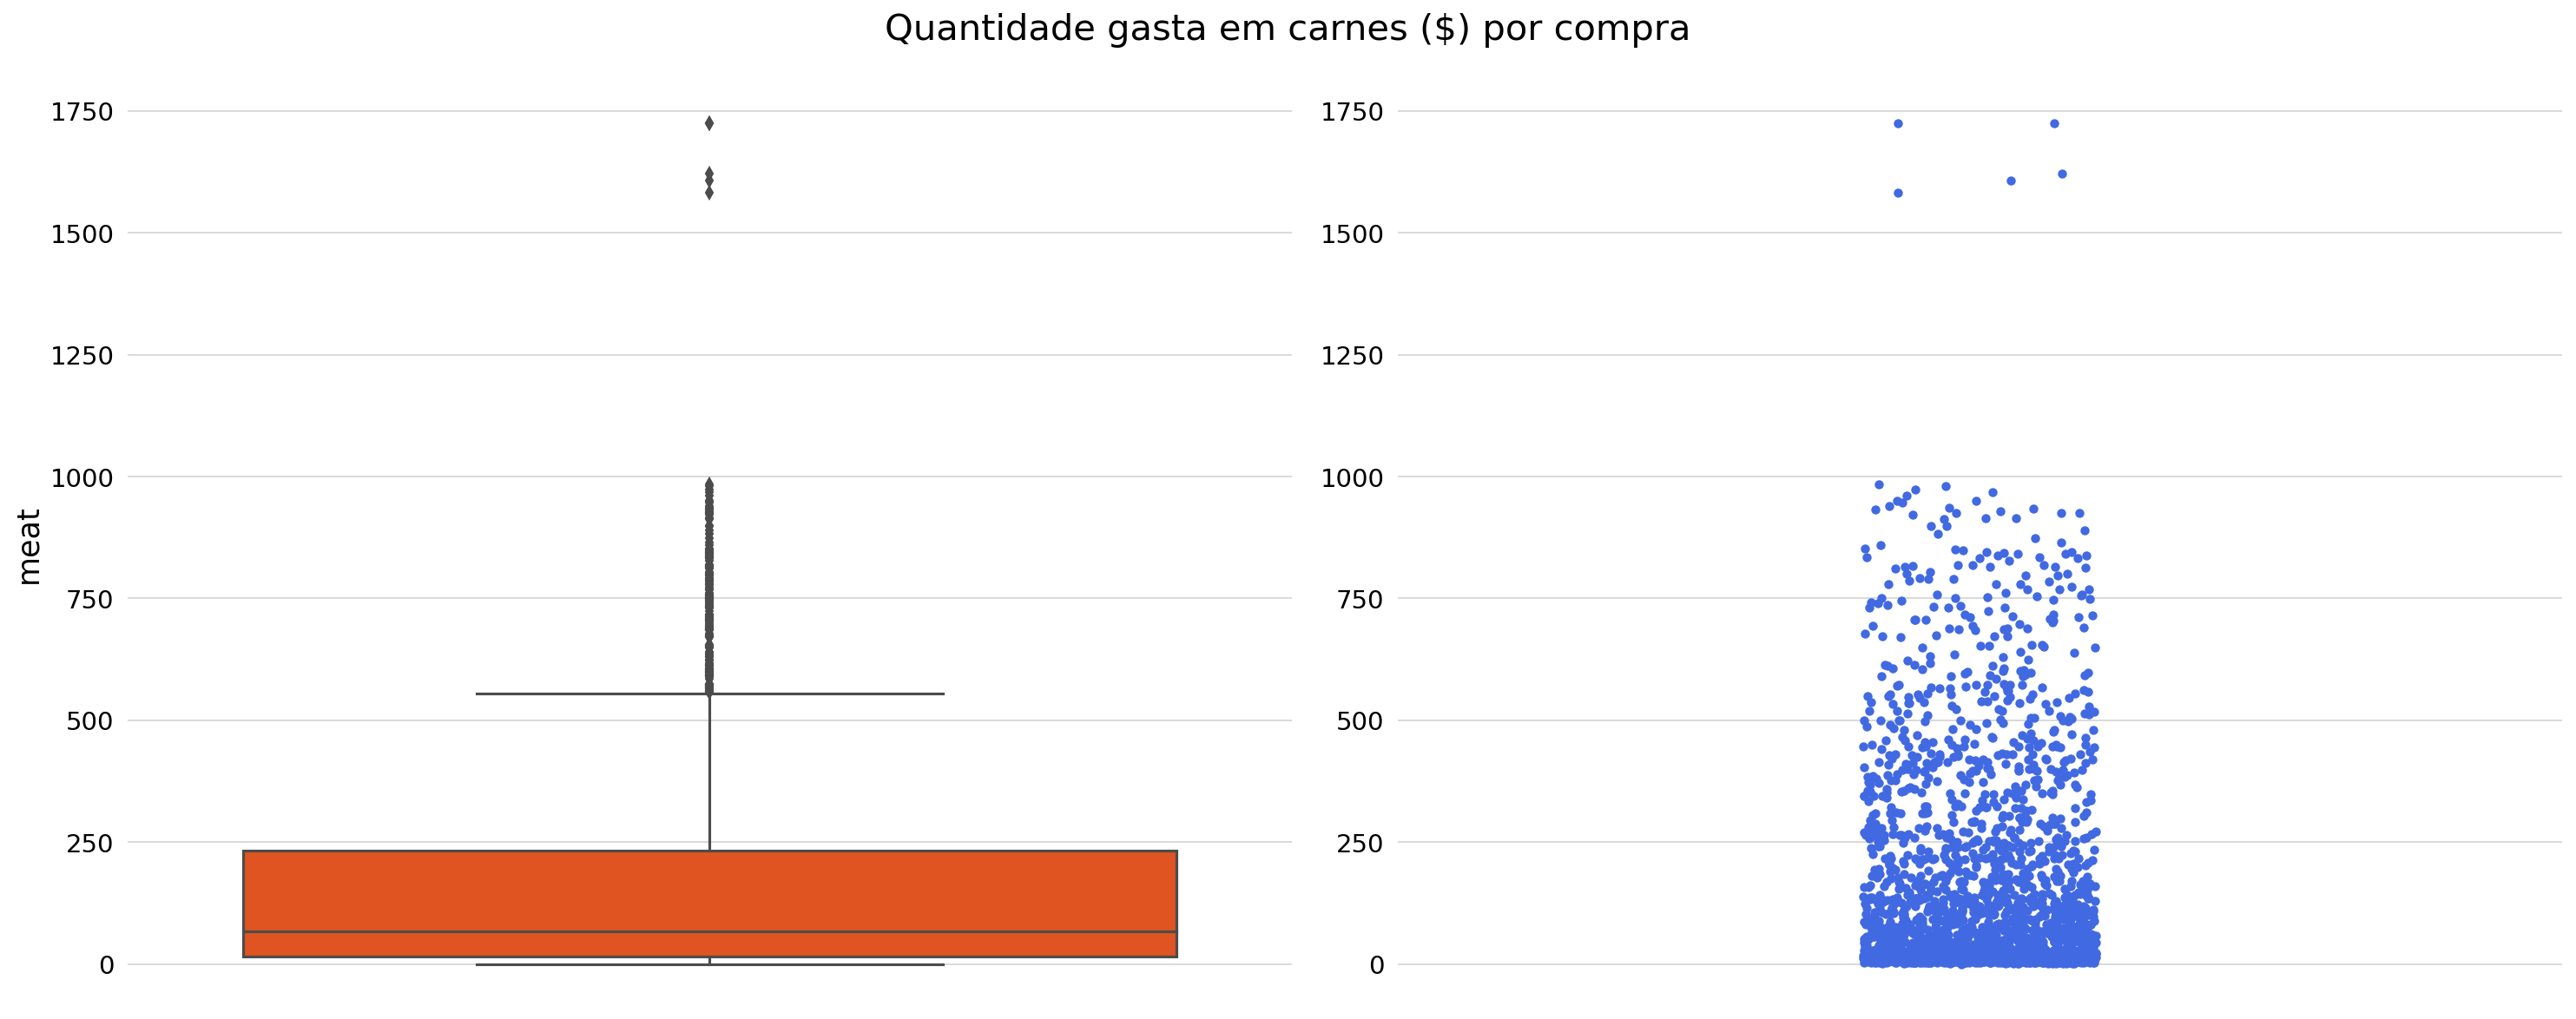

In [48]:
box_strip(df_products, 'meat', 'Quantidade gasta em carnes ($) por compra')

##### `fish`

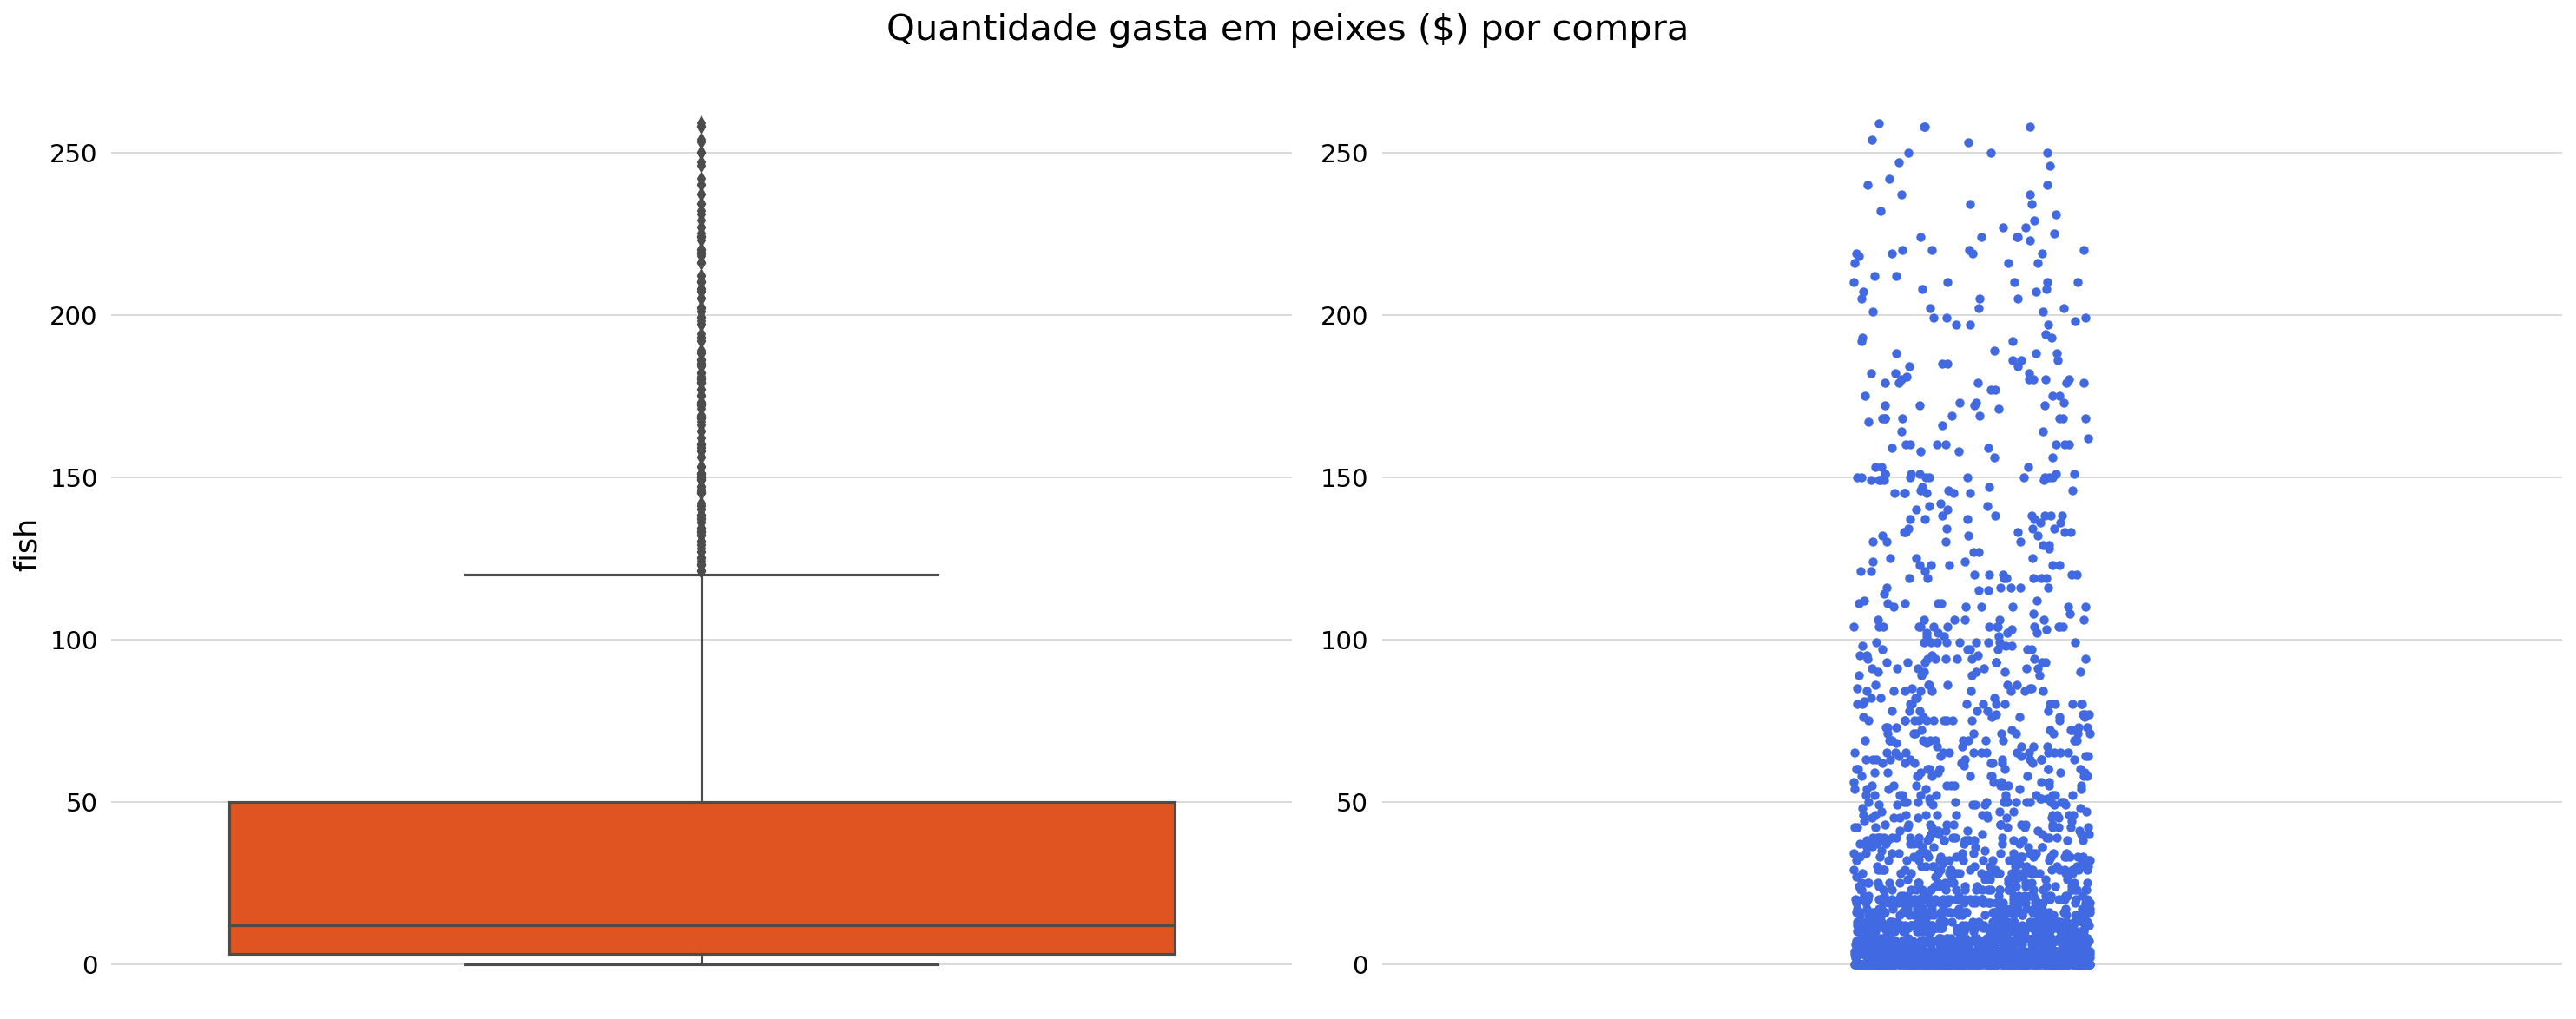

In [49]:
box_strip(df_products, 'fish', 'Quantidade gasta em peixes ($) por compra')

##### `sweet`

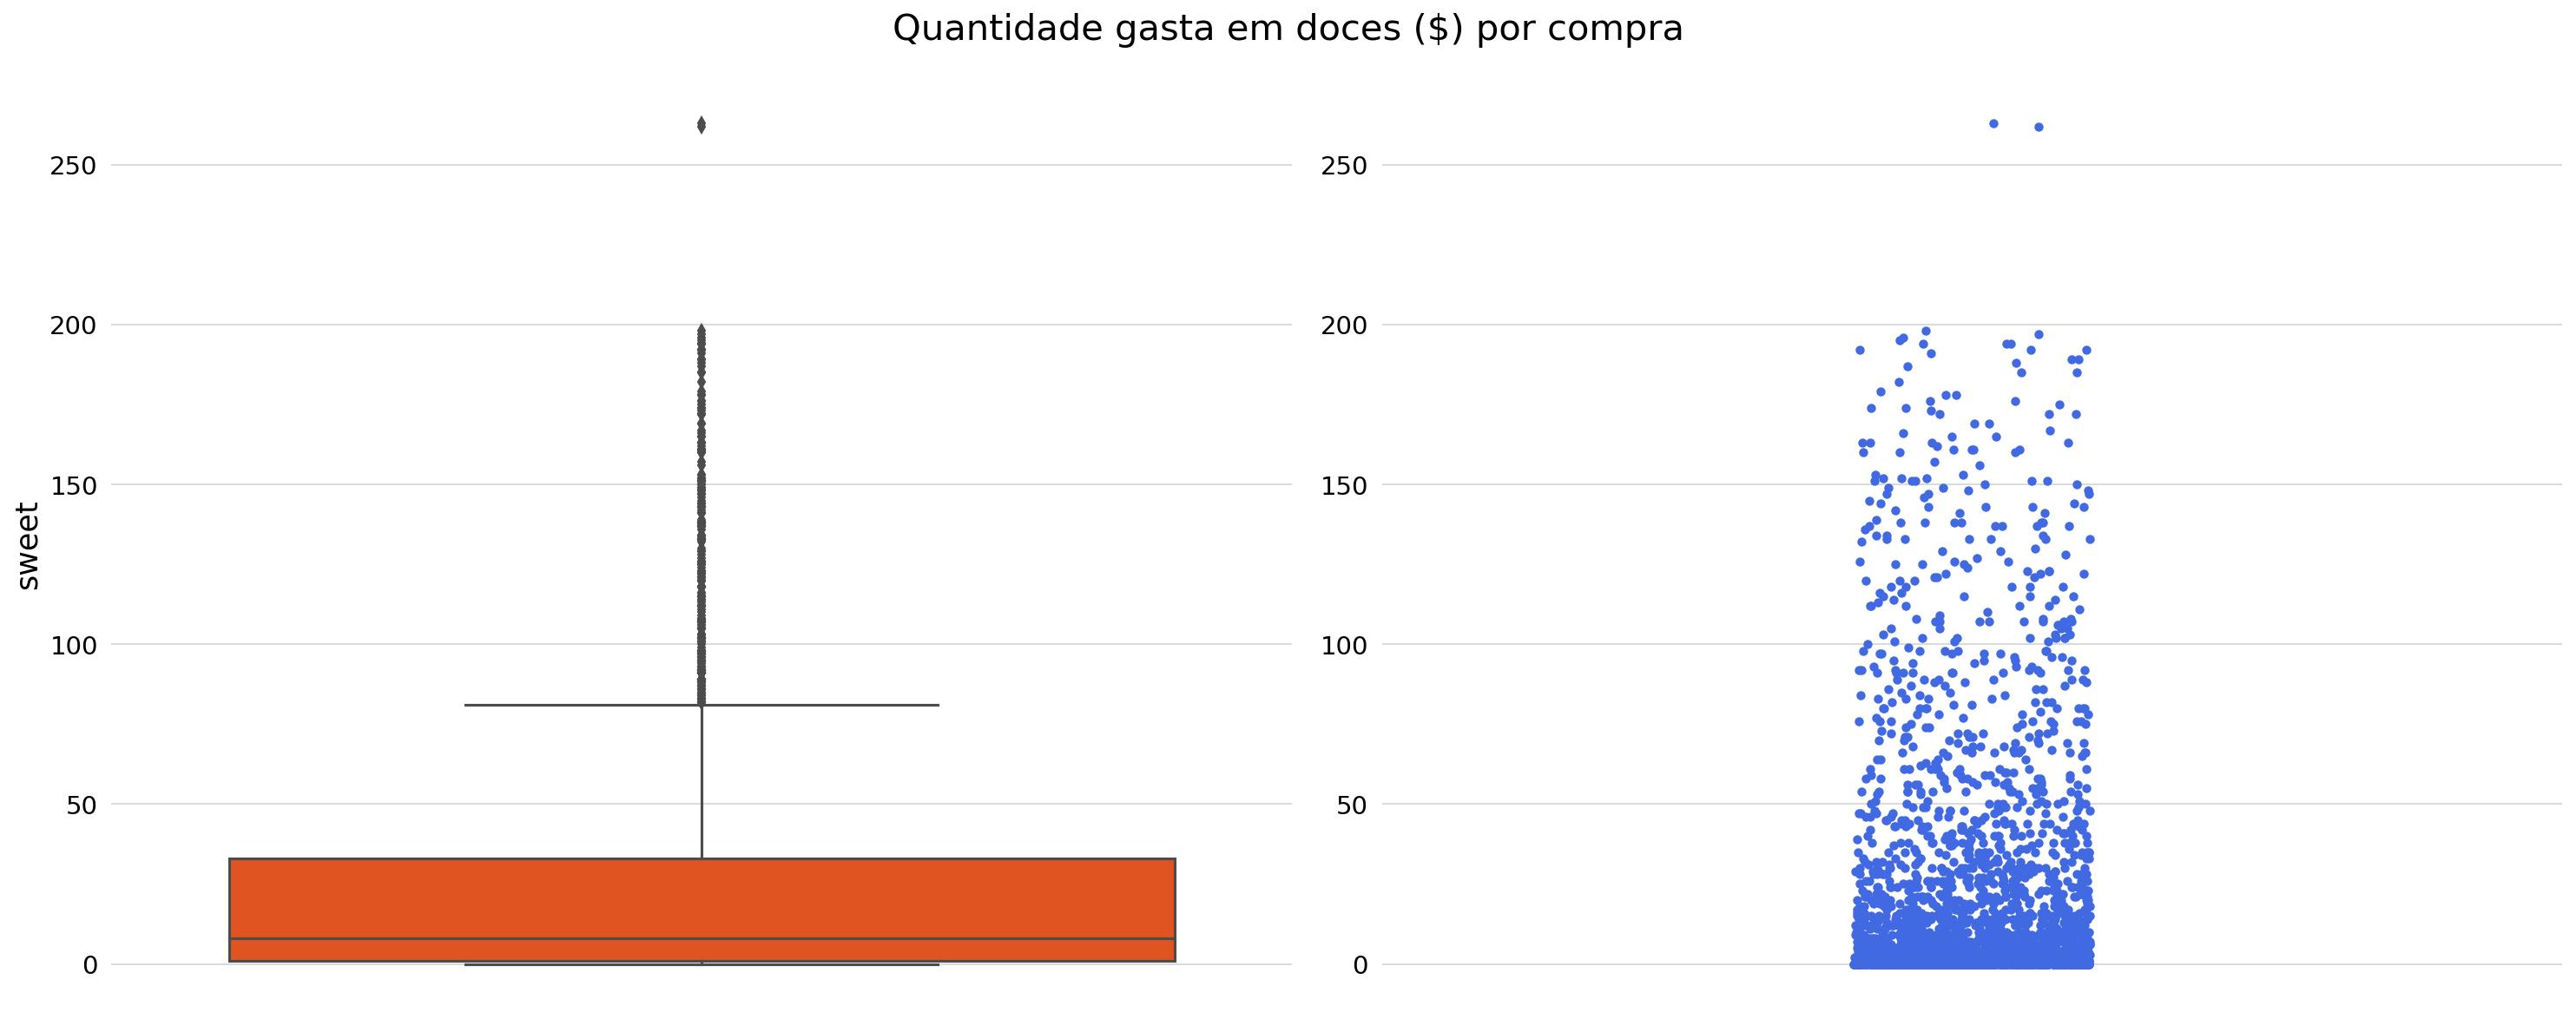

In [50]:
box_strip(df_products, 'sweet', 'Quantidade gasta em doces ($) por compra')

##### `golds`

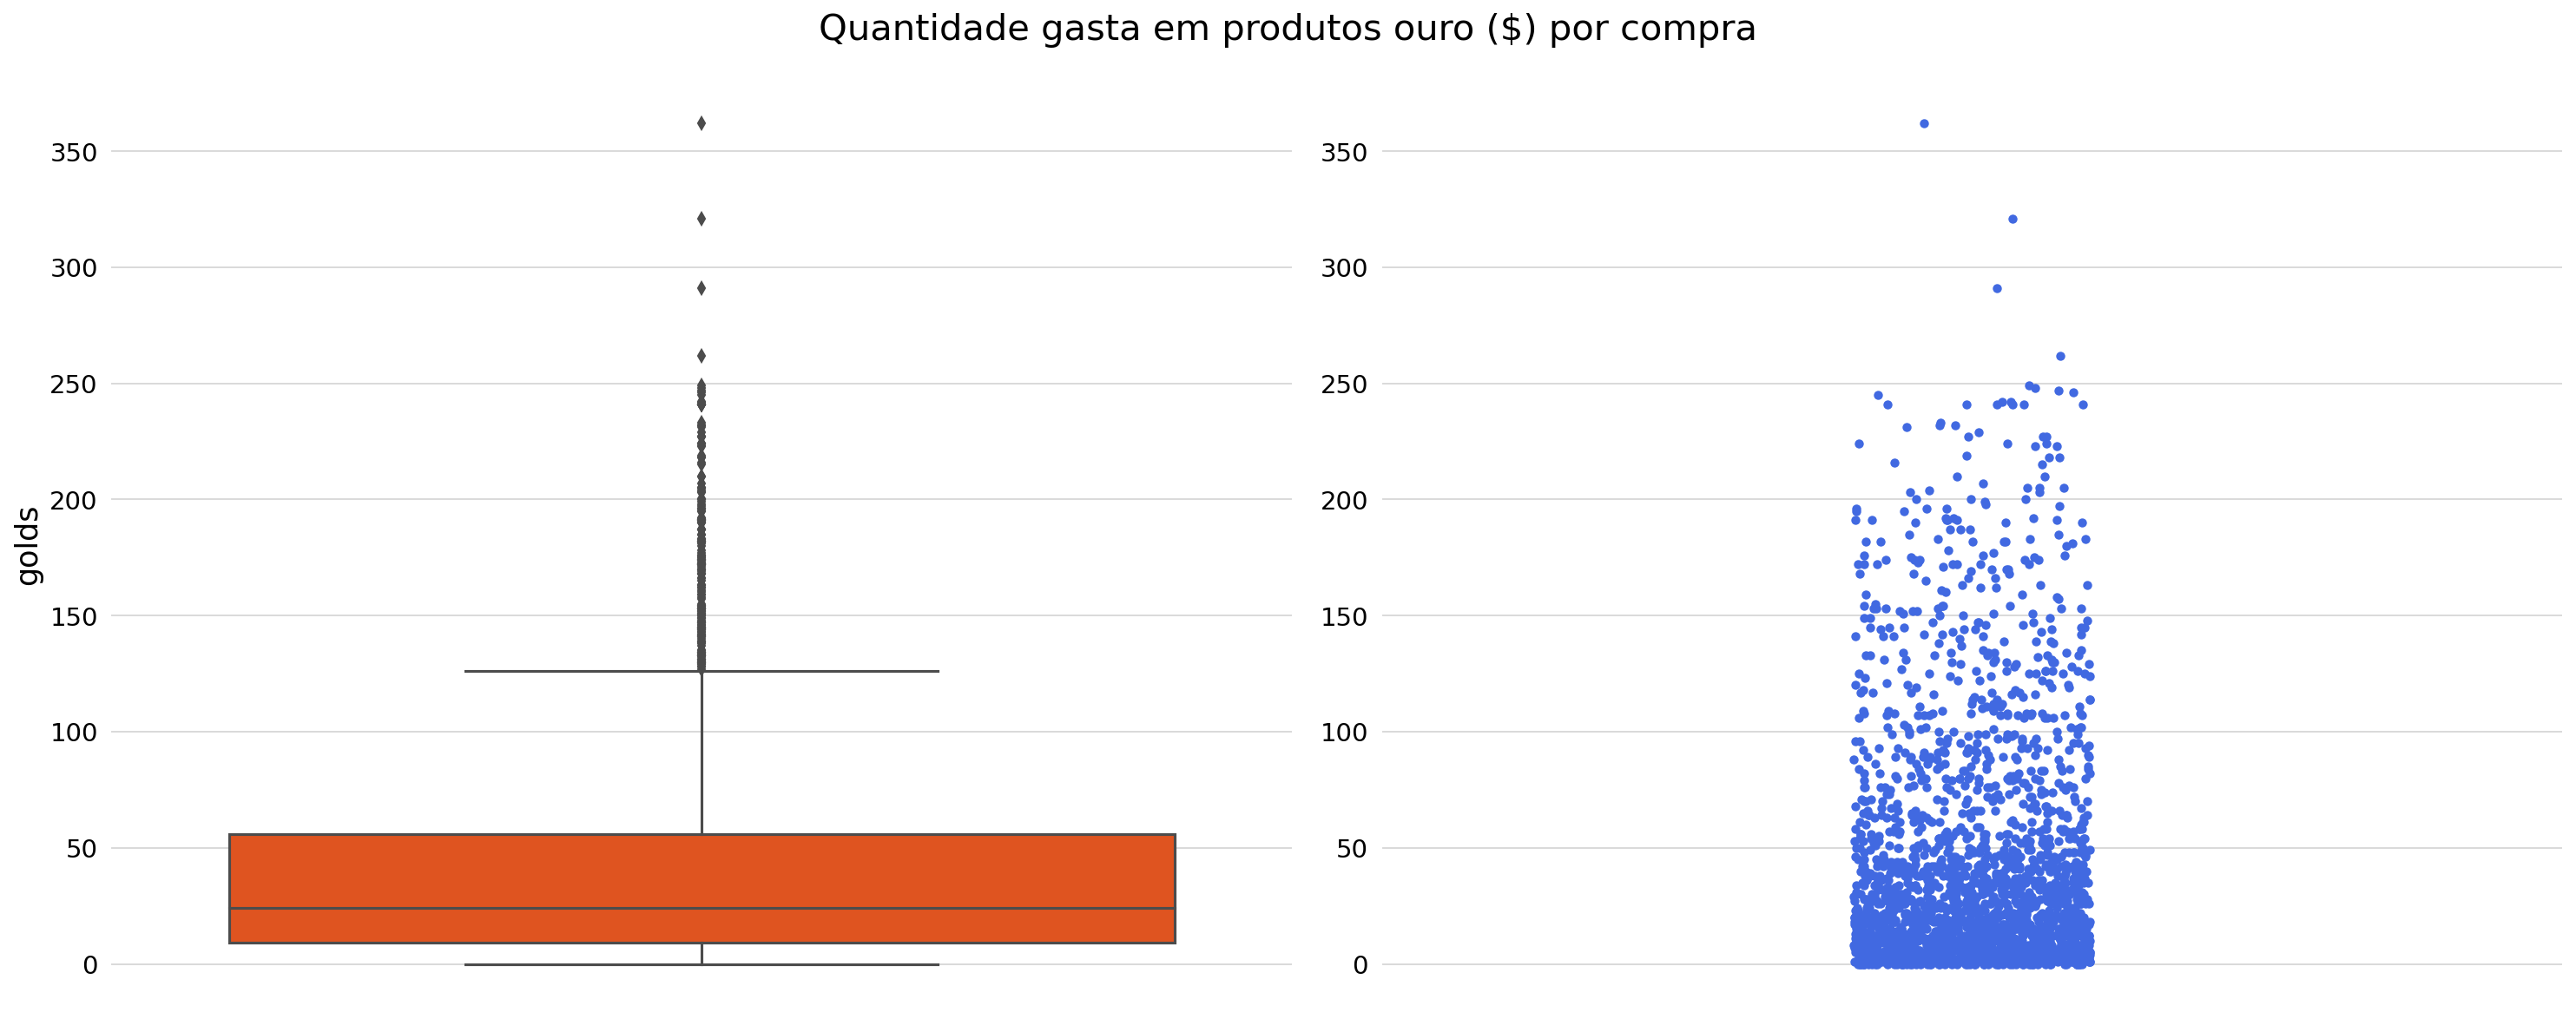

In [51]:
box_strip(df_products, 'golds', 'Quantidade gasta em produtos ouro ($) por compra')

#### 3.2.4. Modificações

In [52]:
# Criando uma coluna com a soma de todos os gastos em cada compra
df_products['total_amount'] = df_products['fish'] + df_products['fruits'] \
+ df_products['golds'] + df_products['meat'] + df_products['sweet'] + df_products['wines']

In [53]:
# Cada coluna agora será o quanto cada tipo de produto representa no total (%)
columns_to_transform = ['wines', 'fruits', 'meat', 'fish', 'sweet', 'golds']

for column in columns_to_transform:
    df_products[column] = df_products[column] / df_products['total_amount']

# Realizando a descrição dos dados
df_products.describe().T

count    mean     std  min     25%     50%     75%      max
id           2240.00 5592.16 3246.66 0.00 2828.25 5458.50 8427.75 11191.00
wines        2240.00    0.46    0.23 0.00    0.29    0.46    0.64     0.96
fruits       2240.00    0.05    0.06 0.00    0.01    0.03    0.07     0.45
meat         2240.00    0.25    0.13 0.00    0.16    0.23    0.33     1.00
fish         2240.00    0.07    0.08 0.00    0.01    0.05    0.10     0.59
sweet        2240.00    0.05    0.06 0.00    0.01    0.03    0.07     0.95
golds        2240.00    0.12    0.11 0.00    0.04    0.09    0.17     0.89
total_amount 2240.00  605.80  602.25 5.00   68.75  396.00 1045.50  2525.00

In [54]:
# Visualizando dataset
df_products

id  wines  fruits  meat  fish  sweet  golds  total_amount
0      5524   0.39    0.05  0.34  0.11   0.05   0.05          1617
1      2174   0.41    0.04  0.22  0.07   0.04   0.22            27
2      4141   0.55    0.06  0.16  0.14   0.03   0.05           776
3      6182   0.21    0.08  0.38  0.19   0.06   0.09            53
4      5324   0.41    0.10  0.28  0.11   0.06   0.04           422
...     ...    ...     ...   ...   ...    ...    ...           ...
2235  10870   0.53    0.03  0.14  0.03   0.09   0.18          1341
2236   4001   0.91    0.00  0.07  0.00   0.00   0.02           444
2237   7270   0.73    0.04  0.17  0.03   0.01   0.02          1241
2238   8235   0.51    0.04  0.25  0.09   0.04   0.07           843
2239   9405   0.49    0.02  0.35  0.01   0.01   0.12           172

[2240 rows x 8 columns]

### 3.3. Compras

In [55]:
# Dataframe
df_purchases

id  num_deals_purchases  num_web_purchases  num_catalog_purchases  \
0      5524                    3                  8                     10   
1      2174                    2                  1                      1   
2      4141                    1                  8                      2   
3      6182                    2                  2                      0   
4      5324                    5                  5                      3   
...     ...                  ...                ...                    ...   
2235  10870                    2                  9                      3   
2236   4001                    7                  8                      2   
2237   7270                    1                  2                      3   
2238   8235                    2                  6                      5   
2239   9405                    3                  3                      1   

      num_store_purchases  num_web_visits_month  
0                       4                     7  
1                       2                     5  
2                      10                     4  
3                       4                     6  
4                       6                     5  
...                   ...                   ...  
2235                    4                     5  
2236                    5                     7  
2237                   13                     6  
2238                   10                     3  
2239                    4                     7  

[2240 rows x 6 columns]

<div align = 'center' >

| Variable              | Description                       |
|-----------------------|-----------------------------------|
| `NumDealsPurchases`   | Number of purchases made with a discount |       
| `NumWebPurchases`     | Number of purchases made through the company's website |
| `NumCatalogPurchases` | Number of purchases made using a catalogue |
| `NumStorePurchases`   | Number of purchases made directly in stores |
| `NumWebVisitsMonth`   | Number of visits to company's website in the last month |

</div>

#### 3.3.1. Types

In [56]:
df_purchases.dtypes

id                       int64
num_deals_purchases      int64
num_web_purchases        int64
num_catalog_purchases    int64
num_store_purchases      int64
num_web_visits_month     int64
dtype: object

In [57]:
# Modificando nomes das colunas para ficar mais limpo

# Nomes das colunas
columns = df_purchases.columns

# Loop for 
for name in columns:
    df_purchases.rename(
        columns={name: name.replace('num_', '').replace('urchases', '').replace('_month', '')}, 
        inplace=True)

# Novos nomes
df_purchases.columns

Index(['id', 'deals_p', 'web_p', 'catalog_p', 'store_p', 'web_visits'], dtype='object')

In [58]:
df_purchases.describe().T

count    mean     std  min     25%     50%     75%      max
id         2240.00 5592.16 3246.66 0.00 2828.25 5458.50 8427.75 11191.00
deals_p    2240.00    2.33    1.93 0.00    1.00    2.00    3.00    15.00
web_p      2240.00    4.08    2.78 0.00    2.00    4.00    6.00    27.00
catalog_p  2240.00    2.66    2.92 0.00    0.00    2.00    4.00    28.00
store_p    2240.00    5.79    3.25 0.00    3.00    5.00    8.00    13.00
web_visits 2240.00    5.32    2.43 0.00    3.00    6.00    7.00    20.00

#### 3.3.2. Valores nulos

In [59]:
df_null_values(df_purchases, False)

#Null  %Null   Type
id             0  0.00%  int64
deals_p        0  0.00%  int64
web_p          0  0.00%  int64
catalog_p      0  0.00%  int64
store_p        0  0.00%  int64
web_visits     0  0.00%  int64

#### 3.3.3 Variáveis

In [60]:
# Somando as vendas pelo site, catálogo e diretamente nas lojas 
df_purchases['total_p'] = df_purchases['store_p'] + df_purchases['web_p'] + df_purchases['catalog_p']

In [61]:
# Visualizando quando não houve vendas
df_purchases[df_purchases['total_p'] == 0]

id  deals_p  web_p  catalog_p  store_p  web_visits  total_p
655    5555        0      0          0        0           0        0
981    3955        0      0          0        0          14        0
1245   6862       15      0          0        0          20        0
1524  11110        0      0          0        0          14        0
1846   9931       15      0          0        0          19        0
2132  11181        0      0          0        0           0        0

In [62]:
# Excluindo estas seis observações "nulas"
df_purchases = df_purchases[df_purchases['total_p'] > 0]

In [63]:
# Cada coluna agora será o quanto cada tipo de produto representa no total (%)
columns_to_transform = ['deals_p', 'web_p', 'catalog_p', 'store_p']

for column in columns_to_transform:
    df_purchases[column] = df_purchases[column] / df_purchases['total_p']

# Realizando a descrição dos dados
df_purchases.describe().T

count    mean     std  min     25%     50%     75%      max
id         2234.00 5585.43 3245.17 0.00 2817.75 5453.50 8419.50 11191.00
deals_p    2234.00    0.25    0.36 0.00    0.08    0.20    0.33    15.00
web_p      2234.00    0.33    0.12 0.00    0.25    0.33    0.40     1.00
catalog_p  2234.00    0.16    0.14 0.00    0.00    0.15    0.25     1.00
store_p    2234.00    0.51    0.15 0.00    0.40    0.50    0.60     1.00
web_visits 2234.00    5.30    2.37 0.00    3.00    6.00    7.00    20.00
total_p    2234.00   12.57    7.19 1.00    6.00   12.00   18.00    32.00

##### `deals_p`

In [64]:
# Como o máximo de 'deals_p' está em 15, há algo ainda a corrigir nessa variável
df_purchases[df_purchases['deals_p'] > 1]

id  deals_p  web_p  catalog_p  store_p  web_visits  total_p
1042  10749    15.00   0.00       1.00     0.00          19        1

In [65]:
# Como é apenas uma situação, iremos excluí-la
df_purchases = df_purchases[df_purchases['deals_p'] <= 1]

##### `web_visits`

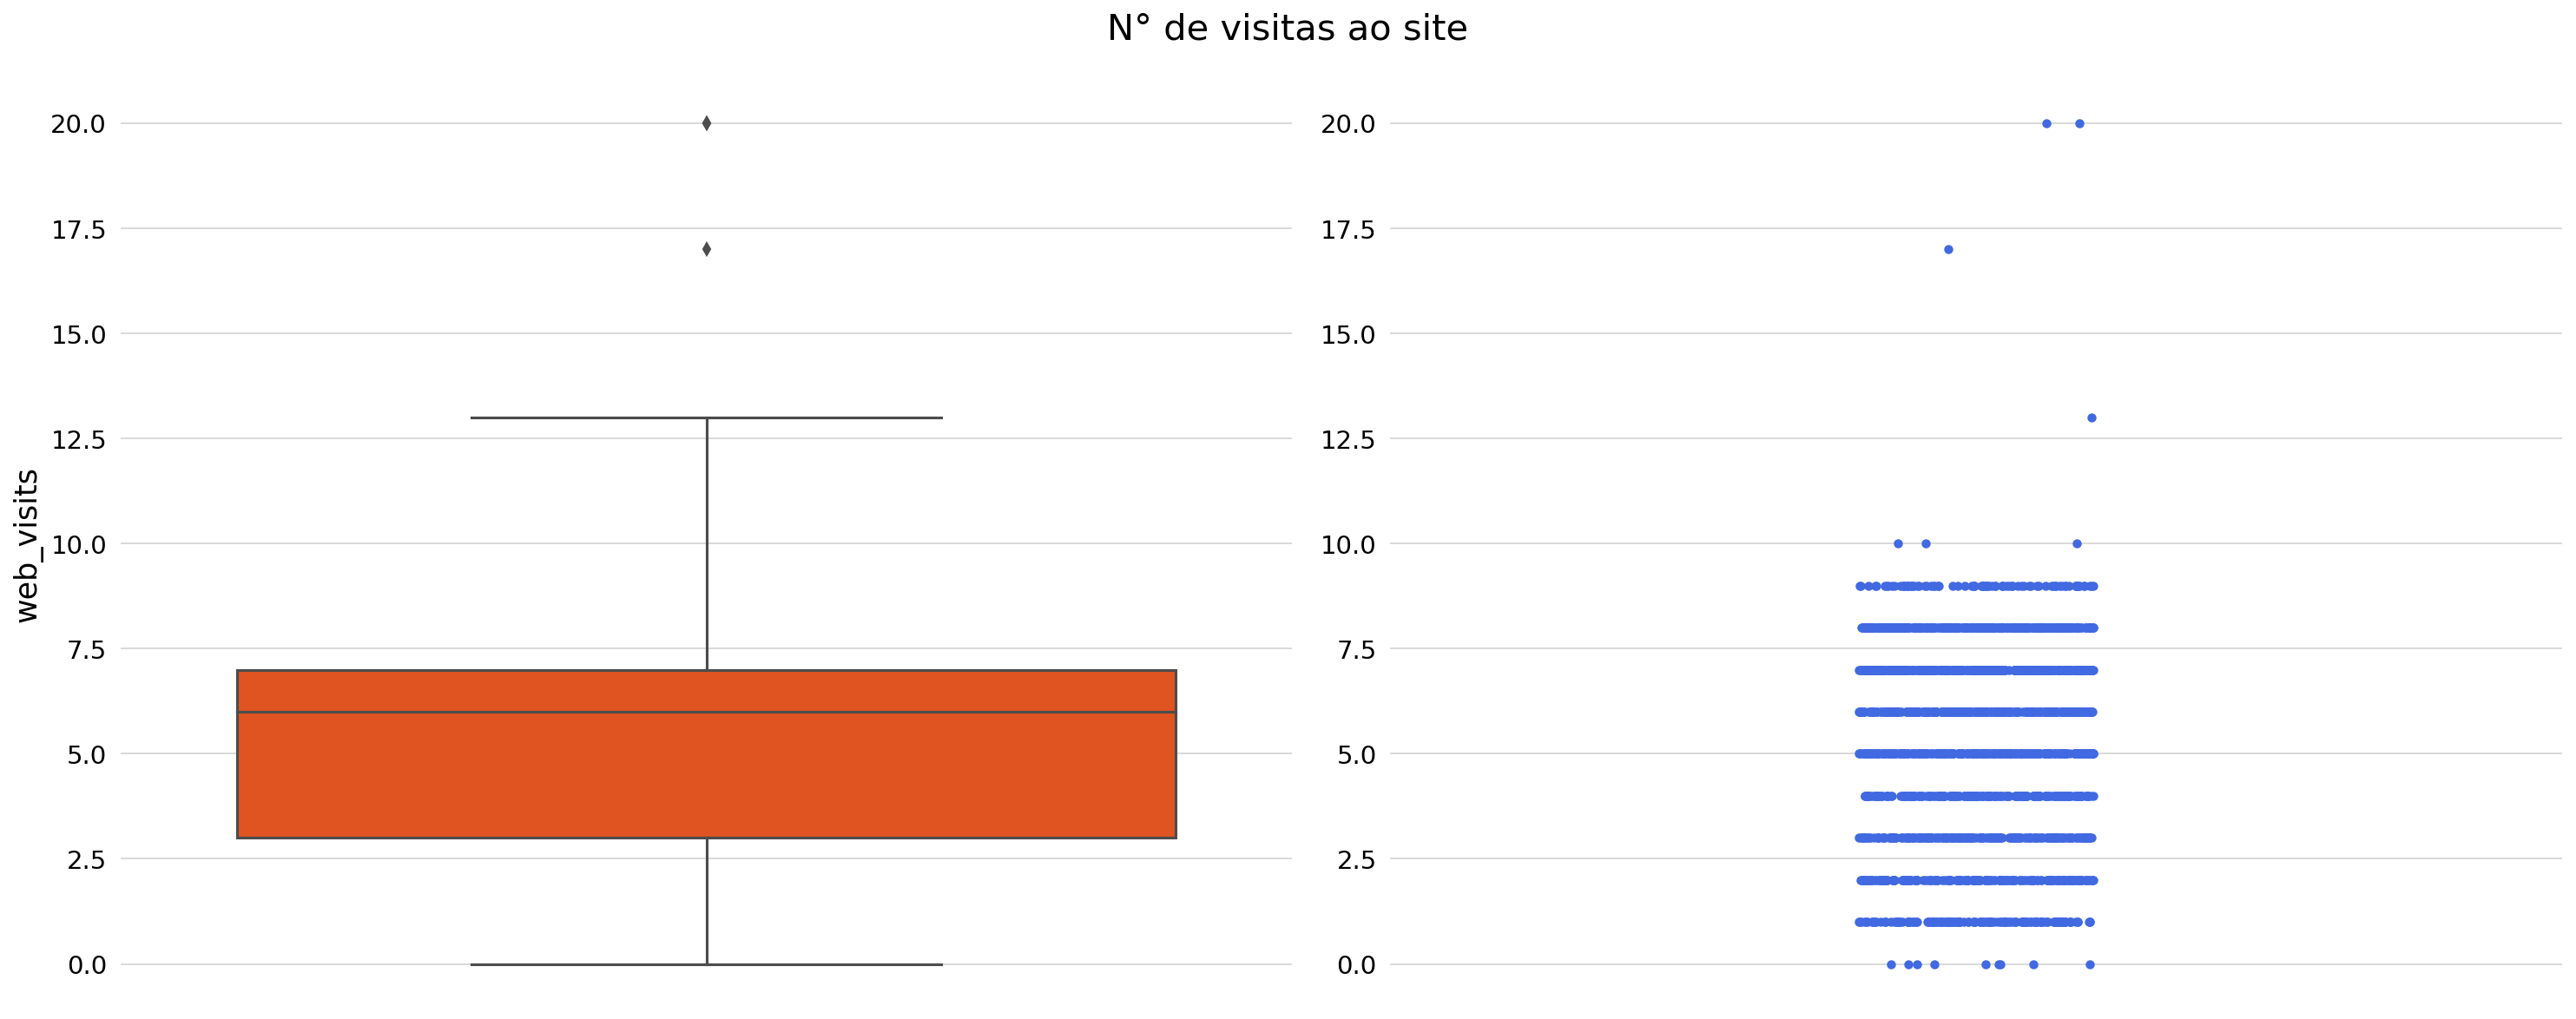

In [66]:
box_strip(df_purchases, 'web_visits', 'N° de visitas ao site')

### 3.4. Promoção

In [67]:
# Dataframe
df_promotion

id  accepted_cmp1  accepted_cmp2  accepted_cmp3  accepted_cmp4  \
0      5524              0              0              0              0   
1      2174              0              0              0              0   
2      4141              0              0              0              0   
3      6182              0              0              0              0   
4      5324              0              0              0              0   
...     ...            ...            ...            ...            ...   
2235  10870              0              0              0              0   
2236   4001              1              0              0              0   
2237   7270              0              0              0              1   
2238   8235              0              0              0              0   
2239   9405              0              0              0              0   

      accepted_cmp5  response  
0                 0         1  
1                 0         0  
2                 0         0  
3                 0         0  
4                 0         0  
...             ...       ...  
2235              0         0  
2236              0         0  
2237              0         0  
2238              0         0  
2239              0         1  

[2240 rows x 7 columns]

<div align = 'center' >

| Variable        | Description                       |
|-----------------|-----------------------------------|
| `AcceptedCmp1`  | 1 if customer accepted the offer in the **1st** campaign, 0 otherwise  |       
| `AcceptedCmp2`  | 1 if customer accepted the offer in the **2nd** campaign, 0 otherwise  |
| `AcceptedCmp3`  | 1 if customer accepted the offer in the **3rd** campaign, 0 otherwise  |
| `AcceptedCmp4`  | 1 if customer accepted the offer in the **4th** campaign, 0 otherwise  |
| `AcceptedCmp5`  | 1 if customer accepted the offer in the **5th** campaign, 0 otherwise  |
| `Response`      | 1 if customer accepted the offer in the **last** campaign, 0 otherwise |

</div>

#### 3.4.1. Types

In [68]:
df_promotion.dtypes

id               int64
accepted_cmp1    int64
accepted_cmp2    int64
accepted_cmp3    int64
accepted_cmp4    int64
accepted_cmp5    int64
response         int64
dtype: object

In [69]:
# Modificando nomes das colunas para ficar mais limpo
# Nomes das colunas
columns = df_promotion.columns

# Loop for 
for name in columns:
    df_promotion.rename(
        columns={name: name.replace('accepted_', '')}, 
        inplace=True)

# Novos nomes
df_promotion.columns

Index(['id', 'cmp1', 'cmp2', 'cmp3', 'cmp4', 'cmp5', 'response'], dtype='object')

In [70]:
df_promotion.describe().T

count    mean     std  min     25%     50%     75%      max
id       2240.00 5592.16 3246.66 0.00 2828.25 5458.50 8427.75 11191.00
cmp1     2240.00    0.06    0.25 0.00    0.00    0.00    0.00     1.00
cmp2     2240.00    0.01    0.11 0.00    0.00    0.00    0.00     1.00
cmp3     2240.00    0.07    0.26 0.00    0.00    0.00    0.00     1.00
cmp4     2240.00    0.07    0.26 0.00    0.00    0.00    0.00     1.00
cmp5     2240.00    0.07    0.26 0.00    0.00    0.00    0.00     1.00
response 2240.00    0.15    0.36 0.00    0.00    0.00    0.00     1.00

#### 3.4.2. Valores nulos

In [71]:
df_null_values(df_promotion, False)

#Null  %Null   Type
id           0  0.00%  int64
cmp1         0  0.00%  int64
cmp2         0  0.00%  int64
cmp3         0  0.00%  int64
cmp4         0  0.00%  int64
cmp5         0  0.00%  int64
response     0  0.00%  int64

#### 3.4.3. Variáveis

In [72]:
# Somando o total de campanhas de marketing aceitas
df_promotion['accepted_cmp'] = df_promotion['cmp1'] + df_promotion['cmp2'] + \
df_promotion['cmp3'] + df_promotion['cmp4'] + df_promotion['cmp5'] + df_promotion['response']

In [73]:
df_promotion['accepted_cmp'].describe()

count   2240.00
mean       0.45
std        0.89
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        5.00
Name: accepted_cmp, dtype: float64

##### `accepted_cmp`

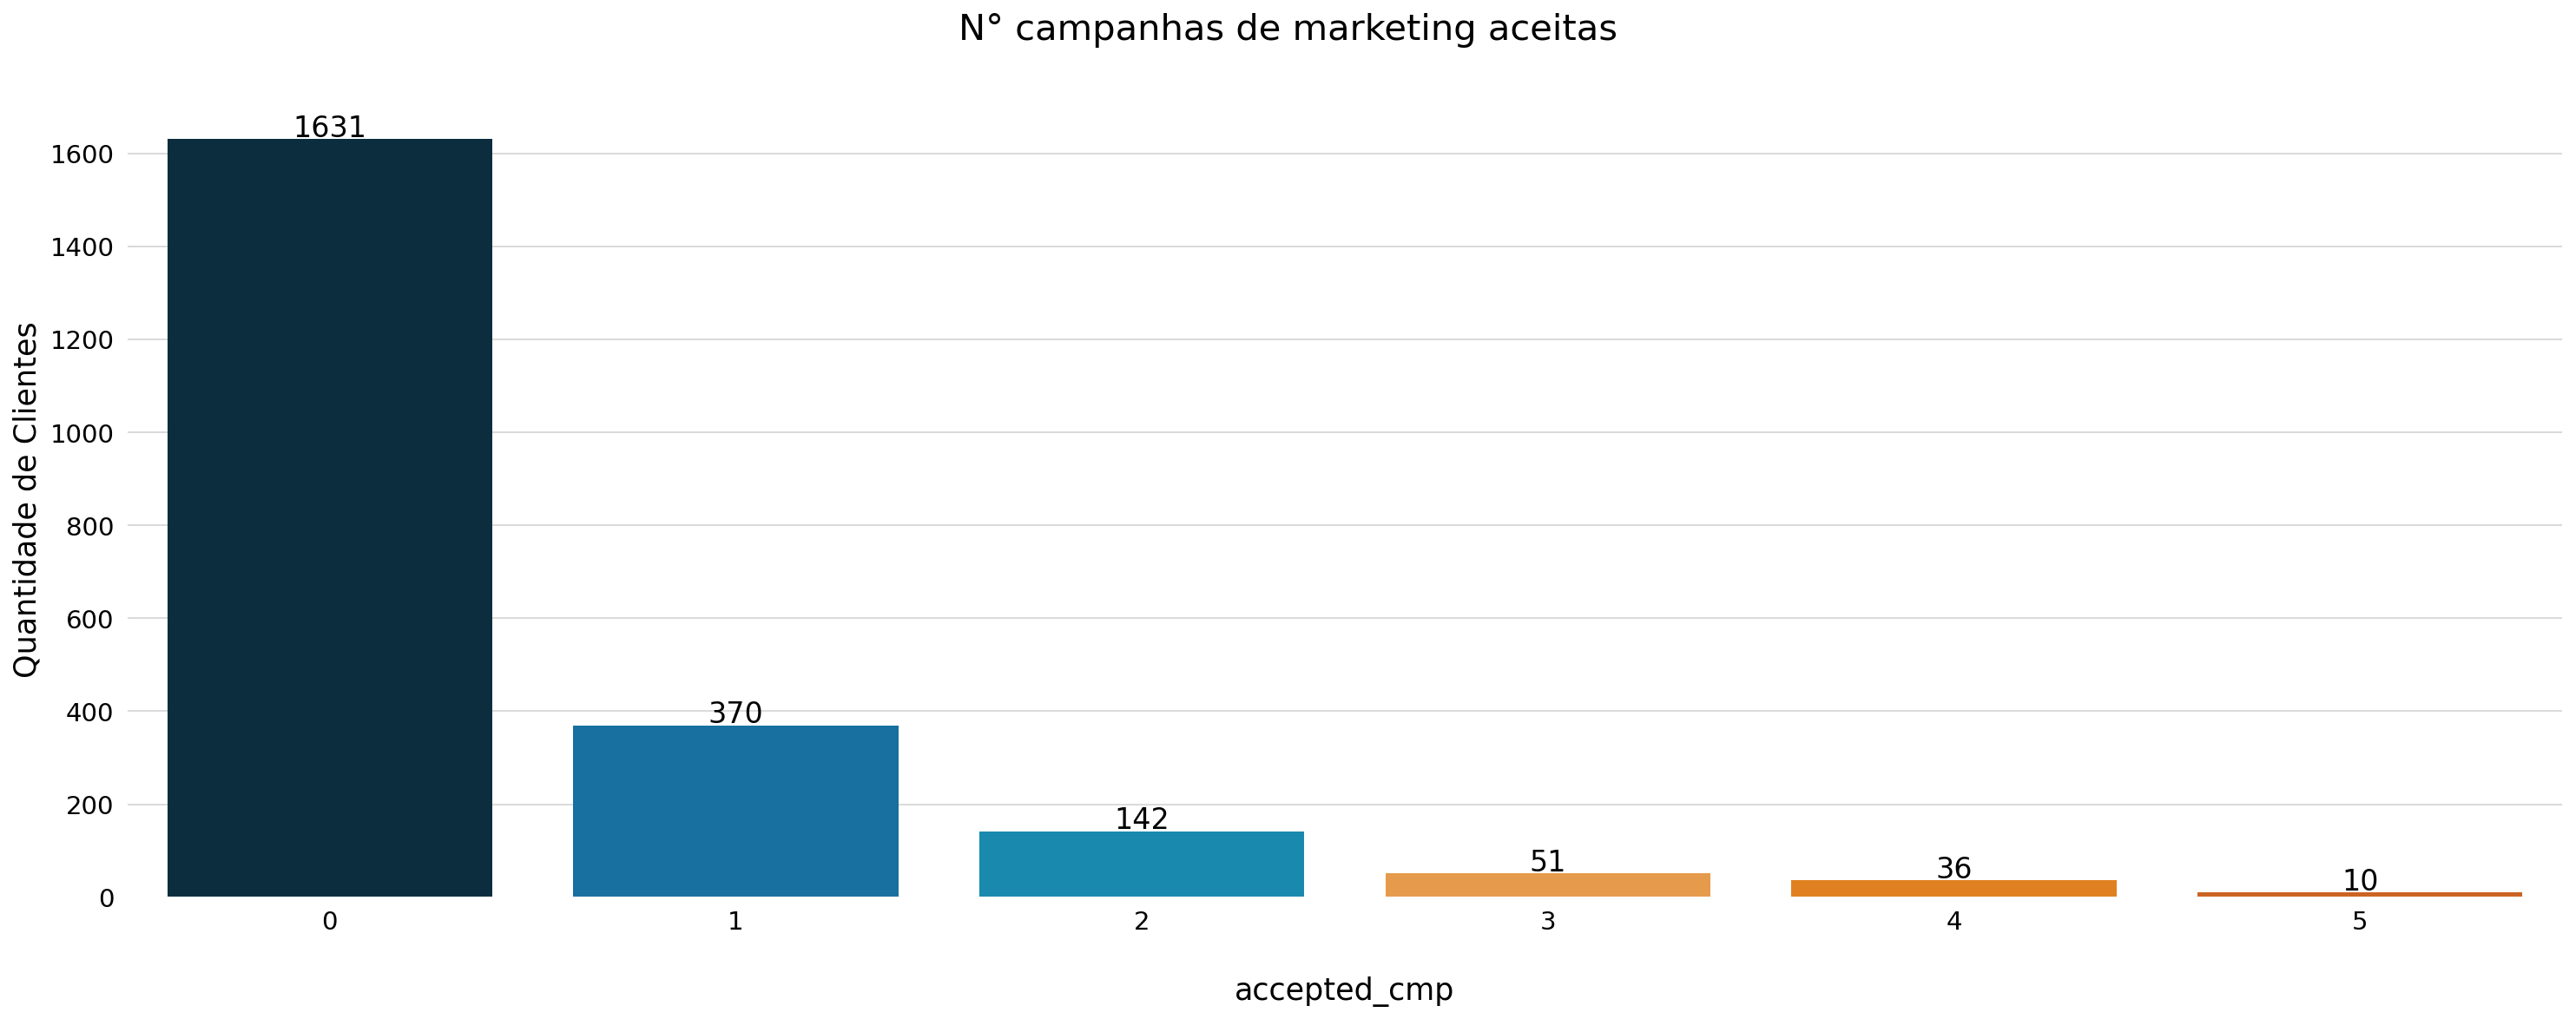

In [74]:
# Visualizando os dados 
countplot(df_promotion, 'accepted_cmp', 'N° campanhas de marketing aceitas')

In [75]:
# Reduzindo o Dataframe para apenas o 'id' e o total de campanhas aceitas
df_promotion = df_promotion[['id', 'accepted_cmp']]

### 3.5. Juntando Dados

In [76]:
# Juntando Dataframes em uma lista
df_lista = [df_customer, df_products, df_purchases, df_promotion]

# Agrupando os Dataframes em um conjunto final
df_final = reduce(lambda df1, df2: pd.merge(df1, df2, on='id'), df_lista)

# Visualizando informações
df_shape(df_final)
print('\n', df_final.columns)

Número de linhas: 2,203
Número de colunas: 25

 Index(['id', 'education', 'income', 'recency', 'age', 'divorced', 'single',
       'together', 'widow', 'children_home', 'lifetime', 'wines', 'fruits',
       'meat', 'fish', 'sweet', 'golds', 'total_amount', 'deals_p', 'web_p',
       'catalog_p', 'store_p', 'web_visits', 'total_p', 'accepted_cmp'],
      dtype='object')


In [77]:
# Salvando os ids dos clientes para comparação futura
clients_ids = df_final['id']

# Removendo a variável 'id' pois não transmite informações úteis para a clusterização
clustering_features = df_final.drop(['id'], axis=1)

### 3.6. Normalização das Variáveis

- Visto que será empregado um algoritmo de ___ é necessário que os dados estejam normalizados. Assim, ___

In [78]:
# Realizando a Normalização das Variáveis conforme função MinMax manual
df_scaled = manual_scaler(clustering_features)

# Visualizando informações
df_scaled.describe().T

count  mean  std  min  25%  50%  75%  max
education     2203.00  0.62 0.25 0.00 0.50 0.50 0.75 1.00
income        2203.00  0.31 0.13 0.00 0.21 0.31 0.41 1.00
recency       2203.00  0.49 0.29 0.00 0.24 0.49 0.75 1.00
age           2203.00  0.48 0.21 0.00 0.34 0.46 0.66 1.00
divorced      2203.00  0.10 0.30 0.00 0.00 0.00 0.00 1.00
single        2203.00  0.21 0.41 0.00 0.00 0.00 0.00 1.00
together      2203.00  0.65 0.48 0.00 0.00 1.00 1.00 1.00
widow         2203.00  0.03 0.18 0.00 0.00 0.00 0.00 1.00
children_home 2203.00  0.32 0.25 0.00 0.00 0.33 0.33 1.00
lifetime      2203.00  0.51 0.29 0.00 0.26 0.51 0.76 1.00
wines         2203.00  0.48 0.24 0.00 0.30 0.48 0.67 1.00
fruits        2203.00  0.11 0.12 0.00 0.02 0.07 0.16 1.00
meat          2203.00  0.25 0.13 0.00 0.16 0.23 0.33 1.00
fish          2203.00  0.12 0.13 0.00 0.02 0.08 0.18 1.00
sweet         2203.00  0.05 0.06 0.00 0.01 0.03 0.07 1.00
golds         2203.00  0.13 0.12 0.00 0.04 0.09 0.19 1.00
total_amount  2203.00  0.24 0.24 0.00 0.02 0.15 0.41 1.00
deals_p       2203.00  0.24 0.17 0.00 0.08 0.20 0.33 1.00
web_p         2203.00  0.33 0.12 0.00 0.25 0.33 0.40 1.00
catalog_p     2203.00  0.16 0.14 0.00 0.00 0.15 0.25 1.00
store_p       2203.00  0.51 0.15 0.00 0.40 0.50 0.60 1.00
web_visits    2203.00  0.27 0.12 0.00 0.15 0.30 0.35 1.00
total_p       2203.00  0.37 0.23 0.00 0.16 0.35 0.58 1.00
accepted_cmp  2203.00  0.09 0.18 0.00 0.00 0.00 0.20 1.00

## 4. Modelagem

### 4.1. Método de Elbow

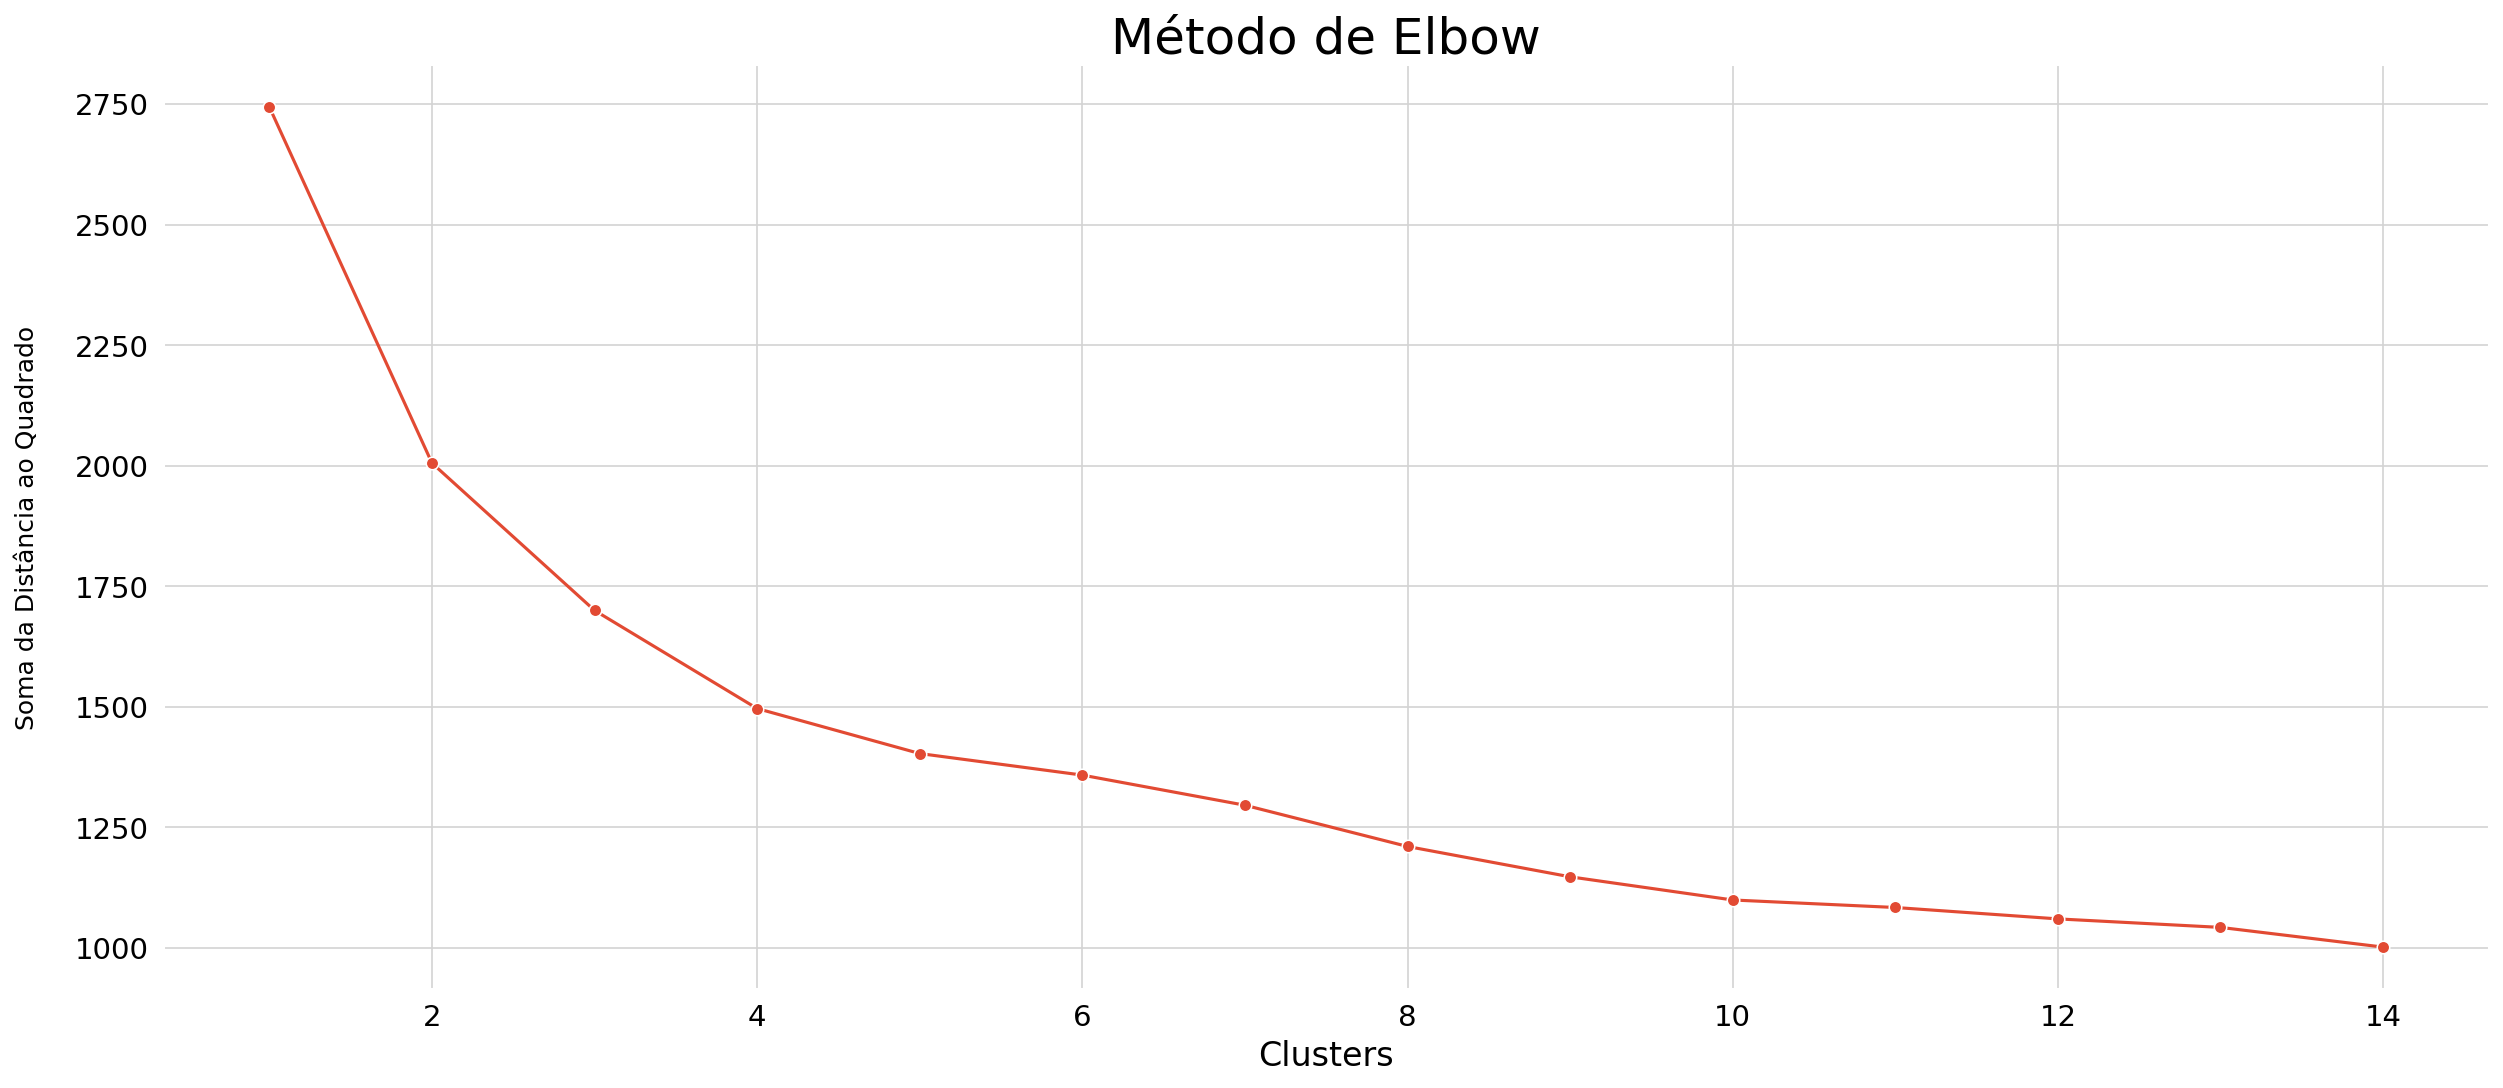

In [79]:
# Utilizando a função previamente criada que calcula e transforma em imagem o Método de Elbow
# Escolhe-se número de clusters igual a 14 para o dataframe normalizado
elbow_method(df_scaled, 14)

### 4.2. Alocação de Pesos

- Esta parte é realizada em conjunto com a equipe de negócios
- As variáveis e seus pesos são decididos conforme a importância que queremos atribuir a cada uma
- O total de dinheiro gasto é entendida como uma variávei muito importante para separar os clientes, então para atribuir essa importância maior, alocaremos um peso de 8 nesta variável
- À medida que a importância das variáveis diminui, os seus pesos também diminui

In [80]:
# Criando um novo Dataframe ponderado com base no Dataframe normalizado
df_weighted = df_scaled.copy()

# Variáveis para ponderar
variaveis = ['total_amount', 'total_p', 'recency', 'web_visits', 'income', 'lifetime', 
             'age', 'children_home', 'education']

# Alocação de pesos
pesos = {'total_amount': 8, 'total_p': 6, 'recency': 4, 'web_visits': 4, 'income': 4, 
         'lifetime': 4, 'age': 2, 'children_home': 2, 'education': 2}

# Aplicando a alocação de pesos
df_weighted[variaveis] = df_weighted[variaveis].apply(lambda x: x * pesos[x.name])

### 4.3. K-MEANS

In [81]:
# Implementando KMeans com 4 clusters, conforme método de Elbow
model = KMeans(n_clusters=4, max_iter=500, random_state=44)
# Treinamento e alocação de clusters 
clusters_results = model.fit_predict(df_weighted)
# Visualizando o array
clusters_results

array([2, 3, 0, ..., 0, 0, 3])

### 4.4. Salvando Modelo Pickle

In [82]:
# Salvando apenas as informações necessárias para rodar o modelo
model_info = {
    'model': model,
    'clusters_results': clusters_results}

with open('../models/kmeans_model.pkl', 'wb') as model_file:
    pickle.dump(model_info, model_file)

In [83]:
# with open('../models/kmeans_model.pkl', 'rb') as model_file:
#     loaded_model_info = pickle.load(model_file)

# loaded_model = loaded_model_info['model']
# loaded_clusters_results = loaded_model_info['clusters_results']

## 5. Avaliação de Resultados

In [84]:
# É possível salvar o resultado juntamente com a identificação de cada cliente em um Dataframe
df_id_cluster = pd.DataFrame({'id': clients_ids, 'cluster': clusters_results})

In [85]:
# Também é possível salvar o resultado de clusters juntamente com todo o Dataframe de informações
df_final.insert(1, 'cluster', clusters_results)

df_final

id  cluster  education   income  recency  age  divorced  single  \
0      5524        2          2 58138.00       58   57         0       1   
1      2174        3          2 46344.00       38   60         0       1   
2      4141        0          2 71613.00       26   49         0       0   
3      6182        3          2 26646.00       26   30         0       0   
4      5324        1          4 58293.00       94   33         0       0   
...     ...      ...        ...      ...      ...  ...       ...     ...   
2198  10870        2          2 61223.00       46   47         0       0   
2199   4001        0          4 64014.00       56   68         0       0   
2200   7270        0          2 56981.00       91   33         1       0   
2201   8235        0          3 69245.00        8   58         0       0   
2202   9405        3          4 52869.00       40   60         0       0   

      together  widow  children_home  lifetime  wines  fruits  meat  fish  \
0            0      0              0     25.37   0.39    0.05  0.34  0.11   
1            0      0              2      7.03   0.41    0.04  0.22  0.07   
2            1      0              0     13.67   0.55    0.06  0.16  0.14   
3            1      0              1      7.90   0.21    0.08  0.38  0.19   
4            1      0              1      8.63   0.41    0.10  0.28  0.11   
...        ...    ...            ...       ...    ...     ...   ...   ...   
2198         1      0              1     15.97   0.53    0.03  0.14  0.03   
2199         1      0              3      3.90   0.91    0.00  0.07  0.00   
2200         0      0              0      8.43   0.73    0.04  0.17  0.03   
2201         1      0              1      8.47   0.51    0.04  0.25  0.09   
2202         1      0              2     24.00   0.49    0.02  0.35  0.01   

      sweet  golds  total_amount  deals_p  web_p  catalog_p  store_p  \
0      0.05   0.05          1617     0.14   0.36       0.45     0.18   
1      0.04   0.22            27     0.50   0.25       0.25     0.50   
2      0.03   0.05           776     0.05   0.40       0.10     0.50   
3      0.06   0.09            53     0.33   0.33       0.00     0.67   
4      0.06   0.04           422     0.36   0.36       0.21     0.43   
...     ...    ...           ...      ...    ...        ...      ...   
2198   0.09   0.18          1341     0.12   0.56       0.19     0.25   
2199   0.00   0.02           444     0.47   0.53       0.13     0.33   
2200   0.01   0.02          1241     0.06   0.11       0.17     0.72   
2201   0.04   0.07           843     0.10   0.29       0.24     0.48   
2202   0.01   0.12           172     0.38   0.38       0.12     0.50   

      web_visits  total_p  accepted_cmp  
0              7       22             1  
1              5        4             0  
2              4       20             0  
3              6        6             0  
4              5       14             0  
...          ...      ...           ...  
2198           5       16             0  
2199           7       15             1  
2200           6       18             1  
2201           3       21             0  
2202           7        8             1  

[2203 rows x 26 columns]

### 5.1. Análise de Clusters

In [86]:
# Quantidade de cada cluster
cluster_counts = df_final['cluster'].value_counts()

# Porcentagem de cada cluster
cluster_percentages = cluster_counts / len(df_weighted) * 100

# Criando Dataframe com informações
df_cluster_info = pd.DataFrame({
    'cluster': cluster_counts.index,
    '#count': cluster_counts.values,
    '%pctge': cluster_percentages.values})

# Mudando o index e visualizando o Dataframe
df_cluster_info.set_index('cluster')

#count  %pctge
cluster                
0           629   28.55
3           588   26.69
1           567   25.74
2           419   19.02

In [87]:
# Analisando a média das variáveis para cada cluster
df_final.groupby('cluster').mean()

id  education   income  recency   age  divorced  single  \
cluster                                                                
0       5584.02       2.56 63507.67    48.18 48.25      0.11    0.18   
1       5407.84       2.31 36529.31    74.72 43.94      0.11    0.21   
2       5632.97       2.60 77120.23    50.84 45.24      0.10    0.25   
3       5687.27       2.39 36536.30    23.73 42.72      0.09    0.23   

         together  widow  children_home  lifetime  wines  fruits  meat  fish  \
cluster                                                                        
0            0.66   0.05           0.84     15.30   0.53    0.05  0.23  0.06   
1            0.66   0.02           1.27     14.68   0.40    0.05  0.25  0.08   
2            0.61   0.03           0.30     16.95   0.50    0.04  0.31  0.06   
3            0.65   0.03           1.22     13.85   0.42    0.05  0.23  0.08   

         sweet  golds  total_amount  deals_p  web_p  catalog_p  store_p  \
cluster                                                                   
0         0.05   0.08        824.60     0.16   0.33       0.21     0.45   
1         0.06   0.17        132.14     0.35   0.35       0.09     0.56   
2         0.04   0.05       1606.07     0.08   0.28       0.31     0.42   
3         0.05   0.16        126.08     0.34   0.34       0.08     0.57   

         web_visits  total_p  accepted_cmp  
cluster                                     
0              4.57    18.37          0.39  
1              6.39     6.75          0.12  
2              3.46    20.32          1.25  
3              6.34     6.57          0.26

### 5.2. Análise Gráfica de Clusters

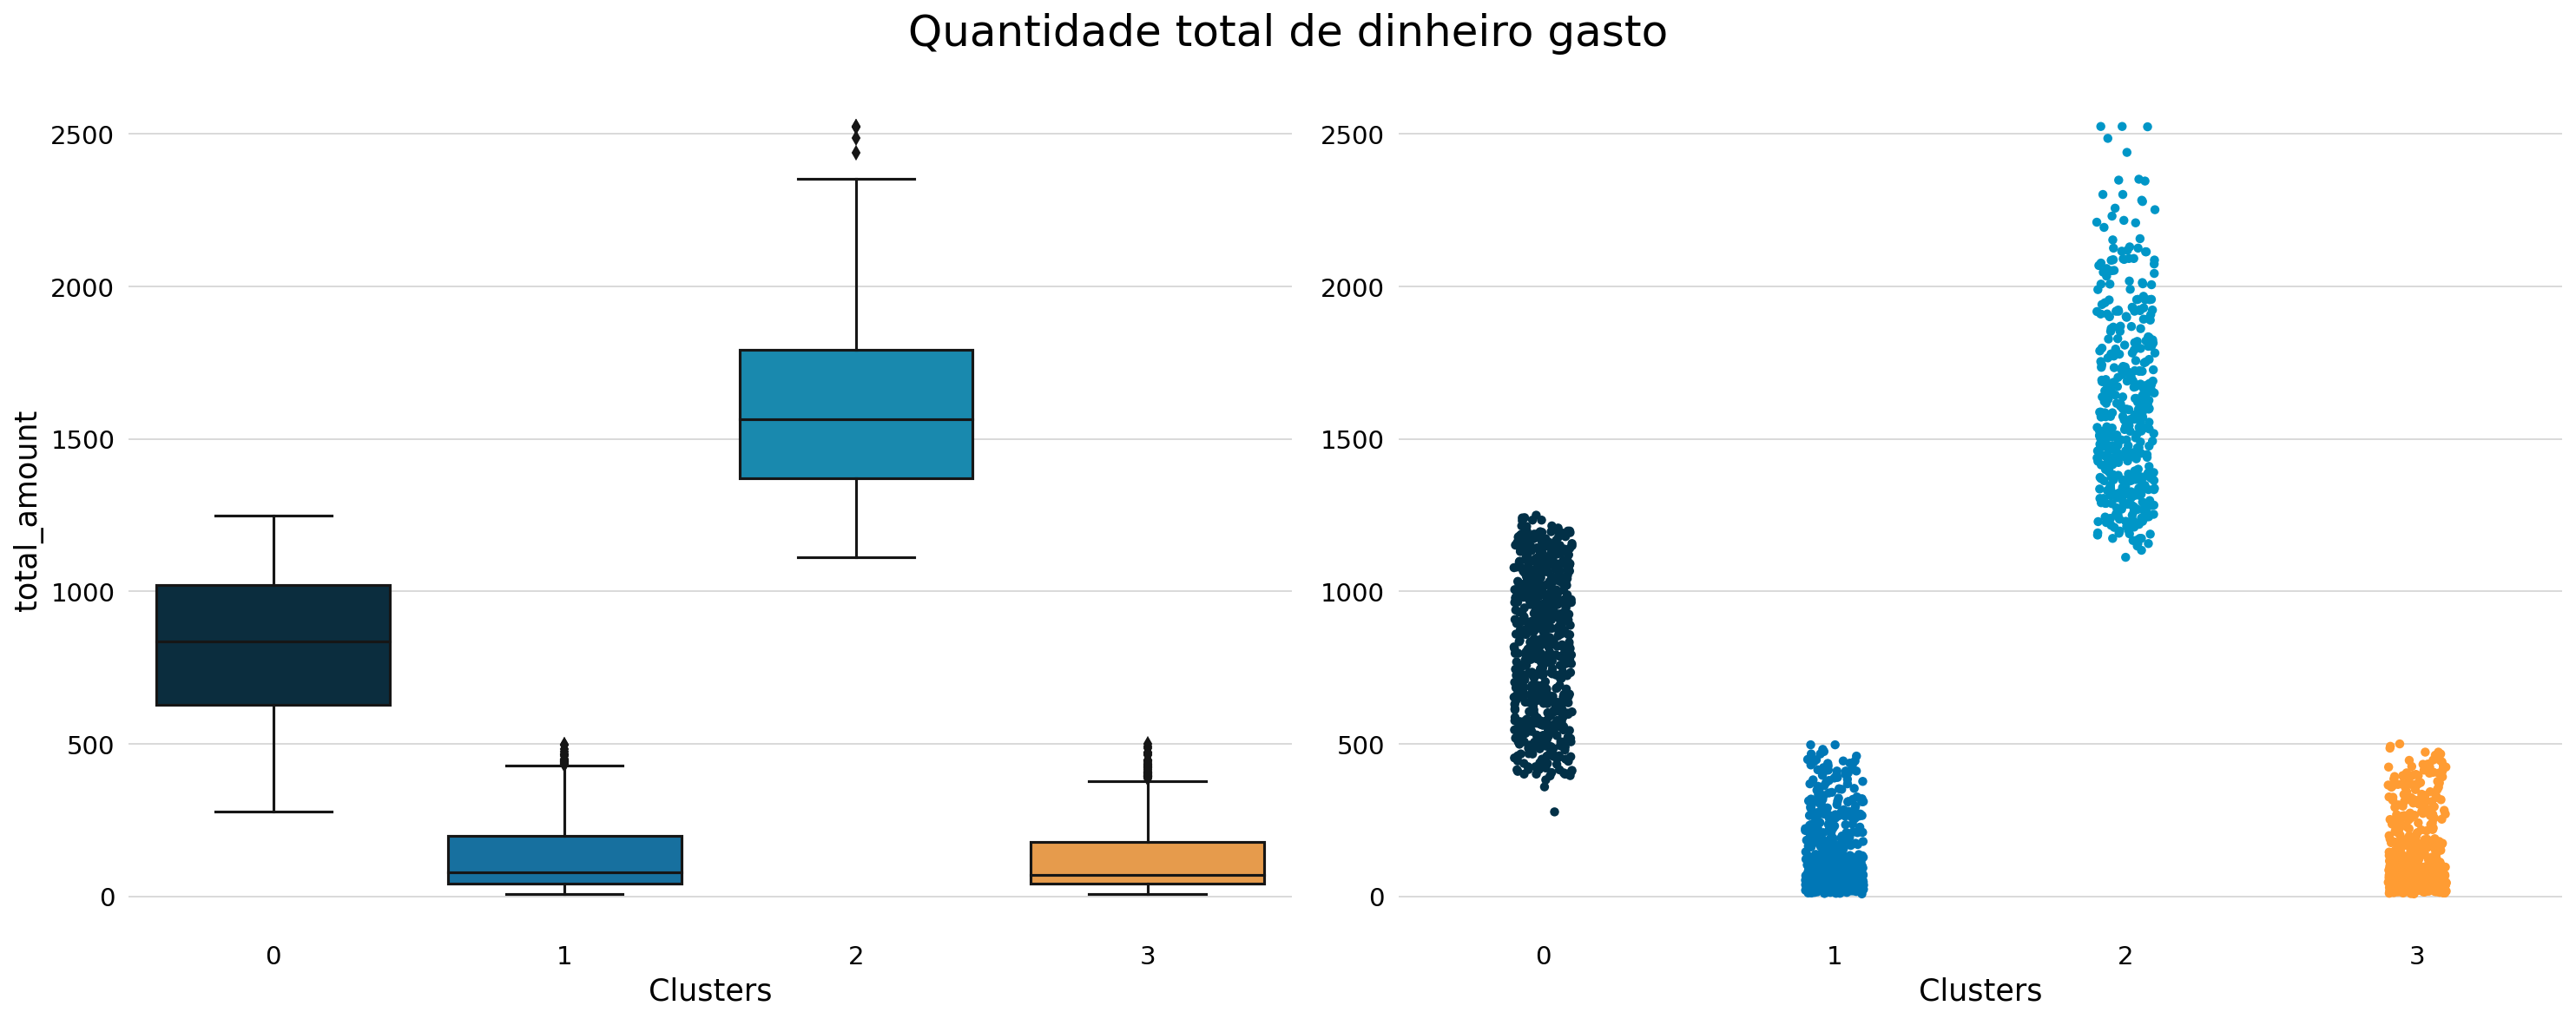

In [88]:
# Quantidade total de dinheiro gasto por cluster
cluster_box_strip(df_final, 'total_amount', 'Quantidade total de dinheiro gasto')

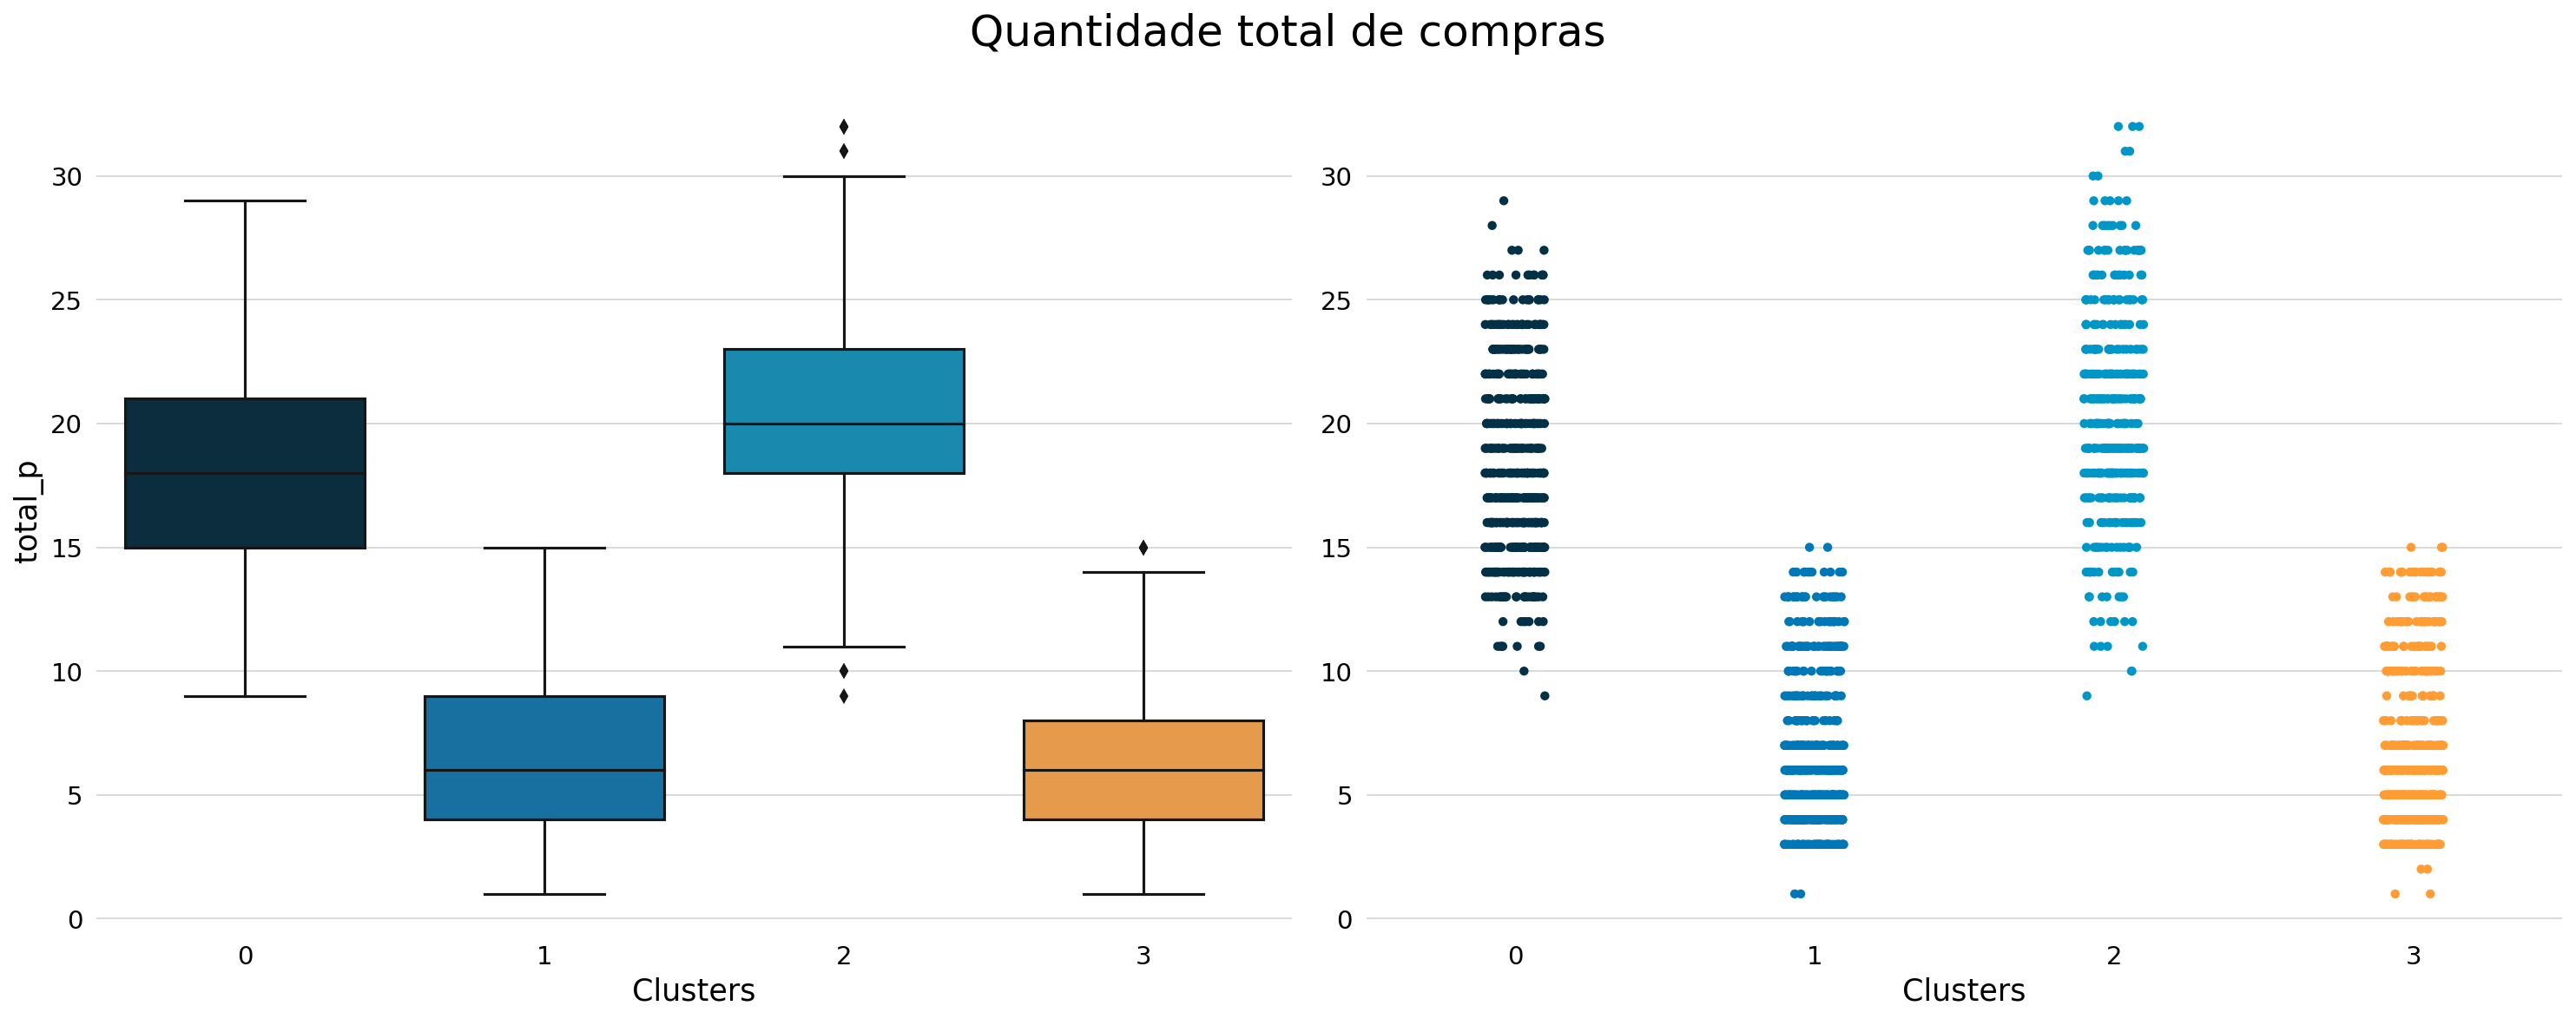

In [89]:
cluster_box_strip(df_final, 'total_p', 'Quantidade total de compras')

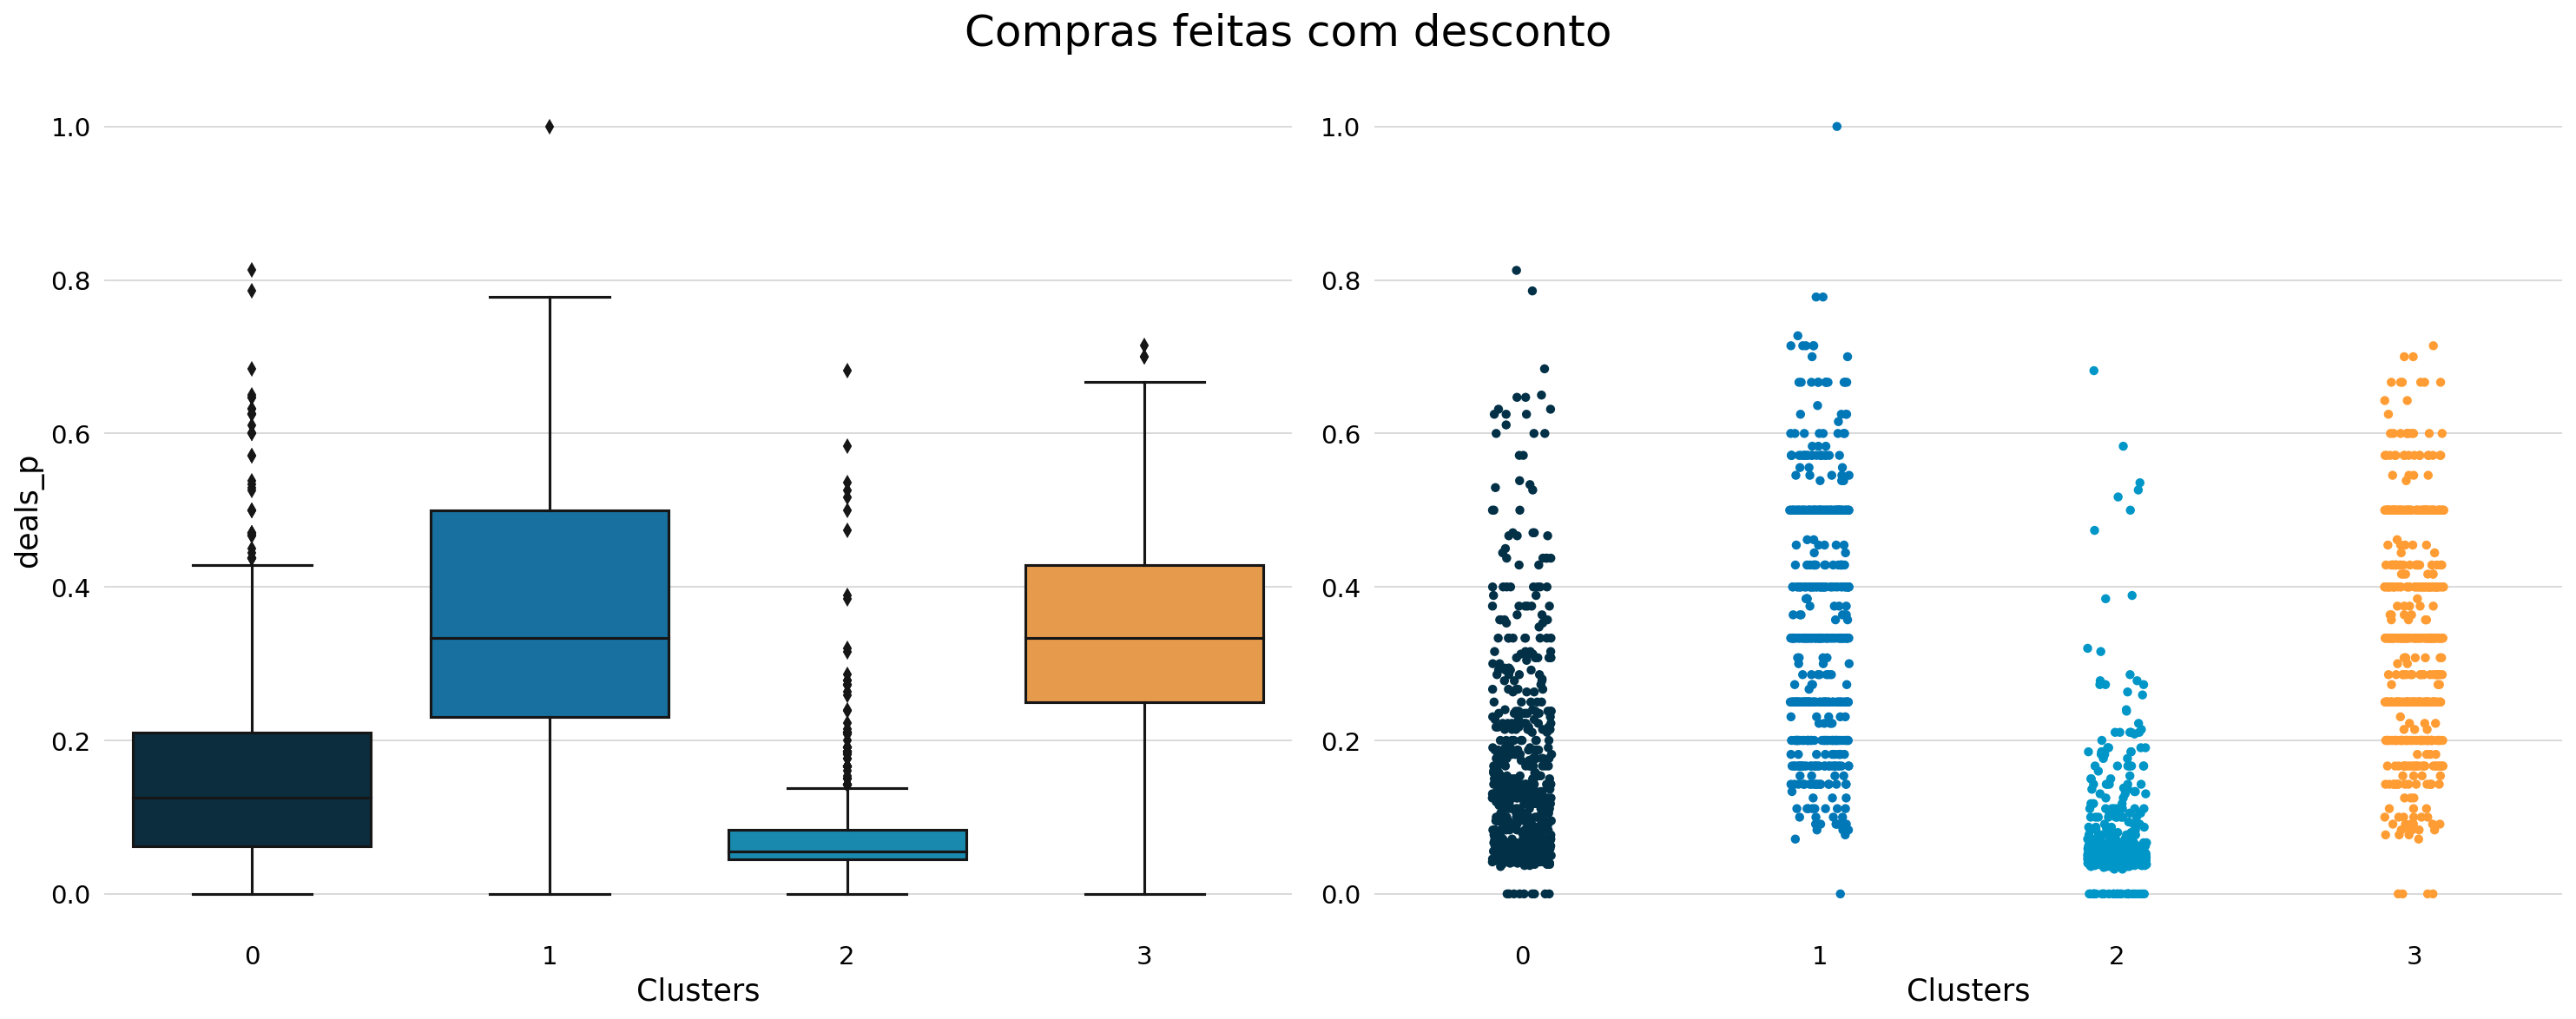

In [90]:
cluster_box_strip(df_final, 'deals_p', 'Compras feitas com desconto')

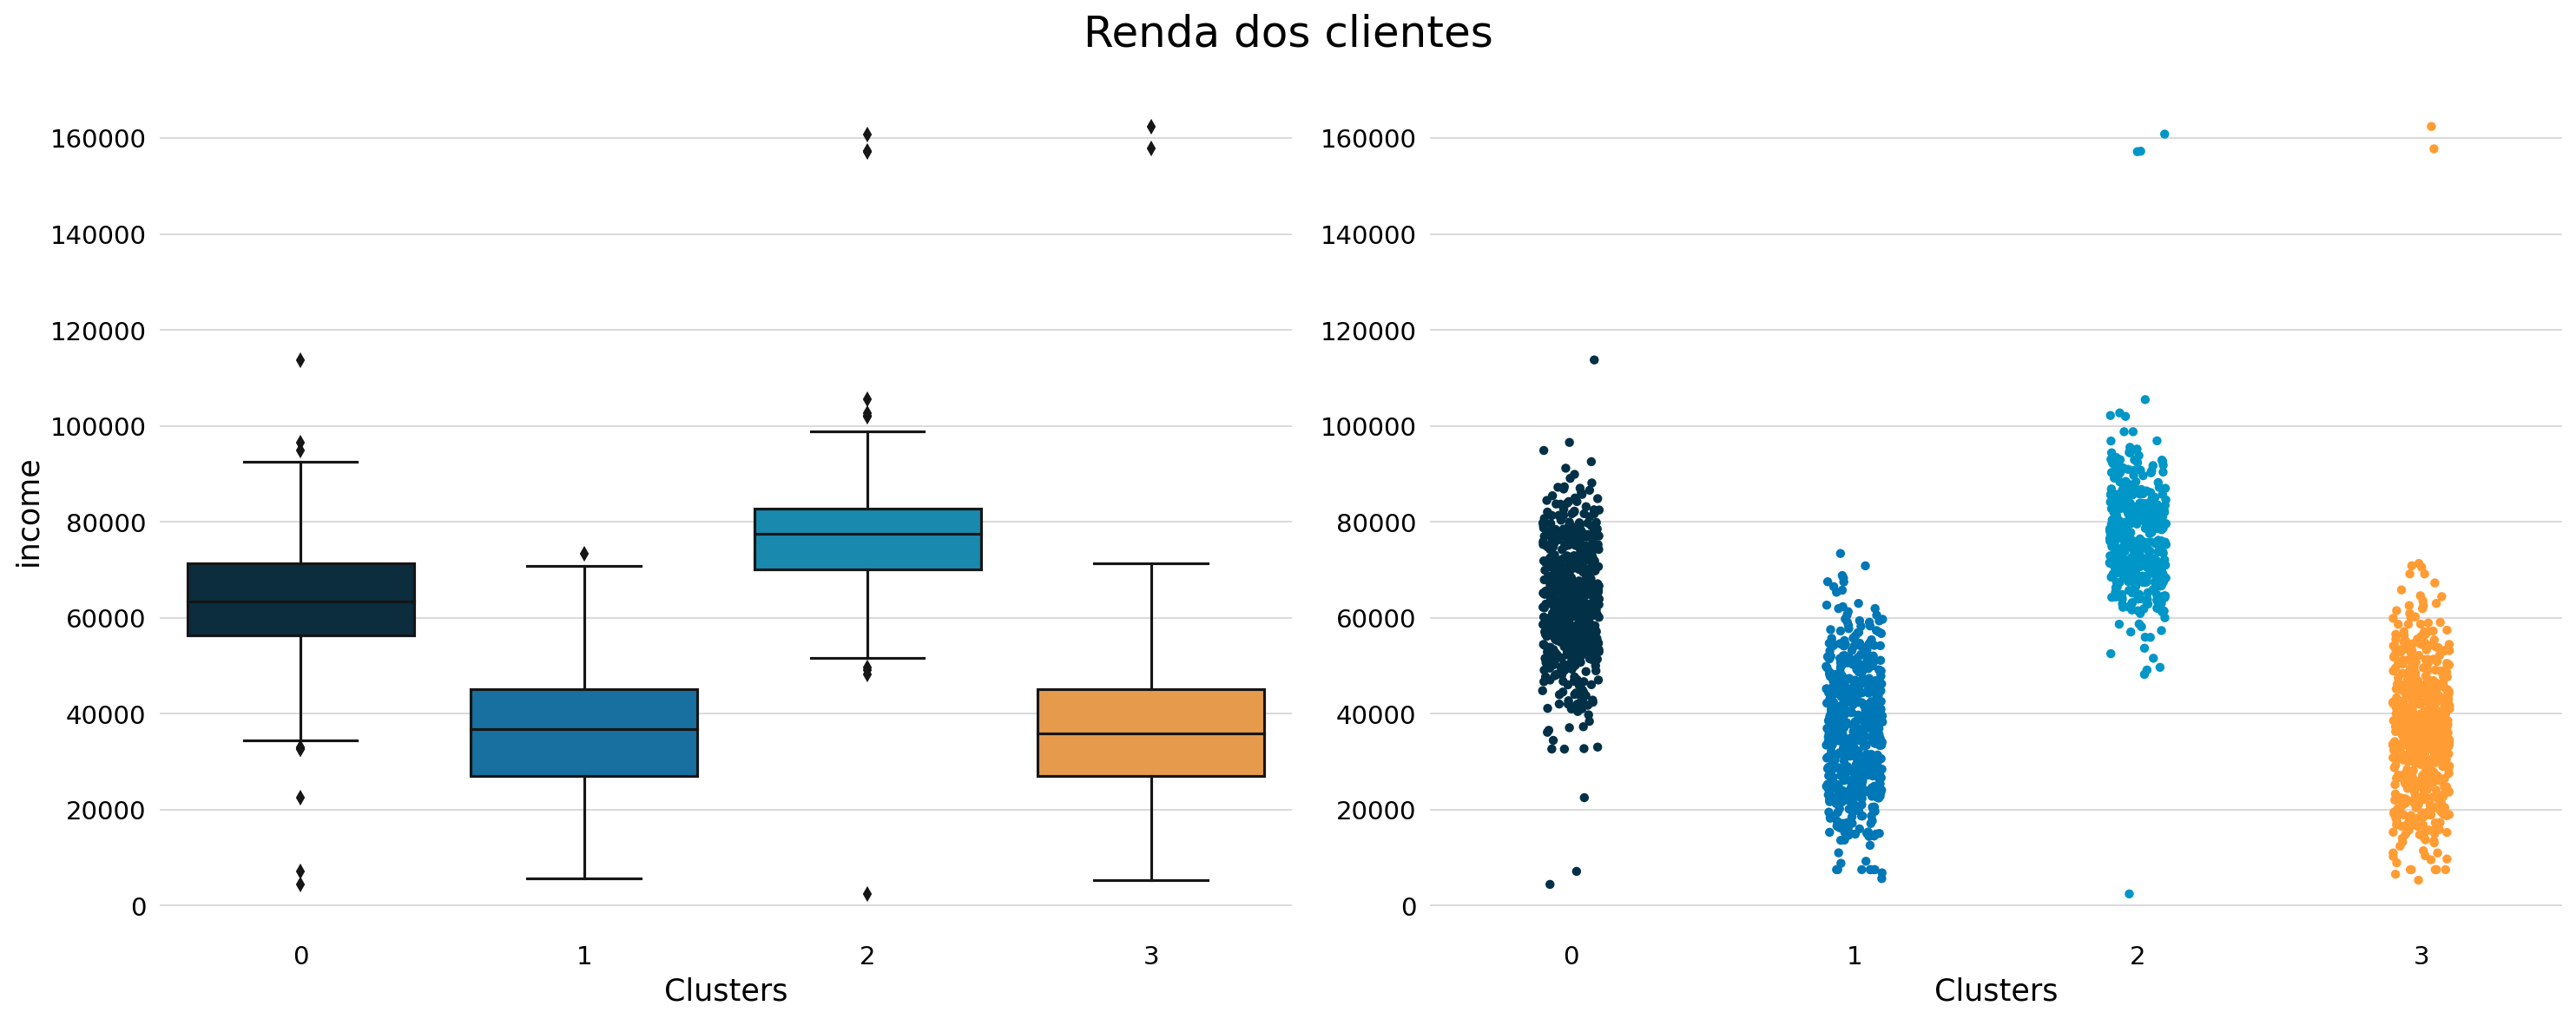

In [91]:
cluster_box_strip(df_final, 'income', 'Renda dos clientes')

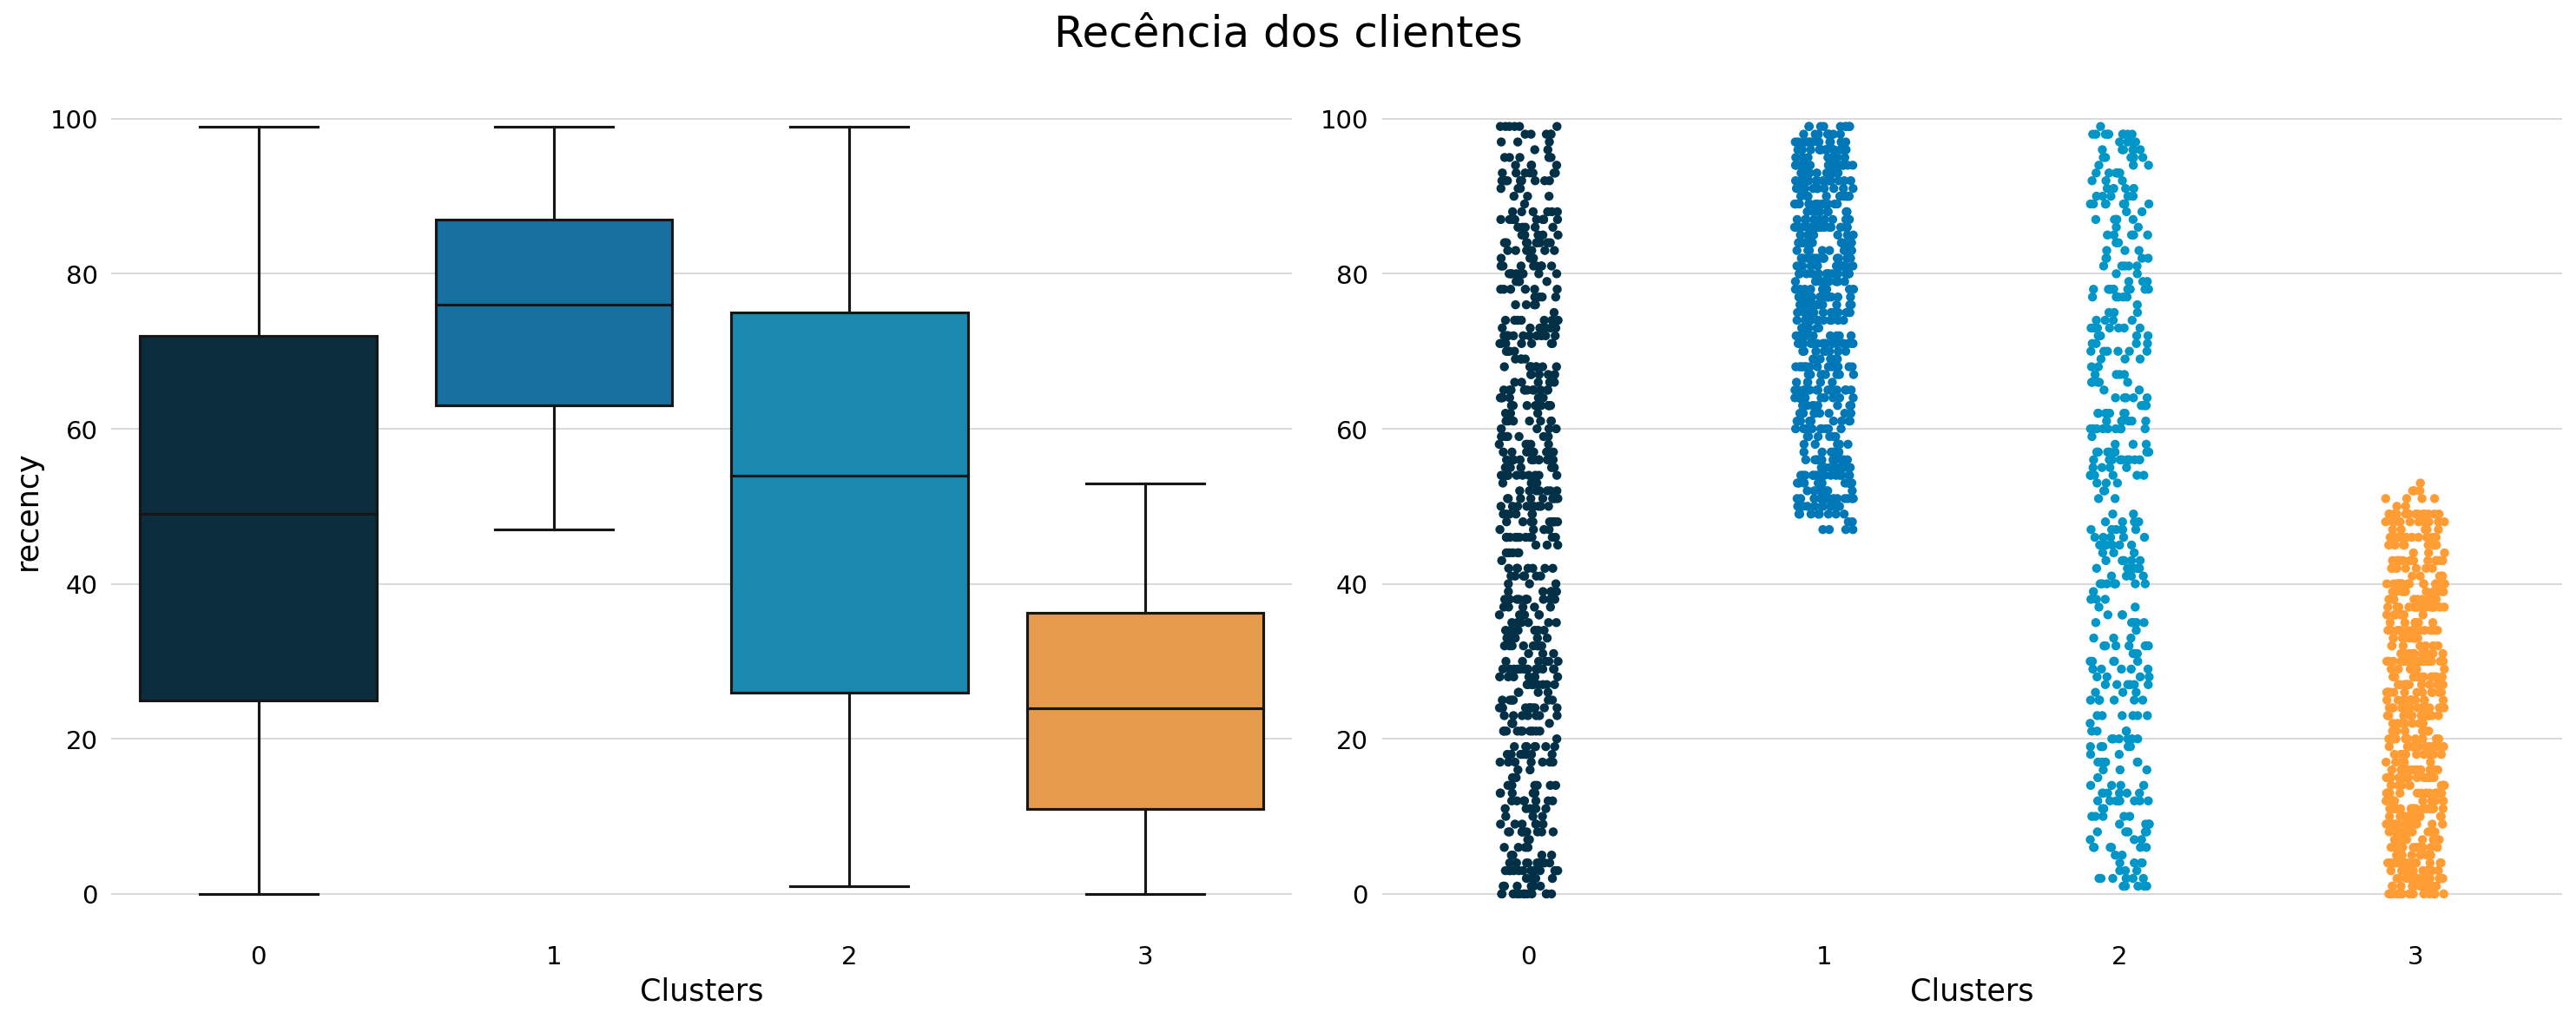

In [92]:
cluster_box_strip(df_final, 'recency', 'Recência dos clientes')

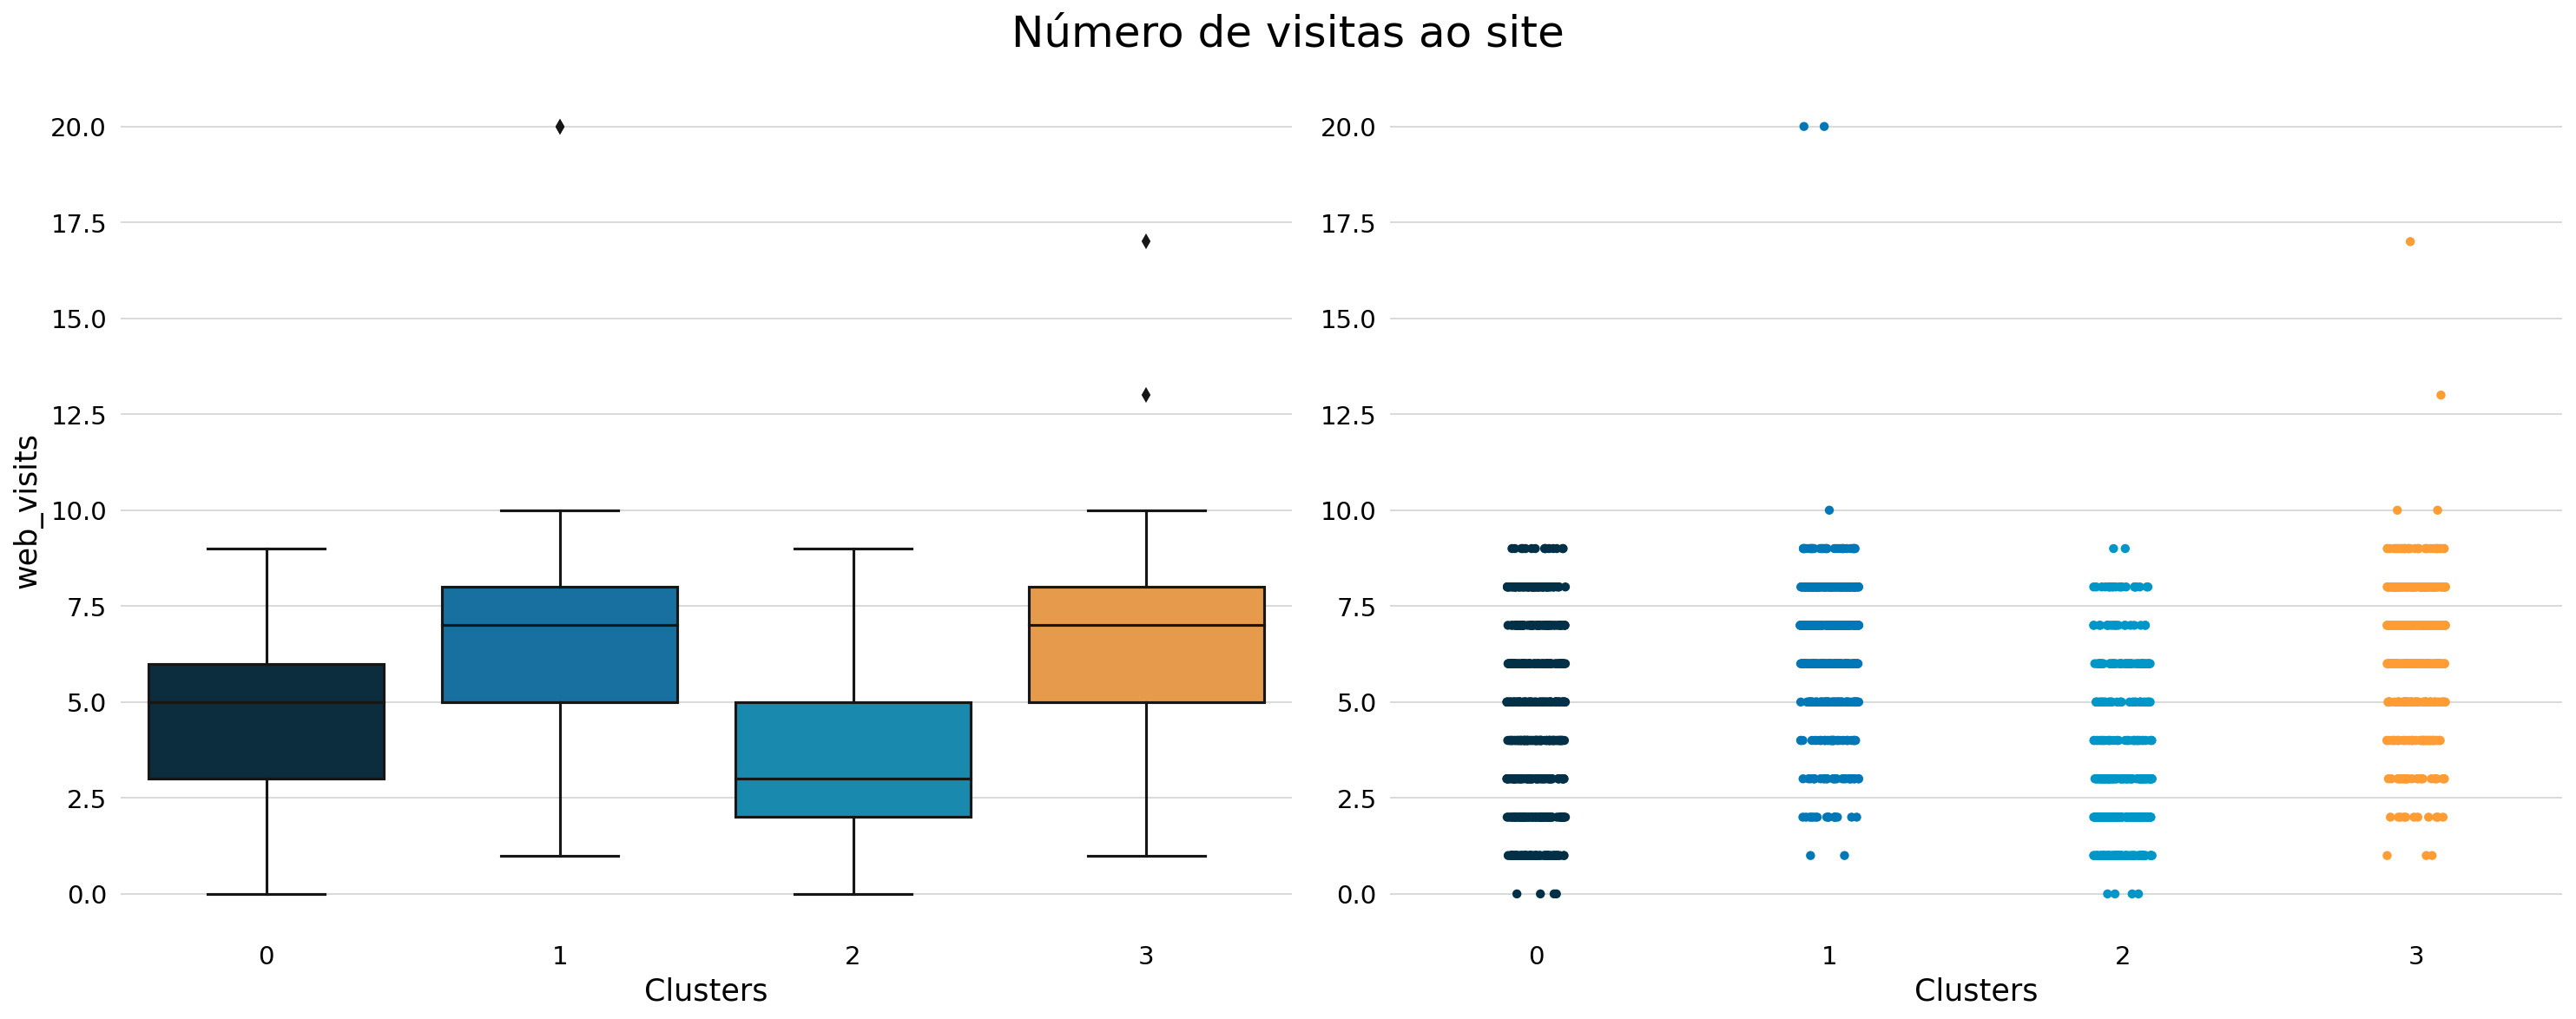

In [93]:
cluster_box_strip(df_final, 'web_visits', 'Número de visitas ao site')

## 6. Documentação